In [100]:
import catboost as cb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt 

import helper
import missingno as msno

import datetime

In [37]:
## Check date ranges

def check_dates(frames, frame_names):
    """
    """
    for idx, frame in enumerate(frames):
        date_range = str(frame['Time'].dt.date.min()) + ' to ' +str(frame['Time'].dt.date.max())
        print(f'{frame_names[idx]}: {date_range}')

In [38]:
## Set target name
target_name = 'zori_ssa'

###  Load pre-compiled dataframe

In [4]:
frame = pd.read_csv('all_vars.csv', index_col=0, parse_dates=['Time'])

In [5]:
frame.drop(columns=['zip_code', 'Time'], axis=1)
frame.isnull().sum()

Time                  0
zip_code              0
zori_ssa              0
mintempC              0
maxtempC              0
                     ..
employed_pop          0
unemployed_pop        0
pop_in_labor_force    0
armed_forces          0
year                  0
Length: 117, dtype: int64

In [7]:
## These are the non-numerical columns
obj_items = frame.select_dtypes(include=['object'])
# obj_items are 'State', 'metro', 'county', 'city'
print(obj_items)
## For now, drop them
# frame = frame.drop(columns=['State', 'metro', 'county', 'city'], axis=1)
frame = frame.drop(obj_items, axis=1)

      State        metro  county         city
0        TX      Houston  harris         KATY
1        TX      Houston  harris         KATY
2        TX      Houston  harris         KATY
3        TX      Houston  harris         KATY
4        TX      Houston  harris         KATY
...     ...          ...     ...          ...
19775    TX  San Antonio   bexar  SAN ANTONIO
19776    TX  San Antonio   bexar  SAN ANTONIO
19777    TX  San Antonio   bexar  SAN ANTONIO
19778    TX  San Antonio   bexar  SAN ANTONIO
19779    TX  San Antonio   bexar  SAN ANTONIO

[19780 rows x 4 columns]


In [8]:
y = frame['zori_ssa']
X = frame.drop(columns=['zori_ssa', 'Time', 'zip_code'], axis=1)

In [9]:
# test/train split for not time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)


### Load New Dataset

In [39]:
## load target
main_frame = pd.read_csv('cleaned_data/long_interpolated_target.csv', index_col=0, parse_dates=['Time'])

## ACS
acs = pd.read_csv('cleaned_data/acs_clean.csv', index_col=0, parse_dates=['Time'])
acs2 = pd.read_csv('cleaned_data/acs2_clean.csv', index_col=0, parse_dates=['Time'])

In [40]:
acs2.isna().sum()

zip_code                            0
commuting_population                0
divorced_men                        0
driving_alone_population            0
housing_units_built_1940_to_1949    0
                                   ..
men_with_hs_diploma                 0
quintile_5_mean_income              0
quintile_2_mean_income              0
male_75_to_79                       0
Time                                0
Length: 156, dtype: int64

In [41]:
## Check if any columns in common
acs2_set = set(acs2.columns.to_list())
acs_set = set(acs.columns.to_list())
print(f'in ACS2 but not ACS')
print(f'{acs2_set - acs_set}\n')
print(f'in ACS but not ACS2\n')
print(f'{acs_set - acs2_set}\n')
print(f'in both\n')
print(f'{acs2_set.intersection(acs_set)}')

in ACS2 but not ACS
{'women_with_bachelors_degree', 'single_men', 'housing_units_5_to_9_units_rented', 'male_22_to_24', 'female_85_over', 'housing_units_built_1940_to_1949', 'male_50_to_54', 'housing_units_single_family_attached_rented', 'housing_units_5_to_9_units_owned', 'women_with_hs_diploma', 'quintile_1_income_share', 'total_population_in_renter_occupied_units', 'quintile_1_mean_income', 'male_35_to_39', 'male_62_to_64', 'quintile_5_income_share', 'median_contract_rent', 'male_75_to_79', 'men_with_bachelors_degree', 'total_population_in_owner_occupied_units', 'owner_occupied_units', 'median_gross_rent', 'male_20', 'housing_units_20_to_49_units_rented', 'female_45_to_49', 'male_45_to_49', 'female_30_to_34', 'widowed_men', 'housing_units_built_1970_to_1979', 'total_population', 'top_5_percent_mean_income', 'gini_coeficient', 'married_men_spouse_present', 'women_with_masters_degree', 'housing_units_built_1960_to_1969', 'quintile_3_upper_limit', 'taxi_population', 'quintile_3_income_

In [42]:
## Get list of feature files
feature_frames = [main_frame,
#                     weather, 
#                    env_viol, 
#                    daycare, 
#                    econ, 
#                    city_unemp, 
#                    gas_prices, 
#                    monthly_tnx, 
#                    polling, 
#                    covid, 
#                    new_biz_out, 
#                    new_biz_tax, 
#                    sales_tax, 
#                    sap,
                   acs,
                   acs2]
feature_frame_names = ['main_frame',
#                     'weather', 
#                    'env_viol', 
#                    'daycare', 
#                    'econ', 
#                    'city_unemp', 
#                    'gas_prices', 
#                    'monthly_tnx', 
#                    'polling', 
#                    'covid', 
#                    'new_biz_out', 
#                    'new_biz_tax', 
#                    'sales_tax', 
#                    'sap',
                   'acs',
                   'acs2']

In [43]:
## Check date ranges
check_dates(feature_frames, feature_frame_names)

main_frame: 2014-01-01 to 2021-07-01
acs: 2011-01-01 to 2018-12-01
acs2: 2011-01-01 to 2019-12-01


In [15]:
## Create lags based on time differences

### Tried with lags didn't work

In [44]:
## Merge all the data

acs_cols = acs.drop(columns=['Time','zip_code']).columns.to_list()
acs2_cols = acs2.drop(columns=['Time','zip_code']).columns.to_list()
# merged_frame = helper.time_lag_merge(main_frame, acs, {32:acs_cols})
# merged_frame = helper.time_lag_merge(merged_frame, acs2, {19:acs2_cols})
merged_frame = helper.time_lag_merge(main_frame, acs, {32:acs_cols})
merged_frame = helper.time_lag_merge(merged_frame, acs2, {20:acs2_cols})
check_dates([merged_frame], ['merged_frame'])

merged_frame: 2014-01-01 to 2021-07-01


<AxesSubplot:>

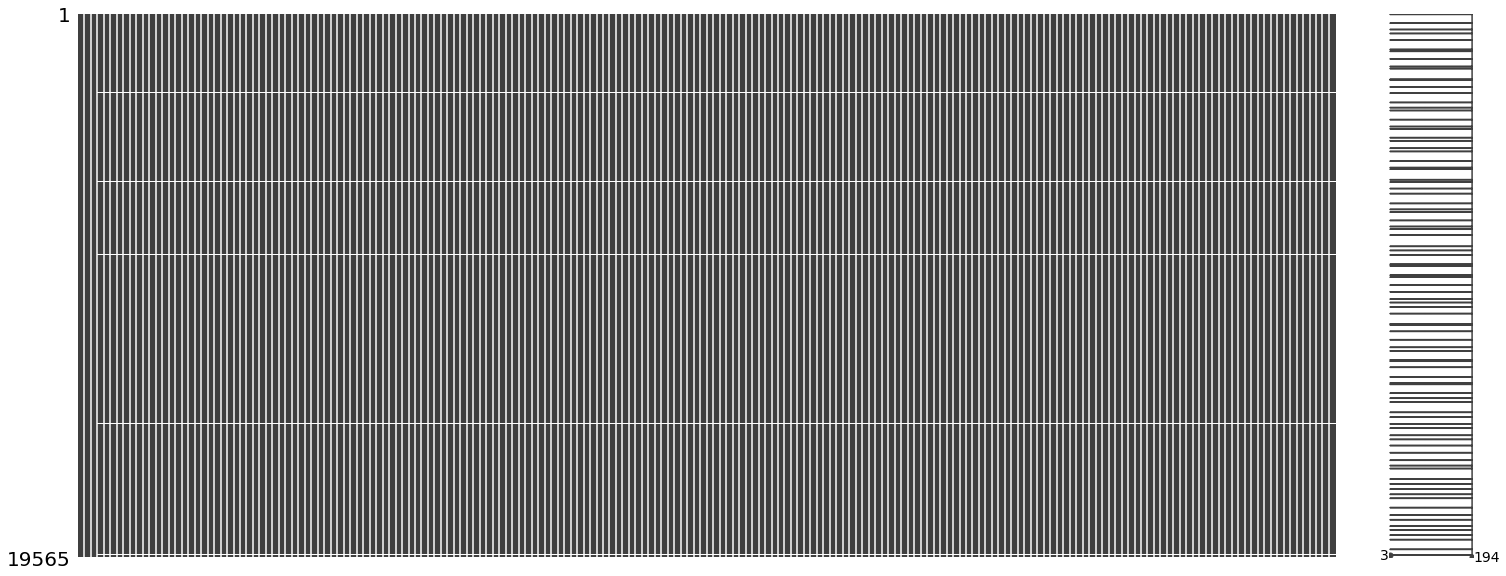

In [45]:
merged_frame = merged_frame.sort_values('Time')
msno.matrix(merged_frame)

In [46]:
## Check nulls
merged_frame.isna().sum().sort_values

<bound method Series.sort_values of Time                                            0
zip_code                                        0
zori_ssa                                        0
male_pop_32_month_shift                        91
female_pop_32_month_shift                      91
                                               ..
married_women_spouse_present_20_month_shift    91
men_with_hs_diploma_20_month_shift             91
quintile_5_mean_income_20_month_shift          91
quintile_2_mean_income_20_month_shift          91
male_75_to_79_20_month_shift                   91
Length: 194, dtype: int64>

In [47]:
## zip_code 75033 needs to be dropped
## show missing rows:
# merged_frame[merged_frame.isnull().any(axis=1)]


In [48]:
## Drop na values
merged_frame = merged_frame.dropna()
merged_frame = merged_frame.reset_index(drop=True)
print(f'shape: {merged_frame.shape}')

shape: (19474, 194)


In [49]:
## Check for categoricals
merged_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19474 entries, 0 to 19473
Columns: 194 entries, Time to male_75_to_79_20_month_shift
dtypes: datetime64[ns](1), float64(192), int64(1)
memory usage: 28.8 MB


In [50]:
## Train will be before 12/1/2017, test is from 12/1/2020
train_test_date = datetime.datetime(2020,12,1) 
merged_train = merged_frame[merged_frame['Time'] < train_test_date]
merged_test  = merged_frame[merged_frame['Time'] > train_test_date]

In [51]:
## Set features and target for test, train

y_train = merged_train[target_name]
y_test = merged_test[target_name]
X_test = merged_test.drop(columns=['zip_code', 'Time', target_name], axis=1)
X_train = merged_train.drop(columns=['zip_code', 'Time', target_name], axis=1)


In [52]:
### Run Catboost
# Testing performance
# RMSE: 161.08420537715583
# R2: 0.5135635682520305

train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')


0:	learn: 1305.7995445	test: 1301.9998090	best: 1301.9998090 (0)	total: 9.27ms	remaining: 918ms
1:	learn: 1267.8148753	test: 1264.1114245	best: 1264.1114245 (1)	total: 16ms	remaining: 784ms
2:	learn: 1231.1664357	test: 1227.4596604	best: 1227.4596604 (2)	total: 21.9ms	remaining: 709ms
3:	learn: 1195.6743840	test: 1191.9749389	best: 1191.9749389 (3)	total: 29ms	remaining: 695ms
4:	learn: 1161.1780287	test: 1157.5337134	best: 1157.5337134 (4)	total: 36.1ms	remaining: 686ms
5:	learn: 1127.8149654	test: 1124.1862588	best: 1124.1862588 (5)	total: 44.7ms	remaining: 700ms
6:	learn: 1095.5132308	test: 1091.8589173	best: 1091.8589173 (6)	total: 53.3ms	remaining: 708ms
7:	learn: 1063.9999563	test: 1060.4185513	best: 1060.4185513 (7)	total: 58.7ms	remaining: 675ms
8:	learn: 1033.6522079	test: 1030.0793745	best: 1030.0793745 (8)	total: 64.5ms	remaining: 652ms
9:	learn: 1004.1045490	test: 1000.5681725	best: 1000.5681725 (9)	total: 71ms	remaining: 639ms
10:	learn: 975.6411017	test: 972.1090083	best:

26:	learn: 108.6156163	test: 111.1015335	best: 111.1015335 (26)	total: 113ms	remaining: 305ms
27:	learn: 107.4431318	test: 110.2675604	best: 110.2675604 (27)	total: 118ms	remaining: 303ms
28:	learn: 105.8970754	test: 108.7539883	best: 108.7539883 (28)	total: 123ms	remaining: 301ms
29:	learn: 104.0580361	test: 106.6755064	best: 106.6755064 (29)	total: 128ms	remaining: 298ms
30:	learn: 103.0813491	test: 105.9228872	best: 105.9228872 (30)	total: 133ms	remaining: 296ms
31:	learn: 101.8579038	test: 104.1926611	best: 104.1926611 (31)	total: 137ms	remaining: 292ms
32:	learn: 100.5286493	test: 103.4434837	best: 103.4434837 (32)	total: 144ms	remaining: 291ms
33:	learn: 99.2120297	test: 102.1572239	best: 102.1572239 (33)	total: 149ms	remaining: 290ms
34:	learn: 97.8385294	test: 100.7865662	best: 100.7865662 (34)	total: 155ms	remaining: 289ms
35:	learn: 96.9077985	test: 99.9651120	best: 99.9651120 (35)	total: 161ms	remaining: 286ms
36:	learn: 95.9469849	test: 99.2581921	best: 99.2581921 (36)	tota

33:	learn: 517.9607487	test: 515.1376958	best: 515.1376958 (33)	total: 158ms	remaining: 308ms
34:	learn: 504.6283151	test: 501.8741708	best: 501.8741708 (34)	total: 164ms	remaining: 305ms
35:	learn: 492.2153472	test: 489.4549294	best: 489.4549294 (35)	total: 170ms	remaining: 302ms
36:	learn: 479.7500605	test: 477.0079138	best: 477.0079138 (36)	total: 175ms	remaining: 299ms
37:	learn: 467.8727211	test: 465.1697011	best: 465.1697011 (37)	total: 181ms	remaining: 296ms
38:	learn: 456.5069462	test: 453.8118459	best: 453.8118459 (38)	total: 188ms	remaining: 294ms
39:	learn: 445.5415684	test: 442.8552364	best: 442.8552364 (39)	total: 191ms	remaining: 287ms
40:	learn: 434.7842037	test: 432.1657947	best: 432.1657947 (40)	total: 197ms	remaining: 284ms
41:	learn: 424.4184006	test: 421.8359912	best: 421.8359912 (41)	total: 202ms	remaining: 279ms
42:	learn: 414.4706739	test: 411.9271924	best: 411.9271924 (42)	total: 208ms	remaining: 276ms
43:	learn: 404.8927592	test: 402.3706800	best: 402.3706800 (

43:	learn: 87.9571211	test: 90.7711486	best: 90.7711486 (43)	total: 206ms	remaining: 263ms
44:	learn: 87.0338917	test: 89.8535966	best: 89.8535966 (44)	total: 212ms	remaining: 259ms
45:	learn: 86.1177613	test: 88.9460462	best: 88.9460462 (45)	total: 216ms	remaining: 254ms
46:	learn: 85.3301828	test: 88.1639192	best: 88.1639192 (46)	total: 222ms	remaining: 250ms
47:	learn: 84.4493928	test: 87.2726038	best: 87.2726038 (47)	total: 227ms	remaining: 246ms
48:	learn: 83.6763474	test: 86.0592163	best: 86.0592163 (48)	total: 234ms	remaining: 243ms
49:	learn: 82.6350425	test: 85.3614202	best: 85.3614202 (49)	total: 239ms	remaining: 239ms
50:	learn: 82.1120099	test: 84.9597345	best: 84.9597345 (50)	total: 245ms	remaining: 235ms
51:	learn: 81.3313768	test: 83.8975723	best: 83.8975723 (51)	total: 248ms	remaining: 229ms
52:	learn: 80.4867278	test: 83.3122467	best: 83.3122467 (52)	total: 254ms	remaining: 225ms
53:	learn: 79.8692908	test: 82.3313788	best: 82.3313788 (53)	total: 258ms	remaining: 220ms

39:	learn: 445.6076610	test: 442.9223893	best: 442.9223893 (39)	total: 249ms	remaining: 374ms
40:	learn: 434.8492724	test: 432.2318881	best: 432.2318881 (40)	total: 257ms	remaining: 369ms
41:	learn: 424.4827451	test: 421.9013386	best: 421.9013386 (41)	total: 262ms	remaining: 362ms
42:	learn: 414.5351959	test: 411.9928683	best: 411.9928683 (42)	total: 267ms	remaining: 354ms
43:	learn: 404.9571981	test: 402.4363579	best: 402.4363579 (43)	total: 274ms	remaining: 349ms
44:	learn: 395.6867430	test: 393.1850909	best: 393.1850909 (44)	total: 281ms	remaining: 344ms
45:	learn: 386.8934781	test: 384.4341939	best: 384.4341939 (45)	total: 291ms	remaining: 342ms
46:	learn: 378.3560353	test: 375.9000270	best: 375.9000270 (46)	total: 297ms	remaining: 335ms
47:	learn: 370.1242459	test: 367.6785355	best: 367.6785355 (47)	total: 303ms	remaining: 329ms
48:	learn: 361.9510240	test: 359.5280915	best: 359.5280915 (48)	total: 310ms	remaining: 323ms
49:	learn: 354.1256244	test: 351.7246237	best: 351.7246237 (

49:	learn: 82.5507943	test: 86.9703663	best: 86.9703663 (49)	total: 221ms	remaining: 221ms
50:	learn: 81.5489906	test: 85.9895862	best: 85.9895862 (50)	total: 226ms	remaining: 217ms
51:	learn: 80.6548727	test: 84.9338711	best: 84.9338711 (51)	total: 231ms	remaining: 214ms
52:	learn: 80.1503695	test: 84.3330613	best: 84.3330613 (52)	total: 238ms	remaining: 211ms
53:	learn: 79.4067821	test: 83.5404766	best: 83.5404766 (53)	total: 243ms	remaining: 207ms
54:	learn: 78.6986768	test: 83.0953772	best: 83.0953772 (54)	total: 249ms	remaining: 204ms
55:	learn: 78.1937453	test: 82.3467560	best: 82.3467560 (55)	total: 253ms	remaining: 199ms
56:	learn: 77.3914912	test: 81.5187368	best: 81.5187368 (56)	total: 257ms	remaining: 194ms
57:	learn: 76.3505691	test: 80.3406200	best: 80.3406200 (57)	total: 263ms	remaining: 190ms
58:	learn: 75.4426688	test: 79.6431394	best: 79.6431394 (58)	total: 269ms	remaining: 187ms
59:	learn: 74.6250573	test: 78.7851865	best: 78.7851865 (59)	total: 272ms	remaining: 182ms

77:	learn: 223.1303624	test: 221.4788383	best: 221.4788383 (77)	total: 360ms	remaining: 101ms
78:	learn: 220.6772212	test: 219.1069246	best: 219.1069246 (78)	total: 365ms	remaining: 97ms
79:	learn: 218.2768104	test: 216.7257477	best: 216.7257477 (79)	total: 370ms	remaining: 92.5ms
80:	learn: 215.9660097	test: 214.4595662	best: 214.4595662 (80)	total: 375ms	remaining: 88.1ms
81:	learn: 213.6906309	test: 212.2676125	best: 212.2676125 (81)	total: 380ms	remaining: 83.5ms
82:	learn: 211.6281366	test: 210.2585267	best: 210.2585267 (82)	total: 385ms	remaining: 79ms
83:	learn: 209.5994541	test: 208.2472060	best: 208.2472060 (83)	total: 391ms	remaining: 74.5ms
84:	learn: 207.5971717	test: 206.3011594	best: 206.3011594 (84)	total: 396ms	remaining: 70ms
85:	learn: 205.6765264	test: 204.4001660	best: 204.4001660 (85)	total: 400ms	remaining: 65.1ms
86:	learn: 203.8203269	test: 202.5692755	best: 202.5692755 (86)	total: 403ms	remaining: 60.3ms
87:	learn: 202.0514491	test: 200.8118970	best: 200.811897

69:	learn: 69.5379315	test: 72.5967559	best: 72.5967559 (69)	total: 294ms	remaining: 126ms
70:	learn: 69.0989247	test: 72.1714601	best: 72.1714601 (70)	total: 299ms	remaining: 122ms
71:	learn: 68.4141183	test: 71.8051605	best: 71.8051605 (71)	total: 304ms	remaining: 118ms
72:	learn: 67.9450357	test: 71.2442018	best: 71.2442018 (72)	total: 309ms	remaining: 114ms
73:	learn: 67.5980147	test: 70.7407205	best: 70.7407205 (73)	total: 314ms	remaining: 110ms
74:	learn: 66.9601210	test: 70.1106673	best: 70.1106673 (74)	total: 321ms	remaining: 107ms
75:	learn: 66.3403404	test: 69.3990813	best: 69.3990813 (75)	total: 327ms	remaining: 103ms
76:	learn: 65.7186708	test: 68.6559784	best: 68.6559784 (76)	total: 333ms	remaining: 99.5ms
77:	learn: 65.2230186	test: 68.1357694	best: 68.1357694 (77)	total: 338ms	remaining: 95.3ms
78:	learn: 64.4890713	test: 67.3195492	best: 67.3195492 (78)	total: 341ms	remaining: 90.8ms
79:	learn: 63.8532339	test: 66.7284238	best: 66.7284238 (79)	total: 346ms	remaining: 86

95:	learn: 190.1630314	test: 189.3213836	best: 189.3213836 (95)	total: 443ms	remaining: 249ms
96:	learn: 188.9612187	test: 188.1440675	best: 188.1440675 (96)	total: 450ms	remaining: 246ms
97:	learn: 187.8567350	test: 187.0788706	best: 187.0788706 (97)	total: 456ms	remaining: 242ms
98:	learn: 186.7219929	test: 185.9535206	best: 185.9535206 (98)	total: 462ms	remaining: 238ms
99:	learn: 185.5885802	test: 184.8165970	best: 184.8165970 (99)	total: 469ms	remaining: 234ms
100:	learn: 184.5014538	test: 183.7245344	best: 183.7245344 (100)	total: 475ms	remaining: 230ms
101:	learn: 183.5029399	test: 182.7299627	best: 182.7299627 (101)	total: 480ms	remaining: 226ms
102:	learn: 182.5365122	test: 181.7875908	best: 181.7875908 (102)	total: 484ms	remaining: 221ms
103:	learn: 181.6029442	test: 180.8761925	best: 180.8761925 (103)	total: 488ms	remaining: 216ms
104:	learn: 180.7011172	test: 180.0096570	best: 180.0096570 (104)	total: 493ms	remaining: 211ms
105:	learn: 179.7451591	test: 179.0397340	best: 17

35:	learn: 96.9077985	test: 99.9651120	best: 99.9651120 (35)	total: 141ms	remaining: 448ms
36:	learn: 95.9469849	test: 99.2581921	best: 99.2581921 (36)	total: 146ms	remaining: 447ms
37:	learn: 95.0184585	test: 98.6431984	best: 98.6431984 (37)	total: 152ms	remaining: 448ms
38:	learn: 93.7340996	test: 96.8945968	best: 96.8945968 (38)	total: 158ms	remaining: 448ms
39:	learn: 92.6013411	test: 95.8862983	best: 95.8862983 (39)	total: 164ms	remaining: 452ms
40:	learn: 91.5574076	test: 95.1141899	best: 95.1141899 (40)	total: 171ms	remaining: 454ms
41:	learn: 90.5107969	test: 94.0748820	best: 94.0748820 (41)	total: 176ms	remaining: 452ms
42:	learn: 89.6061111	test: 93.0643015	best: 93.0643015 (42)	total: 180ms	remaining: 447ms
43:	learn: 88.7015342	test: 91.9811530	best: 91.9811530 (43)	total: 184ms	remaining: 444ms
44:	learn: 87.6634030	test: 91.2834904	best: 91.2834904 (44)	total: 189ms	remaining: 441ms
45:	learn: 86.9848803	test: 90.4841512	best: 90.4841512 (45)	total: 193ms	remaining: 437ms

129:	learn: 47.9316595	test: 53.1972306	best: 53.1972306 (129)	total: 535ms	remaining: 82.3ms
130:	learn: 47.6918831	test: 52.8417900	best: 52.8417900 (130)	total: 541ms	remaining: 78.5ms
131:	learn: 47.4189986	test: 52.6098135	best: 52.6098135 (131)	total: 547ms	remaining: 74.6ms
132:	learn: 47.2051095	test: 52.2703600	best: 52.2703600 (132)	total: 553ms	remaining: 70.6ms
133:	learn: 47.0585407	test: 52.1546405	best: 52.1546405 (133)	total: 558ms	remaining: 66.6ms
134:	learn: 46.8469263	test: 51.5967801	best: 51.5967801 (134)	total: 564ms	remaining: 62.6ms
135:	learn: 46.7116275	test: 51.4826798	best: 51.4826798 (135)	total: 568ms	remaining: 58.5ms
136:	learn: 46.4991050	test: 51.2994617	best: 51.2994617 (136)	total: 574ms	remaining: 54.5ms
137:	learn: 46.3175625	test: 51.1445463	best: 51.1445463 (137)	total: 578ms	remaining: 50.2ms
138:	learn: 46.1022417	test: 50.9107226	best: 50.9107226 (138)	total: 582ms	remaining: 46.1ms
139:	learn: 45.8321824	test: 50.3724152	best: 50.3724152 (13

98:	learn: 186.7429986	test: 185.9738717	best: 185.9738717 (98)	total: 500ms	remaining: 258ms
99:	learn: 185.6092773	test: 184.8366154	best: 184.8366154 (99)	total: 507ms	remaining: 253ms
100:	learn: 184.5218089	test: 183.7441883	best: 183.7441883 (100)	total: 512ms	remaining: 249ms
101:	learn: 183.5231032	test: 182.7493872	best: 182.7493872 (101)	total: 519ms	remaining: 244ms
102:	learn: 182.5565074	test: 181.8068255	best: 181.8068255 (102)	total: 524ms	remaining: 239ms
103:	learn: 181.6225133	test: 180.8949531	best: 180.8949531 (103)	total: 530ms	remaining: 235ms
104:	learn: 180.7219381	test: 180.0297780	best: 180.0297780 (104)	total: 534ms	remaining: 229ms
105:	learn: 179.7654353	test: 179.0592572	best: 179.0592572 (105)	total: 540ms	remaining: 224ms
106:	learn: 178.8952855	test: 178.2882476	best: 178.2882476 (106)	total: 544ms	remaining: 219ms
107:	learn: 178.0570428	test: 177.4709638	best: 177.4709638 (107)	total: 550ms	remaining: 214ms
108:	learn: 177.2826213	test: 176.7409161	be

35:	learn: 96.3990427	test: 99.5686920	best: 99.5686920 (35)	total: 150ms	remaining: 474ms
36:	learn: 95.3489111	test: 98.3523933	best: 98.3523933 (36)	total: 154ms	remaining: 472ms
37:	learn: 94.0119930	test: 97.0407276	best: 97.0407276 (37)	total: 160ms	remaining: 471ms
38:	learn: 93.0490631	test: 96.3178509	best: 96.3178509 (38)	total: 165ms	remaining: 470ms
39:	learn: 92.0887497	test: 95.1920474	best: 95.1920474 (39)	total: 172ms	remaining: 473ms
40:	learn: 91.1514513	test: 94.4830400	best: 94.4830400 (40)	total: 178ms	remaining: 474ms
41:	learn: 89.9362151	test: 92.8338777	best: 92.8338777 (41)	total: 182ms	remaining: 468ms
42:	learn: 88.9602764	test: 91.5988790	best: 91.5988790 (42)	total: 186ms	remaining: 464ms
43:	learn: 87.9571211	test: 90.7711486	best: 90.7711486 (43)	total: 191ms	remaining: 460ms
44:	learn: 87.0338917	test: 89.8535966	best: 89.8535966 (44)	total: 197ms	remaining: 459ms
45:	learn: 86.1177613	test: 88.9460462	best: 88.9460462 (45)	total: 201ms	remaining: 454ms

126:	learn: 49.0328912	test: 52.8671379	best: 52.8671379 (126)	total: 544ms	remaining: 98.5ms
127:	learn: 48.7898976	test: 52.6800801	best: 52.6800801 (127)	total: 549ms	remaining: 94.4ms
128:	learn: 48.5069350	test: 52.4353463	best: 52.4353463 (128)	total: 554ms	remaining: 90.2ms
129:	learn: 48.2531666	test: 52.2733914	best: 52.2733914 (129)	total: 559ms	remaining: 86ms
130:	learn: 48.0620201	test: 52.2552237	best: 52.2552237 (130)	total: 565ms	remaining: 81.9ms
131:	learn: 47.8422766	test: 51.7081614	best: 51.7081614 (131)	total: 571ms	remaining: 77.8ms
132:	learn: 47.6429451	test: 51.4556893	best: 51.4556893 (132)	total: 575ms	remaining: 73.5ms
133:	learn: 47.4039819	test: 51.1503848	best: 51.1503848 (133)	total: 581ms	remaining: 69.4ms
134:	learn: 47.2469572	test: 50.8854106	best: 50.8854106 (134)	total: 585ms	remaining: 65ms
135:	learn: 47.0667956	test: 50.7582831	best: 50.7582831 (135)	total: 588ms	remaining: 60.6ms
136:	learn: 46.8418216	test: 50.4464107	best: 50.4464107 (136)	t

69:	learn: 247.2295914	test: 245.3652058	best: 245.3652058 (69)	total: 292ms	remaining: 333ms
70:	learn: 243.8077184	test: 241.9660224	best: 241.9660224 (70)	total: 298ms	remaining: 331ms
71:	learn: 240.5079822	test: 238.7368708	best: 238.7368708 (71)	total: 303ms	remaining: 328ms
72:	learn: 237.2258458	test: 235.4700882	best: 235.4700882 (72)	total: 309ms	remaining: 325ms
73:	learn: 234.1398407	test: 232.4224621	best: 232.4224621 (73)	total: 314ms	remaining: 323ms
74:	learn: 231.2475022	test: 229.5630399	best: 229.5630399 (74)	total: 322ms	remaining: 322ms
75:	learn: 228.3415389	test: 226.6437925	best: 226.6437925 (75)	total: 327ms	remaining: 318ms
76:	learn: 225.5189379	test: 223.8100319	best: 223.8100319 (76)	total: 332ms	remaining: 314ms
77:	learn: 222.9533252	test: 221.2969410	best: 221.2969410 (77)	total: 336ms	remaining: 311ms
78:	learn: 220.4632360	test: 218.8460729	best: 218.8460729 (78)	total: 341ms	remaining: 307ms
79:	learn: 218.0678549	test: 216.4697961	best: 216.4697961 (

46:	learn: 85.1423324	test: 88.8490230	best: 88.8490230 (46)	total: 211ms	remaining: 462ms
47:	learn: 84.5606394	test: 88.6234620	best: 88.6234620 (47)	total: 216ms	remaining: 459ms
48:	learn: 83.5326021	test: 88.0201972	best: 88.0201972 (48)	total: 221ms	remaining: 455ms
49:	learn: 82.5507943	test: 86.9703663	best: 86.9703663 (49)	total: 227ms	remaining: 454ms
50:	learn: 81.5489906	test: 85.9895862	best: 85.9895862 (50)	total: 234ms	remaining: 454ms
51:	learn: 80.6548727	test: 84.9338711	best: 84.9338711 (51)	total: 239ms	remaining: 451ms
52:	learn: 80.1503695	test: 84.3330613	best: 84.3330613 (52)	total: 247ms	remaining: 452ms
53:	learn: 79.4067821	test: 83.5404766	best: 83.5404766 (53)	total: 251ms	remaining: 445ms
54:	learn: 78.6986768	test: 83.0953772	best: 83.0953772 (54)	total: 254ms	remaining: 439ms
55:	learn: 78.1937453	test: 82.3467560	best: 82.3467560 (55)	total: 258ms	remaining: 433ms
56:	learn: 77.3914912	test: 81.5187368	best: 81.5187368 (56)	total: 264ms	remaining: 432ms

28:	learn: 590.8562383	test: 587.9571482	best: 587.9571482 (28)	total: 120ms	remaining: 502ms
29:	learn: 575.3023318	test: 572.4221221	best: 572.4221221 (29)	total: 126ms	remaining: 502ms
30:	learn: 560.5370228	test: 557.6751632	best: 557.6751632 (30)	total: 131ms	remaining: 504ms
31:	learn: 545.9597243	test: 543.0850499	best: 543.0850499 (31)	total: 137ms	remaining: 504ms
32:	learn: 531.8378018	test: 528.9950579	best: 528.9950579 (32)	total: 142ms	remaining: 502ms
33:	learn: 518.2932887	test: 515.4740123	best: 515.4740123 (33)	total: 147ms	remaining: 501ms
34:	learn: 504.9600960	test: 502.2096162	best: 502.2096162 (34)	total: 153ms	remaining: 503ms
35:	learn: 492.5455374	test: 489.7886141	best: 489.7886141 (35)	total: 158ms	remaining: 501ms
36:	learn: 480.0806415	test: 477.3419264	best: 477.3419264 (36)	total: 163ms	remaining: 499ms
37:	learn: 468.2009184	test: 465.5009284	best: 465.5009284 (37)	total: 169ms	remaining: 497ms
38:	learn: 456.8325591	test: 454.1404979	best: 454.1404979 (

115:	learn: 172.3912023	test: 171.7776215	best: 171.7776215 (115)	total: 510ms	remaining: 150ms
116:	learn: 171.7285717	test: 171.1680988	best: 171.1680988 (116)	total: 516ms	remaining: 146ms
117:	learn: 171.1606647	test: 170.6204922	best: 170.6204922 (117)	total: 522ms	remaining: 142ms
118:	learn: 170.5612434	test: 170.0125828	best: 170.0125828 (118)	total: 527ms	remaining: 137ms
119:	learn: 170.0102422	test: 169.5464428	best: 169.5464428 (119)	total: 533ms	remaining: 133ms
120:	learn: 169.5171805	test: 169.1205178	best: 169.1205178 (120)	total: 538ms	remaining: 129ms
121:	learn: 168.9680040	test: 168.5808184	best: 168.5808184 (121)	total: 544ms	remaining: 125ms
122:	learn: 168.4984289	test: 168.1378020	best: 168.1378020 (122)	total: 550ms	remaining: 121ms
123:	learn: 168.0021775	test: 167.6821243	best: 167.6821243 (123)	total: 554ms	remaining: 116ms
124:	learn: 167.4436955	test: 167.1677507	best: 167.1677507 (124)	total: 558ms	remaining: 112ms
125:	learn: 166.9851277	test: 166.741677

51:	learn: 81.0084767	test: 84.7346334	best: 84.7346334 (51)	total: 234ms	remaining: 442ms
52:	learn: 80.1763319	test: 83.9226869	best: 83.9226869 (52)	total: 244ms	remaining: 446ms
53:	learn: 79.4745313	test: 83.1729157	best: 83.1729157 (53)	total: 255ms	remaining: 453ms
54:	learn: 78.7552168	test: 82.5961038	best: 82.5961038 (54)	total: 262ms	remaining: 453ms
55:	learn: 78.0663508	test: 81.9146271	best: 81.9146271 (55)	total: 270ms	remaining: 453ms
56:	learn: 77.4009772	test: 81.1459710	best: 81.1459710 (56)	total: 273ms	remaining: 446ms
57:	learn: 76.8485969	test: 80.7032447	best: 80.7032447 (57)	total: 277ms	remaining: 439ms
58:	learn: 76.2249192	test: 80.2670103	best: 80.2670103 (58)	total: 284ms	remaining: 438ms
59:	learn: 75.5478919	test: 79.3097578	best: 79.3097578 (59)	total: 292ms	remaining: 438ms
60:	learn: 74.7940313	test: 78.5006061	best: 78.5006061 (60)	total: 298ms	remaining: 434ms
61:	learn: 74.0310125	test: 77.5909083	best: 77.5909083 (61)	total: 303ms	remaining: 430ms

26:	learn: 623.2434614	test: 620.2067446	best: 620.2067446 (26)	total: 114ms	remaining: 307ms
27:	learn: 606.4713747	test: 603.5472606	best: 603.5472606 (27)	total: 118ms	remaining: 305ms
28:	learn: 590.4874016	test: 587.5866562	best: 587.5866562 (28)	total: 123ms	remaining: 302ms
29:	learn: 574.9321894	test: 572.0501813	best: 572.0501813 (29)	total: 129ms	remaining: 301ms
30:	learn: 560.1658356	test: 557.3022114	best: 557.3022114 (30)	total: 134ms	remaining: 299ms
31:	learn: 545.5853512	test: 542.7064939	best: 542.7064939 (31)	total: 141ms	remaining: 299ms
32:	learn: 531.4651560	test: 528.6181845	best: 528.6181845 (32)	total: 147ms	remaining: 298ms
33:	learn: 517.9207085	test: 515.0970606	best: 515.0970606 (33)	total: 151ms	remaining: 292ms
34:	learn: 504.5883723	test: 501.8336472	best: 501.8336472 (34)	total: 157ms	remaining: 291ms
35:	learn: 492.1756015	test: 489.4146246	best: 489.4146246 (35)	total: 160ms	remaining: 285ms
36:	learn: 479.7102720	test: 476.9675752	best: 476.9675752 (

15:	learn: 128.8633804	test: 130.5557504	best: 130.5557504 (15)	total: 64.5ms	remaining: 339ms
16:	learn: 126.6878132	test: 128.6327414	best: 128.6327414 (16)	total: 69.5ms	remaining: 339ms
17:	learn: 124.6590752	test: 126.6974615	best: 126.6974615 (17)	total: 74.8ms	remaining: 341ms
18:	learn: 122.5116055	test: 124.1449936	best: 124.1449936 (18)	total: 81.3ms	remaining: 347ms
19:	learn: 120.4779540	test: 122.0067600	best: 122.0067600 (19)	total: 86.7ms	remaining: 347ms
20:	learn: 118.0073977	test: 120.1428151	best: 120.1428151 (20)	total: 94.2ms	remaining: 354ms
21:	learn: 116.4525901	test: 118.5237996	best: 118.5237996 (21)	total: 98.3ms	remaining: 349ms
22:	learn: 114.9385188	test: 116.9247140	best: 116.9247140 (22)	total: 102ms	remaining: 343ms
23:	learn: 113.6092864	test: 115.8942578	best: 115.8942578 (23)	total: 106ms	remaining: 335ms
24:	learn: 112.0544366	test: 114.6324660	best: 114.6324660 (24)	total: 111ms	remaining: 334ms
25:	learn: 109.9232353	test: 112.5556493	best: 112.55

19:	learn: 755.5959358	test: 752.4318329	best: 752.4318329 (19)	total: 155ms	remaining: 619ms
20:	learn: 734.8678397	test: 731.6973160	best: 731.6973160 (20)	total: 160ms	remaining: 604ms
21:	learn: 714.7886858	test: 711.6109586	best: 711.6109586 (21)	total: 167ms	remaining: 591ms
22:	learn: 695.1943116	test: 692.0437292	best: 692.0437292 (22)	total: 175ms	remaining: 585ms
23:	learn: 676.2165240	test: 673.1180847	best: 673.1180847 (23)	total: 182ms	remaining: 575ms
24:	learn: 658.1040899	test: 655.0567914	best: 655.0567914 (24)	total: 189ms	remaining: 567ms
25:	learn: 640.6327141	test: 637.5995233	best: 637.5995233 (25)	total: 194ms	remaining: 553ms
26:	learn: 623.2822743	test: 620.2459058	best: 620.2459058 (26)	total: 199ms	remaining: 537ms
27:	learn: 606.5107271	test: 603.5869075	best: 603.5869075 (27)	total: 203ms	remaining: 521ms
28:	learn: 590.5270480	test: 587.6266033	best: 587.6266033 (28)	total: 207ms	remaining: 506ms
29:	learn: 574.9719716	test: 572.0902784	best: 572.0902784 (

44:	learn: 87.0338917	test: 89.8535966	best: 89.8535966 (44)	total: 202ms	remaining: 247ms
45:	learn: 86.1177613	test: 88.9460462	best: 88.9460462 (45)	total: 208ms	remaining: 244ms
46:	learn: 85.3301828	test: 88.1639192	best: 88.1639192 (46)	total: 213ms	remaining: 241ms
47:	learn: 84.4493928	test: 87.2726038	best: 87.2726038 (47)	total: 220ms	remaining: 238ms
48:	learn: 83.6763474	test: 86.0592163	best: 86.0592163 (48)	total: 226ms	remaining: 235ms
49:	learn: 82.6350425	test: 85.3614202	best: 85.3614202 (49)	total: 232ms	remaining: 232ms
50:	learn: 82.1120099	test: 84.9597345	best: 84.9597345 (50)	total: 238ms	remaining: 228ms
51:	learn: 81.3313768	test: 83.8975723	best: 83.8975723 (51)	total: 243ms	remaining: 224ms
52:	learn: 80.4867278	test: 83.3122467	best: 83.3122467 (52)	total: 247ms	remaining: 219ms
53:	learn: 79.8692908	test: 82.3313788	best: 82.3313788 (53)	total: 253ms	remaining: 215ms
54:	learn: 78.9986563	test: 81.3087840	best: 81.3087840 (54)	total: 258ms	remaining: 211ms

33:	learn: 518.0274140	test: 515.2052740	best: 515.2052740 (33)	total: 144ms	remaining: 279ms
34:	learn: 504.6948212	test: 501.9415669	best: 501.9415669 (34)	total: 150ms	remaining: 278ms
35:	learn: 492.2815281	test: 489.5219648	best: 489.5219648 (35)	total: 155ms	remaining: 276ms
36:	learn: 479.8163148	test: 477.0750084	best: 477.0750084 (36)	total: 162ms	remaining: 275ms
37:	learn: 467.9384929	test: 465.2362313	best: 465.2362313 (37)	total: 167ms	remaining: 273ms
38:	learn: 456.5721960	test: 453.8778563	best: 453.8778563 (38)	total: 174ms	remaining: 272ms
39:	learn: 445.6076610	test: 442.9223893	best: 442.9223893 (39)	total: 178ms	remaining: 268ms
40:	learn: 434.8492724	test: 432.2318881	best: 432.2318881 (40)	total: 184ms	remaining: 265ms
41:	learn: 424.4827451	test: 421.9013386	best: 421.9013386 (41)	total: 188ms	remaining: 259ms
42:	learn: 414.5351959	test: 411.9928683	best: 411.9928683 (42)	total: 193ms	remaining: 256ms
43:	learn: 404.9571981	test: 402.4363579	best: 402.4363579 (

19:	learn: 120.4848233	test: 121.9891344	best: 121.9891344 (19)	total: 89.7ms	remaining: 359ms
20:	learn: 118.0099728	test: 120.1199658	best: 120.1199658 (20)	total: 95ms	remaining: 357ms
21:	learn: 116.4663402	test: 118.5133574	best: 118.5133574 (21)	total: 101ms	remaining: 358ms
22:	learn: 114.9500329	test: 116.9132992	best: 116.9132992 (22)	total: 107ms	remaining: 358ms
23:	learn: 113.6039400	test: 115.8665070	best: 115.8665070 (23)	total: 114ms	remaining: 360ms
24:	learn: 112.0565297	test: 114.6100001	best: 114.6100001 (24)	total: 121ms	remaining: 362ms
25:	learn: 109.9492345	test: 112.5533582	best: 112.5533582 (25)	total: 127ms	remaining: 362ms
26:	learn: 108.6167849	test: 111.0535705	best: 111.0535705 (26)	total: 134ms	remaining: 361ms
27:	learn: 107.5089850	test: 110.6665411	best: 110.6665411 (27)	total: 138ms	remaining: 354ms
28:	learn: 105.7194450	test: 107.9302932	best: 107.9302932 (28)	total: 142ms	remaining: 347ms
29:	learn: 104.4684110	test: 107.0370867	best: 107.0370867 (

40:	learn: 435.1088083	test: 432.4947466	best: 432.4947466 (40)	total: 206ms	remaining: 297ms
41:	learn: 424.7394247	test: 422.1612650	best: 422.1612650 (41)	total: 214ms	remaining: 296ms
42:	learn: 414.7925058	test: 412.2540152	best: 412.2540152 (42)	total: 220ms	remaining: 292ms
43:	learn: 405.2141833	test: 402.6975248	best: 402.6975248 (43)	total: 226ms	remaining: 288ms
44:	learn: 395.9482468	test: 393.4516423	best: 393.4516423 (44)	total: 232ms	remaining: 284ms
45:	learn: 387.1519619	test: 384.6977030	best: 384.6977030 (45)	total: 238ms	remaining: 280ms
46:	learn: 378.6111964	test: 376.1602154	best: 376.1602154 (46)	total: 245ms	remaining: 276ms
47:	learn: 370.3758950	test: 367.9353524	best: 367.9353524 (47)	total: 249ms	remaining: 270ms
48:	learn: 362.1992459	test: 359.7814363	best: 359.7814363 (48)	total: 253ms	remaining: 263ms
49:	learn: 354.3700707	test: 351.9742008	best: 351.9742008 (49)	total: 259ms	remaining: 259ms
50:	learn: 346.7934179	test: 344.4612069	best: 344.4612069 (

65:	learn: 71.8452498	test: 75.3968933	best: 75.3968933 (65)	total: 302ms	remaining: 156ms
66:	learn: 71.1807853	test: 74.4494643	best: 74.4494643 (66)	total: 308ms	remaining: 152ms
67:	learn: 70.5920595	test: 73.9192939	best: 73.9192939 (67)	total: 315ms	remaining: 148ms
68:	learn: 70.0666615	test: 73.2699243	best: 73.2699243 (68)	total: 321ms	remaining: 144ms
69:	learn: 69.5379315	test: 72.5967559	best: 72.5967559 (69)	total: 327ms	remaining: 140ms
70:	learn: 69.0989247	test: 72.1714601	best: 72.1714601 (70)	total: 333ms	remaining: 136ms
71:	learn: 68.4141183	test: 71.8051605	best: 71.8051605 (71)	total: 340ms	remaining: 132ms
72:	learn: 67.9450357	test: 71.2442018	best: 71.2442018 (72)	total: 344ms	remaining: 127ms
73:	learn: 67.5980147	test: 70.7407205	best: 70.7407205 (73)	total: 350ms	remaining: 123ms
74:	learn: 66.9601210	test: 70.1106673	best: 70.1106673 (74)	total: 355ms	remaining: 118ms
75:	learn: 66.3403404	test: 69.3990813	best: 69.3990813 (75)	total: 359ms	remaining: 113ms

69:	learn: 234.4486688	test: 232.7756295	best: 232.7756295 (69)	total: 644ms	remaining: 276ms
70:	learn: 230.7898403	test: 229.2030465	best: 229.2030465 (70)	total: 654ms	remaining: 267ms
71:	learn: 227.1564770	test: 225.5756023	best: 225.5756023 (71)	total: 664ms	remaining: 258ms
72:	learn: 223.5585323	test: 222.0154215	best: 222.0154215 (72)	total: 675ms	remaining: 250ms
73:	learn: 220.1521603	test: 218.6805669	best: 218.6805669 (73)	total: 686ms	remaining: 241ms
74:	learn: 216.8937338	test: 215.5106103	best: 215.5106103 (74)	total: 697ms	remaining: 232ms
75:	learn: 213.8573909	test: 212.4622107	best: 212.4622107 (75)	total: 705ms	remaining: 223ms
76:	learn: 210.9332224	test: 209.6631566	best: 209.6631566 (76)	total: 713ms	remaining: 213ms
77:	learn: 208.0653382	test: 206.8244071	best: 206.8244071 (77)	total: 721ms	remaining: 203ms
78:	learn: 205.3304265	test: 204.1901363	best: 204.1901363 (78)	total: 728ms	remaining: 193ms
79:	learn: 202.6894443	test: 201.6121692	best: 201.6121692 (

65:	learn: 38.7356867	test: 42.5915500	best: 42.5915500 (65)	total: 547ms	remaining: 282ms
66:	learn: 38.2994393	test: 42.2625146	best: 42.2625146 (66)	total: 556ms	remaining: 274ms
67:	learn: 37.7461434	test: 41.8445535	best: 41.8445535 (67)	total: 566ms	remaining: 267ms
68:	learn: 37.3578409	test: 41.5719402	best: 41.5719402 (68)	total: 578ms	remaining: 260ms
69:	learn: 36.8642059	test: 41.1061737	best: 41.1061737 (69)	total: 587ms	remaining: 252ms
70:	learn: 36.3004356	test: 40.4796448	best: 40.4796448 (70)	total: 595ms	remaining: 243ms
71:	learn: 35.8028982	test: 39.9445201	best: 39.9445201 (71)	total: 603ms	remaining: 235ms
72:	learn: 35.3707815	test: 39.5778903	best: 39.5778903 (72)	total: 611ms	remaining: 226ms
73:	learn: 34.9312646	test: 39.1881110	best: 39.1881110 (73)	total: 619ms	remaining: 217ms
74:	learn: 34.5926248	test: 38.8326482	best: 38.8326482 (74)	total: 626ms	remaining: 209ms
75:	learn: 34.2074945	test: 38.6144384	best: 38.6144384 (75)	total: 634ms	remaining: 200ms

52:	learn: 324.5277472	test: 322.2004223	best: 322.2004223 (52)	total: 526ms	remaining: 467ms
53:	learn: 317.6683026	test: 315.3678393	best: 315.3678393 (53)	total: 536ms	remaining: 457ms
54:	learn: 310.9578711	test: 308.6702637	best: 308.6702637 (54)	total: 547ms	remaining: 448ms
55:	learn: 304.5265456	test: 302.3367077	best: 302.3367077 (55)	total: 558ms	remaining: 438ms
56:	learn: 298.1949219	test: 296.0490259	best: 296.0490259 (56)	total: 568ms	remaining: 428ms
57:	learn: 292.1905838	test: 290.0711446	best: 290.0711446 (57)	total: 576ms	remaining: 417ms
58:	learn: 286.1491487	test: 284.0166970	best: 284.0166970 (58)	total: 586ms	remaining: 407ms
59:	learn: 280.7258786	test: 278.6147188	best: 278.6147188 (59)	total: 595ms	remaining: 397ms
60:	learn: 275.2628100	test: 273.2169808	best: 273.2169808 (60)	total: 605ms	remaining: 386ms
61:	learn: 270.0688585	test: 268.0363047	best: 268.0363047 (61)	total: 612ms	remaining: 375ms
62:	learn: 265.0425404	test: 263.0441622	best: 263.0441622 (

46:	learn: 51.3290239	test: 52.8822363	best: 52.8822363 (46)	total: 395ms	remaining: 445ms
47:	learn: 50.6169678	test: 52.2955154	best: 52.2955154 (47)	total: 405ms	remaining: 439ms
48:	learn: 49.9049372	test: 51.6816556	best: 51.6816556 (48)	total: 417ms	remaining: 434ms
49:	learn: 49.3075748	test: 50.9770887	best: 50.9770887 (49)	total: 429ms	remaining: 429ms
50:	learn: 48.7114755	test: 50.5851139	best: 50.5851139 (50)	total: 437ms	remaining: 420ms
51:	learn: 47.9901145	test: 50.1347329	best: 50.1347329 (51)	total: 446ms	remaining: 412ms
52:	learn: 47.4043667	test: 49.7965200	best: 49.7965200 (52)	total: 454ms	remaining: 403ms
53:	learn: 46.7669516	test: 49.0214958	best: 49.0214958 (53)	total: 461ms	remaining: 393ms
54:	learn: 46.2770446	test: 48.6876221	best: 48.6876221 (54)	total: 468ms	remaining: 383ms
55:	learn: 45.9241084	test: 48.5834343	best: 48.5834343 (55)	total: 475ms	remaining: 373ms
56:	learn: 45.1818533	test: 47.8421089	best: 47.8421089 (56)	total: 483ms	remaining: 364ms

38:	learn: 452.0091122	test: 449.1950969	best: 449.1950969 (38)	total: 345ms	remaining: 540ms
39:	learn: 440.6587840	test: 437.9227849	best: 437.9227849 (39)	total: 357ms	remaining: 535ms
40:	learn: 429.8823666	test: 427.1975146	best: 427.1975146 (40)	total: 368ms	remaining: 530ms
41:	learn: 419.4031806	test: 416.7120687	best: 416.7120687 (41)	total: 381ms	remaining: 526ms
42:	learn: 409.2976943	test: 406.6425470	best: 406.6425470 (42)	total: 392ms	remaining: 519ms
43:	learn: 399.5992900	test: 396.9683914	best: 396.9683914 (43)	total: 398ms	remaining: 507ms
44:	learn: 390.4266192	test: 387.8429288	best: 387.8429288 (44)	total: 406ms	remaining: 496ms
45:	learn: 381.1333508	test: 378.5697222	best: 378.5697222 (45)	total: 413ms	remaining: 485ms
46:	learn: 372.2116291	test: 369.7397089	best: 369.7397089 (46)	total: 421ms	remaining: 475ms
47:	learn: 363.8056188	test: 361.4396706	best: 361.4396706 (47)	total: 428ms	remaining: 464ms
48:	learn: 355.3166457	test: 352.9588090	best: 352.9588090 (

34:	learn: 61.0550884	test: 64.6524200	best: 64.6524200 (34)	total: 294ms	remaining: 546ms
35:	learn: 60.4354978	test: 64.2059474	best: 64.2059474 (35)	total: 304ms	remaining: 541ms
36:	learn: 59.3904135	test: 63.1347460	best: 63.1347460 (36)	total: 315ms	remaining: 537ms
37:	learn: 58.0451511	test: 61.9470779	best: 61.9470779 (37)	total: 328ms	remaining: 535ms
38:	learn: 57.1286646	test: 60.9421297	best: 60.9421297 (38)	total: 336ms	remaining: 526ms
39:	learn: 56.1918804	test: 59.8912489	best: 59.8912489 (39)	total: 344ms	remaining: 516ms
40:	learn: 55.5017870	test: 59.0372892	best: 59.0372892 (40)	total: 351ms	remaining: 505ms
41:	learn: 54.6694801	test: 57.8423637	best: 57.8423637 (41)	total: 359ms	remaining: 495ms
42:	learn: 53.6826062	test: 57.0126968	best: 57.0126968 (42)	total: 367ms	remaining: 486ms
43:	learn: 53.0464895	test: 56.4819362	best: 56.4819362 (43)	total: 374ms	remaining: 476ms
44:	learn: 52.2300919	test: 55.6106373	best: 55.6106373 (44)	total: 382ms	remaining: 467ms

40:	learn: 430.8419417	test: 428.1530538	best: 428.1530538 (40)	total: 423ms	remaining: 609ms
41:	learn: 420.3600351	test: 417.6656321	best: 417.6656321 (41)	total: 436ms	remaining: 602ms
42:	learn: 410.2421065	test: 407.5814745	best: 407.5814745 (42)	total: 452ms	remaining: 600ms
43:	learn: 400.5321508	test: 397.8961043	best: 397.8961043 (43)	total: 462ms	remaining: 589ms
44:	learn: 391.3418296	test: 388.7525199	best: 388.7525199 (44)	total: 474ms	remaining: 579ms
45:	learn: 382.0389712	test: 379.4684978	best: 379.4684978 (45)	total: 483ms	remaining: 567ms
46:	learn: 373.1155719	test: 370.6344419	best: 370.6344419 (46)	total: 493ms	remaining: 555ms
47:	learn: 364.7013302	test: 362.3238760	best: 362.3238760 (47)	total: 502ms	remaining: 544ms
48:	learn: 356.2018127	test: 353.8323143	best: 353.8323143 (48)	total: 513ms	remaining: 534ms
49:	learn: 348.0953672	test: 345.7038903	best: 345.7038903 (49)	total: 525ms	remaining: 525ms
50:	learn: 340.4250976	test: 338.0628847	best: 338.0628847 (

36:	learn: 60.5842642	test: 64.3900887	best: 64.3900887 (36)	total: 365ms	remaining: 622ms
37:	learn: 59.6515708	test: 63.4293425	best: 63.4293425 (37)	total: 379ms	remaining: 618ms
38:	learn: 58.5420388	test: 62.3086273	best: 62.3086273 (38)	total: 390ms	remaining: 610ms
39:	learn: 57.5643054	test: 61.0097096	best: 61.0097096 (39)	total: 403ms	remaining: 605ms
40:	learn: 56.5527627	test: 60.2978401	best: 60.2978401 (40)	total: 415ms	remaining: 597ms
41:	learn: 55.5162732	test: 59.2325640	best: 59.2325640 (41)	total: 423ms	remaining: 584ms
42:	learn: 54.7296798	test: 58.5987676	best: 58.5987676 (42)	total: 433ms	remaining: 574ms
43:	learn: 54.1163033	test: 58.1367053	best: 58.1367053 (43)	total: 445ms	remaining: 567ms
44:	learn: 53.3808480	test: 57.6520507	best: 57.6520507 (44)	total: 454ms	remaining: 555ms
45:	learn: 52.6132072	test: 57.0427781	best: 57.0427781 (45)	total: 464ms	remaining: 545ms
46:	learn: 51.9040915	test: 56.3337086	best: 56.3337086 (46)	total: 483ms	remaining: 545ms

42:	learn: 408.9086677	test: 406.2536231	best: 406.2536231 (42)	total: 460ms	remaining: 1.14s
43:	learn: 399.2148753	test: 396.5839361	best: 396.5839361 (43)	total: 470ms	remaining: 1.13s
44:	learn: 390.0494952	test: 387.4659897	best: 387.4659897 (44)	total: 480ms	remaining: 1.12s
45:	learn: 380.7602868	test: 378.1973940	best: 378.1973940 (45)	total: 492ms	remaining: 1.11s
46:	learn: 371.8394581	test: 369.3692941	best: 369.3692941 (46)	total: 501ms	remaining: 1.1s
47:	learn: 363.4368778	test: 361.0736553	best: 361.0736553 (47)	total: 511ms	remaining: 1.08s
48:	learn: 354.9524075	test: 352.5973851	best: 352.5973851 (48)	total: 520ms	remaining: 1.07s
49:	learn: 346.8602267	test: 344.4834740	best: 344.4834740 (49)	total: 529ms	remaining: 1.06s
50:	learn: 339.2110689	test: 336.8634819	best: 336.8634819 (50)	total: 537ms	remaining: 1.04s
51:	learn: 331.6924752	test: 329.3615925	best: 329.3615925 (51)	total: 546ms	remaining: 1.03s
52:	learn: 324.3972659	test: 322.0705940	best: 322.0705940 (5

140:	learn: 134.0856849	test: 135.1637927	best: 135.1637927 (140)	total: 1.46s	remaining: 93.3ms
141:	learn: 133.6675527	test: 134.7403603	best: 134.7403603 (141)	total: 1.47s	remaining: 83ms
142:	learn: 133.2679328	test: 134.3441733	best: 134.3441733 (142)	total: 1.48s	remaining: 72.6ms
143:	learn: 132.7069053	test: 133.8034612	best: 133.8034612 (143)	total: 1.5s	remaining: 62.4ms
144:	learn: 132.2017403	test: 133.3105802	best: 133.3105802 (144)	total: 1.51s	remaining: 52ms
145:	learn: 131.7229086	test: 132.8419862	best: 132.8419862 (145)	total: 1.52s	remaining: 41.7ms
146:	learn: 131.2650919	test: 132.4324438	best: 132.4324438 (146)	total: 1.53s	remaining: 31.3ms
147:	learn: 130.8733851	test: 132.0501432	best: 132.0501432 (147)	total: 1.55s	remaining: 20.9ms
148:	learn: 130.5119924	test: 131.7307218	best: 131.7307218 (148)	total: 1.56s	remaining: 10.5ms
149:	learn: 130.0259069	test: 131.2503205	best: 131.2503205 (149)	total: 1.57s	remaining: 0us

bestTest = 131.2503205
bestIteration 

90:	learn: 29.1773058	test: 33.1336882	best: 33.1336882 (90)	total: 884ms	remaining: 573ms
91:	learn: 29.0080410	test: 33.0122833	best: 33.0122833 (91)	total: 895ms	remaining: 564ms
92:	learn: 28.6936010	test: 32.5817056	best: 32.5817056 (92)	total: 906ms	remaining: 555ms
93:	learn: 28.4078337	test: 32.3478172	best: 32.3478172 (93)	total: 917ms	remaining: 546ms
94:	learn: 28.1659252	test: 32.2017064	best: 32.2017064 (94)	total: 926ms	remaining: 536ms
95:	learn: 27.9246820	test: 31.9864259	best: 31.9864259 (95)	total: 934ms	remaining: 526ms
96:	learn: 27.6619693	test: 31.7759472	best: 31.7759472 (96)	total: 941ms	remaining: 514ms
97:	learn: 27.4472282	test: 31.4744338	best: 31.4744338 (97)	total: 949ms	remaining: 503ms
98:	learn: 27.2023866	test: 31.2841732	best: 31.2841732 (98)	total: 956ms	remaining: 492ms
99:	learn: 27.0078631	test: 31.1152806	best: 31.1152806 (99)	total: 964ms	remaining: 482ms
100:	learn: 26.7553686	test: 30.8922731	best: 30.8922731 (100)	total: 975ms	remaining: 473

42:	learn: 409.0554381	test: 406.4006806	best: 406.4006806 (42)	total: 570ms	remaining: 1.42s
43:	learn: 399.3599170	test: 396.7293178	best: 396.7293178 (43)	total: 582ms	remaining: 1.4s
44:	learn: 390.1917833	test: 387.6085281	best: 387.6085281 (44)	total: 593ms	remaining: 1.38s
45:	learn: 380.9010329	test: 378.3381773	best: 378.3381773 (45)	total: 605ms	remaining: 1.37s
46:	learn: 371.9798494	test: 369.5093314	best: 369.5093314 (46)	total: 617ms	remaining: 1.35s
47:	learn: 363.5759693	test: 361.2120233	best: 361.2120233 (47)	total: 630ms	remaining: 1.34s
48:	learn: 355.0897874	test: 352.7340042	best: 352.7340042 (48)	total: 643ms	remaining: 1.32s
49:	learn: 346.9959524	test: 344.6184056	best: 344.6184056 (49)	total: 655ms	remaining: 1.31s
50:	learn: 339.3444965	test: 336.9961081	best: 336.9961081 (50)	total: 668ms	remaining: 1.3s
51:	learn: 331.8249019	test: 329.4933901	best: 329.4933901 (51)	total: 681ms	remaining: 1.28s
52:	learn: 324.5277472	test: 322.2004223	best: 322.2004223 (52

129:	learn: 139.5088132	test: 140.4236947	best: 140.4236947 (129)	total: 1.61s	remaining: 247ms
130:	learn: 139.0152812	test: 139.9394664	best: 139.9394664 (130)	total: 1.62s	remaining: 234ms
131:	learn: 138.5897679	test: 139.5119576	best: 139.5119576 (131)	total: 1.63s	remaining: 222ms
132:	learn: 138.1270646	test: 139.0929995	best: 139.0929995 (132)	total: 1.64s	remaining: 210ms
133:	learn: 137.5456820	test: 138.5386794	best: 138.5386794 (133)	total: 1.65s	remaining: 197ms
134:	learn: 136.9551061	test: 137.8996584	best: 137.8996584 (134)	total: 1.66s	remaining: 184ms
135:	learn: 136.4043827	test: 137.4112456	best: 137.4112456 (135)	total: 1.67s	remaining: 171ms
136:	learn: 135.7398896	test: 136.7668074	best: 136.7668074 (136)	total: 1.67s	remaining: 159ms
137:	learn: 135.1875968	test: 136.2466711	best: 136.2466711 (137)	total: 1.68s	remaining: 146ms
138:	learn: 134.6466235	test: 135.7223845	best: 135.7223845 (138)	total: 1.69s	remaining: 134ms
139:	learn: 134.1602988	test: 135.251313

70:	learn: 37.5964868	test: 40.2006066	best: 40.2006066 (70)	total: 632ms	remaining: 703ms
71:	learn: 37.0376575	test: 39.8660982	best: 39.8660982 (71)	total: 642ms	remaining: 696ms
72:	learn: 36.6776318	test: 39.6728795	best: 39.6728795 (72)	total: 652ms	remaining: 688ms
73:	learn: 36.1858168	test: 39.4189122	best: 39.4189122 (73)	total: 665ms	remaining: 683ms
74:	learn: 35.5651136	test: 39.0539722	best: 39.0539722 (74)	total: 674ms	remaining: 674ms
75:	learn: 35.1516903	test: 38.7114414	best: 38.7114414 (75)	total: 684ms	remaining: 666ms
76:	learn: 34.8192823	test: 38.4576483	best: 38.4576483 (76)	total: 692ms	remaining: 656ms
77:	learn: 34.5291818	test: 38.0092034	best: 38.0092034 (77)	total: 700ms	remaining: 647ms
78:	learn: 34.2310878	test: 37.8125530	best: 37.8125530 (78)	total: 710ms	remaining: 638ms
79:	learn: 33.9332476	test: 37.5773391	best: 37.5773391 (79)	total: 724ms	remaining: 634ms
80:	learn: 33.5652908	test: 37.3496958	best: 37.3496958 (80)	total: 738ms	remaining: 628ms

16:	learn: 821.0757080	test: 817.4254213	best: 817.4254213 (16)	total: 148ms	remaining: 1.16s
17:	learn: 797.9407033	test: 794.3608037	best: 794.3608037 (17)	total: 158ms	remaining: 1.16s
18:	learn: 775.4983334	test: 771.9413795	best: 771.9413795 (18)	total: 170ms	remaining: 1.17s
19:	learn: 753.8483213	test: 750.3436620	best: 750.3436620 (19)	total: 183ms	remaining: 1.19s
20:	learn: 732.9557090	test: 729.4423283	best: 729.4423283 (20)	total: 190ms	remaining: 1.17s
21:	learn: 712.8841351	test: 709.3812293	best: 709.3812293 (21)	total: 200ms	remaining: 1.16s
22:	learn: 693.1910922	test: 689.7231625	best: 689.7231625 (22)	total: 211ms	remaining: 1.16s
23:	learn: 674.0565986	test: 670.6089627	best: 670.6089627 (23)	total: 218ms	remaining: 1.15s
24:	learn: 655.5377599	test: 652.1055441	best: 652.1055441 (24)	total: 226ms	remaining: 1.13s
25:	learn: 637.6405154	test: 634.2231500	best: 634.2231500 (25)	total: 236ms	remaining: 1.13s
26:	learn: 620.3223466	test: 616.9807990	best: 616.9807990 (

109:	learn: 154.1978368	test: 154.6788689	best: 154.6788689 (109)	total: 964ms	remaining: 351ms
110:	learn: 153.2740527	test: 153.7734006	best: 153.7734006 (110)	total: 975ms	remaining: 343ms
111:	learn: 152.3350565	test: 152.9258913	best: 152.9258913 (111)	total: 986ms	remaining: 334ms
112:	learn: 151.4077022	test: 151.9849880	best: 151.9849880 (112)	total: 996ms	remaining: 326ms
113:	learn: 150.5992311	test: 151.2176710	best: 151.2176710 (113)	total: 1s	remaining: 317ms
114:	learn: 149.7332133	test: 150.3684750	best: 150.3684750 (114)	total: 1.01s	remaining: 309ms
115:	learn: 148.8404414	test: 149.5154303	best: 149.5154303 (115)	total: 1.02s	remaining: 300ms
116:	learn: 147.9751657	test: 148.6738465	best: 148.6738465 (116)	total: 1.03s	remaining: 291ms
117:	learn: 147.3123669	test: 148.0502499	best: 148.0502499 (117)	total: 1.04s	remaining: 282ms
118:	learn: 146.5965018	test: 147.3317215	best: 147.3317215 (118)	total: 1.05s	remaining: 274ms
119:	learn: 145.8765458	test: 146.6173605	b

46:	learn: 50.9165334	test: 54.6220723	best: 54.6220723 (46)	total: 436ms	remaining: 955ms
47:	learn: 50.1136557	test: 53.5831545	best: 53.5831545 (47)	total: 447ms	remaining: 950ms
48:	learn: 49.2253903	test: 52.9641474	best: 52.9641474 (48)	total: 457ms	remaining: 943ms
49:	learn: 48.4166780	test: 52.1129903	best: 52.1129903 (49)	total: 467ms	remaining: 935ms
50:	learn: 47.6281633	test: 51.0988762	best: 51.0988762 (50)	total: 475ms	remaining: 922ms
51:	learn: 46.9109874	test: 50.5107317	best: 50.5107317 (51)	total: 486ms	remaining: 916ms
52:	learn: 46.3640311	test: 49.6623513	best: 49.6623513 (52)	total: 494ms	remaining: 903ms
53:	learn: 45.6407667	test: 48.6608561	best: 48.6608561 (53)	total: 503ms	remaining: 894ms
54:	learn: 45.1515593	test: 48.4418116	best: 48.4418116 (54)	total: 510ms	remaining: 881ms
55:	learn: 44.4872707	test: 47.9293933	best: 47.9293933 (55)	total: 519ms	remaining: 872ms
56:	learn: 43.9593169	test: 47.3816480	best: 47.3816480 (56)	total: 528ms	remaining: 862ms

140:	learn: 20.2984106	test: 23.7032539	best: 23.7032539 (140)	total: 1.25s	remaining: 79.6ms
141:	learn: 20.1859986	test: 23.5980400	best: 23.5980400 (141)	total: 1.26s	remaining: 70.8ms
142:	learn: 20.0730024	test: 23.5744600	best: 23.5744600 (142)	total: 1.27s	remaining: 62ms
143:	learn: 19.9223912	test: 22.8974923	best: 22.8974923 (143)	total: 1.28s	remaining: 53.5ms
144:	learn: 19.8157234	test: 22.8458963	best: 22.8458963 (144)	total: 1.29s	remaining: 44.6ms
145:	learn: 19.7280155	test: 22.7308246	best: 22.7308246 (145)	total: 1.3s	remaining: 35.6ms
146:	learn: 19.6226141	test: 22.6586785	best: 22.6586785 (146)	total: 1.31s	remaining: 26.7ms
147:	learn: 19.5293588	test: 22.5831936	best: 22.5831936 (147)	total: 1.32s	remaining: 17.8ms
148:	learn: 19.4246448	test: 22.4524949	best: 22.4524949 (148)	total: 1.33s	remaining: 8.9ms
149:	learn: 19.3216745	test: 22.3905360	best: 22.3905360 (149)	total: 1.33s	remaining: 0us

bestTest = 22.39053599
bestIteration = 149

37:	loss: 22.3905360	b

93:	learn: 174.5855657	test: 174.0166753	best: 174.0166753 (93)	total: 915ms	remaining: 545ms
94:	learn: 172.9744885	test: 172.4227595	best: 172.4227595 (94)	total: 926ms	remaining: 536ms
95:	learn: 171.5016981	test: 170.9732959	best: 170.9732959 (95)	total: 938ms	remaining: 528ms
96:	learn: 169.9510743	test: 169.4800434	best: 169.4800434 (96)	total: 951ms	remaining: 520ms
97:	learn: 168.5766102	test: 168.1804604	best: 168.1804604 (97)	total: 959ms	remaining: 509ms
98:	learn: 167.2220113	test: 166.8715948	best: 166.8715948 (98)	total: 968ms	remaining: 499ms
99:	learn: 165.9319963	test: 165.6052861	best: 165.6052861 (99)	total: 977ms	remaining: 488ms
100:	learn: 164.7297242	test: 164.4365345	best: 164.4365345 (100)	total: 985ms	remaining: 478ms
101:	learn: 163.4713998	test: 163.1956240	best: 163.1956240 (101)	total: 993ms	remaining: 467ms
102:	learn: 162.3255895	test: 162.1173352	best: 162.1173352 (102)	total: 1s	remaining: 457ms
103:	learn: 161.1382872	test: 161.0099697	best: 161.00996

39:	learn: 57.5643054	test: 61.0097096	best: 61.0097096 (39)	total: 446ms	remaining: 1.23s
40:	learn: 56.5527627	test: 60.2978401	best: 60.2978401 (40)	total: 456ms	remaining: 1.21s
41:	learn: 55.5162732	test: 59.2325640	best: 59.2325640 (41)	total: 467ms	remaining: 1.2s
42:	learn: 54.7296798	test: 58.5987676	best: 58.5987676 (42)	total: 480ms	remaining: 1.19s
43:	learn: 54.1163033	test: 58.1367053	best: 58.1367053 (43)	total: 488ms	remaining: 1.18s
44:	learn: 53.3808480	test: 57.6520507	best: 57.6520507 (44)	total: 499ms	remaining: 1.16s
45:	learn: 52.6132072	test: 57.0427781	best: 57.0427781 (45)	total: 509ms	remaining: 1.15s
46:	learn: 51.9040915	test: 56.3337086	best: 56.3337086 (46)	total: 519ms	remaining: 1.14s
47:	learn: 51.0979716	test: 55.7412038	best: 55.7412038 (47)	total: 527ms	remaining: 1.12s
48:	learn: 50.2884723	test: 55.0317511	best: 55.0317511 (48)	total: 535ms	remaining: 1.1s
49:	learn: 49.7139837	test: 54.5448955	best: 54.5448955 (49)	total: 542ms	remaining: 1.08s
5

148:	learn: 19.8537360	test: 22.9288649	best: 22.9288649 (148)	total: 1.46s	remaining: 9.78ms
149:	learn: 19.7500634	test: 22.8423443	best: 22.8423443 (149)	total: 1.47s	remaining: 0us

bestTest = 22.84234434
bestIteration = 149

39:	loss: 22.8423443	best: 22.3905360 (37)	total: 33.9s	remaining: 47.5s
0:	learn: 1305.7592381	test: 1301.9347986	best: 1301.9347986 (0)	total: 16.7ms	remaining: 1.65s
1:	learn: 1267.8882618	test: 1264.0321684	best: 1264.0321684 (1)	total: 26.9ms	remaining: 1.32s
2:	learn: 1231.1620488	test: 1227.2334839	best: 1227.2334839 (2)	total: 35.3ms	remaining: 1.14s
3:	learn: 1195.5826740	test: 1191.6817194	best: 1191.6817194 (3)	total: 43.9ms	remaining: 1.05s
4:	learn: 1161.0788571	test: 1157.1252588	best: 1157.1252588 (4)	total: 52.7ms	remaining: 1s
5:	learn: 1127.5984492	test: 1123.6349822	best: 1123.6349822 (5)	total: 60.6ms	remaining: 950ms
6:	learn: 1095.0006311	test: 1091.0913389	best: 1091.0913389 (6)	total: 68.8ms	remaining: 914ms
7:	learn: 1063.6672864	test:

0:	learn: 217.6438410	test: 216.9905797	best: 216.9905797 (0)	total: 13.4ms	remaining: 1.32s
1:	learn: 187.0864455	test: 188.9224545	best: 188.9224545 (1)	total: 24.1ms	remaining: 1.18s
2:	learn: 166.6344867	test: 170.7033825	best: 170.7033825 (2)	total: 34ms	remaining: 1.1s
3:	learn: 154.2574944	test: 159.1300491	best: 159.1300491 (3)	total: 44.8ms	remaining: 1.07s
4:	learn: 144.9029850	test: 150.0933234	best: 150.0933234 (4)	total: 54.5ms	remaining: 1.03s
5:	learn: 137.9793176	test: 143.8988660	best: 143.8988660 (5)	total: 62.9ms	remaining: 985ms
6:	learn: 130.5940841	test: 136.3081314	best: 136.3081314 (6)	total: 72.1ms	remaining: 958ms
7:	learn: 124.6133549	test: 129.7188056	best: 129.7188056 (7)	total: 81.4ms	remaining: 936ms
8:	learn: 119.2161103	test: 124.1664488	best: 124.1664488 (8)	total: 88.8ms	remaining: 898ms
9:	learn: 114.6499728	test: 119.9431860	best: 119.9431860 (9)	total: 95.9ms	remaining: 863ms
10:	learn: 111.4414843	test: 116.6554617	best: 116.6554617 (10)	total: 10

93:	learn: 28.4078337	test: 32.3478172	best: 32.3478172 (93)	total: 819ms	remaining: 52.3ms
94:	learn: 28.1659252	test: 32.2017064	best: 32.2017064 (94)	total: 830ms	remaining: 43.7ms
95:	learn: 27.9246820	test: 31.9864259	best: 31.9864259 (95)	total: 841ms	remaining: 35ms
96:	learn: 27.6619693	test: 31.7759472	best: 31.7759472 (96)	total: 851ms	remaining: 26.3ms
97:	learn: 27.4472282	test: 31.4744338	best: 31.4744338 (97)	total: 859ms	remaining: 17.5ms
98:	learn: 27.2023866	test: 31.2841732	best: 31.2841732 (98)	total: 868ms	remaining: 8.77ms
99:	learn: 27.0078631	test: 31.1152806	best: 31.1152806 (99)	total: 875ms	remaining: 0us

bestTest = 31.11528061
bestIteration = 99

41:	loss: 31.1152806	best: 22.3905360 (37)	total: 35.8s	remaining: 46s
0:	learn: 1305.7721940	test: 1301.9467801	best: 1301.9467801 (0)	total: 13.5ms	remaining: 1.34s
1:	learn: 1267.9108224	test: 1264.0539537	best: 1264.0539537 (1)	total: 24.1ms	remaining: 1.18s
2:	learn: 1231.1919240	test: 1227.2629237	best: 1227.2

97:	learn: 167.7963092	test: 167.4028949	best: 167.4028949 (97)	total: 965ms	remaining: 19.7ms
98:	learn: 166.5175484	test: 166.1882386	best: 166.1882386 (98)	total: 977ms	remaining: 9.87ms
99:	learn: 165.2245869	test: 164.9732649	best: 164.9732649 (99)	total: 990ms	remaining: 0us

bestTest = 164.9732649
bestIteration = 99

42:	loss: 164.9732649	best: 22.3905360 (37)	total: 36.8s	remaining: 45.4s
0:	learn: 217.6570966	test: 217.0012413	best: 217.0012413 (0)	total: 14.2ms	remaining: 1.4s
1:	learn: 187.0364418	test: 188.8781135	best: 188.8781135 (1)	total: 27.9ms	remaining: 1.37s
2:	learn: 166.5033436	test: 170.6012627	best: 170.6012627 (2)	total: 37.7ms	remaining: 1.22s
3:	learn: 154.1180341	test: 159.0171950	best: 159.0171950 (3)	total: 48.4ms	remaining: 1.16s
4:	learn: 144.8135008	test: 150.0277043	best: 150.0277043 (4)	total: 60.5ms	remaining: 1.15s
5:	learn: 137.2863908	test: 142.6359569	best: 142.6359569 (5)	total: 71.7ms	remaining: 1.12s
6:	learn: 132.5418831	test: 137.6991979	bes

86:	learn: 31.4244252	test: 35.2836027	best: 35.2836027 (86)	total: 765ms	remaining: 114ms
87:	learn: 31.1251230	test: 35.1012506	best: 35.1012506 (87)	total: 775ms	remaining: 106ms
88:	learn: 30.8665135	test: 34.7879208	best: 34.7879208 (88)	total: 786ms	remaining: 97.1ms
89:	learn: 30.5818785	test: 34.4358098	best: 34.4358098 (89)	total: 797ms	remaining: 88.5ms
90:	learn: 30.3346269	test: 34.1878831	best: 34.1878831 (90)	total: 807ms	remaining: 79.8ms
91:	learn: 30.1698777	test: 34.0949155	best: 34.0949155 (91)	total: 815ms	remaining: 70.9ms
92:	learn: 29.8065918	test: 33.8440339	best: 33.8440339 (92)	total: 824ms	remaining: 62ms
93:	learn: 29.5365897	test: 33.5159136	best: 33.5159136 (93)	total: 835ms	remaining: 53.3ms
94:	learn: 29.2838011	test: 32.7026740	best: 32.7026740 (94)	total: 844ms	remaining: 44.4ms
95:	learn: 28.9876479	test: 32.4256136	best: 32.4256136 (95)	total: 853ms	remaining: 35.5ms
96:	learn: 28.6994773	test: 31.9336992	best: 31.9336992 (96)	total: 863ms	remaining:

75:	learn: 213.9857294	test: 212.5843519	best: 212.5843519 (75)	total: 678ms	remaining: 214ms
76:	learn: 211.0606439	test: 209.7835988	best: 209.7835988 (76)	total: 689ms	remaining: 206ms
77:	learn: 208.1858829	test: 206.9386377	best: 206.9386377 (77)	total: 701ms	remaining: 198ms
78:	learn: 205.4464490	test: 204.2995782	best: 204.2995782 (78)	total: 711ms	remaining: 189ms
79:	learn: 202.7343060	test: 201.6451042	best: 201.6451042 (79)	total: 720ms	remaining: 180ms
80:	learn: 200.2107674	test: 199.1706227	best: 199.1706227 (80)	total: 728ms	remaining: 171ms
81:	learn: 197.7558443	test: 196.7577630	best: 196.7577630 (81)	total: 736ms	remaining: 162ms
82:	learn: 195.3988319	test: 194.4396440	best: 194.4396440 (82)	total: 744ms	remaining: 152ms
83:	learn: 193.0255755	test: 192.1625521	best: 192.1625521 (83)	total: 753ms	remaining: 144ms
84:	learn: 190.6636582	test: 189.8037833	best: 189.8037833 (84)	total: 764ms	remaining: 135ms
85:	learn: 188.4962739	test: 187.7458765	best: 187.7458765 (

68:	learn: 37.2939095	test: 41.3901634	best: 41.3901634 (68)	total: 808ms	remaining: 363ms
69:	learn: 36.7904300	test: 40.6936324	best: 40.6936324 (69)	total: 822ms	remaining: 352ms
70:	learn: 36.3356280	test: 40.1530543	best: 40.1530543 (70)	total: 833ms	remaining: 340ms
71:	learn: 35.8175780	test: 39.5496670	best: 39.5496670 (71)	total: 852ms	remaining: 331ms
72:	learn: 35.3800001	test: 39.0722171	best: 39.0722171 (72)	total: 865ms	remaining: 320ms
73:	learn: 34.9491646	test: 38.8285250	best: 38.8285250 (73)	total: 874ms	remaining: 307ms
74:	learn: 34.5083934	test: 38.2510721	best: 38.2510721 (74)	total: 882ms	remaining: 294ms
75:	learn: 34.1711382	test: 38.0105390	best: 38.0105390 (75)	total: 890ms	remaining: 281ms
76:	learn: 33.8601698	test: 37.5809217	best: 37.5809217 (76)	total: 898ms	remaining: 268ms
77:	learn: 33.5151669	test: 37.2306227	best: 37.2306227 (77)	total: 906ms	remaining: 255ms
78:	learn: 33.1428494	test: 36.7830231	best: 36.7830231 (78)	total: 915ms	remaining: 243ms

66:	learn: 247.6611312	test: 245.8694546	best: 245.8694546 (66)	total: 727ms	remaining: 358ms
67:	learn: 243.3767473	test: 241.5983003	best: 241.5983003 (67)	total: 736ms	remaining: 347ms
68:	learn: 239.2242221	test: 237.5100081	best: 237.5100081 (68)	total: 747ms	remaining: 336ms
69:	learn: 235.3871421	test: 233.7036078	best: 233.7036078 (69)	total: 758ms	remaining: 325ms
70:	learn: 231.7130652	test: 230.1153366	best: 230.1153366 (70)	total: 768ms	remaining: 314ms
71:	learn: 228.0583208	test: 226.4658192	best: 226.4658192 (71)	total: 777ms	remaining: 302ms
72:	learn: 224.4435896	test: 222.8881527	best: 222.8881527 (72)	total: 785ms	remaining: 290ms
73:	learn: 220.9376632	test: 219.4543755	best: 219.4543755 (73)	total: 793ms	remaining: 279ms
74:	learn: 217.6531273	test: 216.2132690	best: 216.2132690 (74)	total: 802ms	remaining: 267ms
75:	learn: 214.4335516	test: 213.0167279	best: 213.0167279 (75)	total: 810ms	remaining: 256ms
76:	learn: 211.5421334	test: 210.1170767	best: 210.1170767 (

61:	learn: 41.8524593	test: 46.4812112	best: 46.4812112 (61)	total: 721ms	remaining: 442ms
62:	learn: 41.3160262	test: 45.8753528	best: 45.8753528 (62)	total: 732ms	remaining: 430ms
63:	learn: 40.7347328	test: 44.8330111	best: 44.8330111 (63)	total: 744ms	remaining: 418ms
64:	learn: 40.1755994	test: 44.3150050	best: 44.3150050 (64)	total: 755ms	remaining: 407ms
65:	learn: 39.8390301	test: 43.8343951	best: 43.8343951 (65)	total: 763ms	remaining: 393ms
66:	learn: 39.3896960	test: 43.1580289	best: 43.1580289 (66)	total: 771ms	remaining: 380ms
67:	learn: 39.0809545	test: 42.8862315	best: 42.8862315 (67)	total: 779ms	remaining: 367ms
68:	learn: 38.6040659	test: 42.3468750	best: 42.3468750 (68)	total: 786ms	remaining: 353ms
69:	learn: 37.9673584	test: 41.8831106	best: 41.8831106 (69)	total: 795ms	remaining: 341ms
70:	learn: 37.5879011	test: 41.4322213	best: 41.4322213 (70)	total: 805ms	remaining: 329ms
71:	learn: 37.1712927	test: 41.0725081	best: 41.0725081 (71)	total: 814ms	remaining: 316ms

56:	learn: 288.2249611	test: 287.1613306	best: 287.1613306 (56)	total: 1.24s	remaining: 938ms
57:	learn: 282.2073752	test: 281.1940170	best: 281.1940170 (57)	total: 1.26s	remaining: 916ms
58:	learn: 276.2877683	test: 275.3347082	best: 275.3347082 (58)	total: 1.29s	remaining: 894ms
59:	learn: 270.5805963	test: 269.6360955	best: 269.6360955 (59)	total: 1.3s	remaining: 870ms
60:	learn: 264.9964259	test: 264.1932909	best: 264.1932909 (60)	total: 1.32s	remaining: 844ms
61:	learn: 259.6573326	test: 258.8668421	best: 258.8668421 (61)	total: 1.33s	remaining: 819ms
62:	learn: 254.3652508	test: 253.6360906	best: 253.6360906 (62)	total: 1.35s	remaining: 794ms
63:	learn: 249.3050707	test: 248.6722527	best: 248.6722527 (63)	total: 1.37s	remaining: 771ms
64:	learn: 244.3378006	test: 243.7461921	best: 243.7461921 (64)	total: 1.39s	remaining: 747ms
65:	learn: 239.6570249	test: 239.0978460	best: 239.0978460 (65)	total: 1.4s	remaining: 723ms
66:	learn: 235.0836848	test: 234.5214806	best: 234.5214806 (66

49:	learn: 27.4599182	test: 31.7859311	best: 31.7859311 (49)	total: 930ms	remaining: 930ms
50:	learn: 26.8295296	test: 31.0596634	best: 31.0596634 (50)	total: 952ms	remaining: 915ms
51:	learn: 26.3736049	test: 30.5341965	best: 30.5341965 (51)	total: 973ms	remaining: 898ms
52:	learn: 25.9291143	test: 29.9949604	best: 29.9949604 (52)	total: 990ms	remaining: 878ms
53:	learn: 25.5805936	test: 29.7778400	best: 29.7778400 (53)	total: 1s	remaining: 856ms
54:	learn: 25.0775458	test: 29.5012800	best: 29.5012800 (54)	total: 1.02s	remaining: 839ms
55:	learn: 24.4845381	test: 28.8146686	best: 28.8146686 (55)	total: 1.04s	remaining: 818ms
56:	learn: 24.0400415	test: 28.3952122	best: 28.3952122 (56)	total: 1.06s	remaining: 798ms
57:	learn: 23.5631027	test: 27.8795233	best: 27.8795233 (57)	total: 1.08s	remaining: 780ms
58:	learn: 23.1781814	test: 27.5424265	best: 27.5424265 (58)	total: 1.09s	remaining: 760ms
59:	learn: 22.7282121	test: 27.1867567	best: 27.1867567 (59)	total: 1.11s	remaining: 741ms
60

40:	learn: 423.3248080	test: 421.4410604	best: 421.4410604 (40)	total: 1s	remaining: 1.44s
41:	learn: 412.5061280	test: 410.6871560	best: 410.6871560 (41)	total: 1.04s	remaining: 1.43s
42:	learn: 402.1373946	test: 400.3882097	best: 400.3882097 (42)	total: 1.07s	remaining: 1.41s
43:	learn: 392.2848097	test: 390.5456548	best: 390.5456548 (43)	total: 1.09s	remaining: 1.39s
44:	learn: 382.6101942	test: 380.8916458	best: 380.8916458 (44)	total: 1.12s	remaining: 1.37s
45:	learn: 373.3072531	test: 371.6277650	best: 371.6277650 (45)	total: 1.16s	remaining: 1.36s
46:	learn: 364.0550896	test: 362.3974941	best: 362.3974941 (46)	total: 1.19s	remaining: 1.34s
47:	learn: 355.1864330	test: 353.6125487	best: 353.6125487 (47)	total: 1.22s	remaining: 1.32s
48:	learn: 346.7147570	test: 345.1797649	best: 345.1797649 (48)	total: 1.25s	remaining: 1.3s
49:	learn: 338.7240270	test: 337.2969039	best: 337.2969039 (49)	total: 1.28s	remaining: 1.28s
50:	learn: 330.7631898	test: 329.3646033	best: 329.3646033 (50)	

31:	learn: 42.2980408	test: 46.7316817	best: 46.7316817 (31)	total: 574ms	remaining: 1.22s
32:	learn: 41.0954944	test: 45.5753946	best: 45.5753946 (32)	total: 598ms	remaining: 1.21s
33:	learn: 40.1135953	test: 44.5306746	best: 44.5306746 (33)	total: 617ms	remaining: 1.2s
34:	learn: 39.3152241	test: 43.8494240	best: 43.8494240 (34)	total: 635ms	remaining: 1.18s
35:	learn: 38.7063806	test: 43.1044579	best: 43.1044579 (35)	total: 650ms	remaining: 1.16s
36:	learn: 38.0651265	test: 42.4038138	best: 42.4038138 (36)	total: 666ms	remaining: 1.13s
37:	learn: 37.1784486	test: 41.6145892	best: 41.6145892 (37)	total: 681ms	remaining: 1.11s
38:	learn: 36.2959841	test: 40.3802368	best: 40.3802368 (38)	total: 698ms	remaining: 1.09s
39:	learn: 35.5623293	test: 39.1216721	best: 39.1216721 (39)	total: 713ms	remaining: 1.07s
40:	learn: 34.5448635	test: 38.1435040	best: 38.1435040 (40)	total: 730ms	remaining: 1.05s
41:	learn: 33.8225460	test: 37.4522470	best: 37.4522470 (41)	total: 747ms	remaining: 1.03s


24:	learn: 651.7362918	test: 649.0530001	best: 649.0530001 (24)	total: 444ms	remaining: 1.33s
25:	learn: 633.7126384	test: 631.0983533	best: 631.0983533 (25)	total: 465ms	remaining: 1.32s
26:	learn: 616.4282508	test: 613.8446357	best: 613.8446357 (26)	total: 487ms	remaining: 1.32s
27:	learn: 599.5463280	test: 596.9764209	best: 596.9764209 (27)	total: 506ms	remaining: 1.3s
28:	learn: 583.3805531	test: 580.8412464	best: 580.8412464 (28)	total: 522ms	remaining: 1.28s
29:	learn: 567.5071787	test: 565.0607644	best: 565.0607644 (29)	total: 538ms	remaining: 1.25s
30:	learn: 552.0791546	test: 549.6284344	best: 549.6284344 (30)	total: 559ms	remaining: 1.24s
31:	learn: 537.1891084	test: 534.7927108	best: 534.7927108 (31)	total: 574ms	remaining: 1.22s
32:	learn: 522.8444095	test: 520.4863283	best: 520.4863283 (32)	total: 590ms	remaining: 1.2s
33:	learn: 508.9973519	test: 506.6915988	best: 506.6915988 (33)	total: 606ms	remaining: 1.18s
34:	learn: 495.5389916	test: 493.2821701	best: 493.2821701 (34

14:	learn: 70.2625272	test: 73.9280097	best: 73.9280097 (14)	total: 266ms	remaining: 1.51s
15:	learn: 66.6038512	test: 70.3460766	best: 70.3460766 (15)	total: 291ms	remaining: 1.53s
16:	learn: 63.9929022	test: 67.8930700	best: 67.8930700 (16)	total: 314ms	remaining: 1.53s
17:	learn: 61.8946846	test: 66.8531880	best: 66.8531880 (17)	total: 330ms	remaining: 1.5s
18:	learn: 59.9277303	test: 64.6097559	best: 64.6097559 (18)	total: 346ms	remaining: 1.48s
19:	learn: 57.2520062	test: 62.2703489	best: 62.2703489 (19)	total: 365ms	remaining: 1.46s
20:	learn: 54.8471191	test: 59.8574990	best: 59.8574990 (20)	total: 383ms	remaining: 1.44s
21:	learn: 52.7850929	test: 58.0909186	best: 58.0909186 (21)	total: 399ms	remaining: 1.41s
22:	learn: 51.4937686	test: 56.6675705	best: 56.6675705 (22)	total: 414ms	remaining: 1.39s
23:	learn: 49.7966278	test: 55.0174966	best: 55.0174966 (23)	total: 432ms	remaining: 1.37s
24:	learn: 48.6982876	test: 54.0486024	best: 54.0486024 (24)	total: 449ms	remaining: 1.35s


10:	learn: 974.8826496	test: 971.3801111	best: 971.3801111 (10)	total: 200ms	remaining: 1.62s
11:	learn: 947.0560794	test: 943.6095100	best: 943.6095100 (11)	total: 220ms	remaining: 1.61s
12:	learn: 920.0069327	test: 916.6176836	best: 916.6176836 (12)	total: 240ms	remaining: 1.6s
13:	learn: 893.8955303	test: 890.6004031	best: 890.6004031 (13)	total: 255ms	remaining: 1.57s
14:	learn: 868.4785183	test: 865.2582470	best: 865.2582470 (14)	total: 271ms	remaining: 1.54s
15:	learn: 843.8819700	test: 840.7548154	best: 840.7548154 (15)	total: 290ms	remaining: 1.52s
16:	learn: 819.9767528	test: 816.8887638	best: 816.8887638 (16)	total: 307ms	remaining: 1.5s
17:	learn: 796.9671743	test: 793.9167209	best: 793.9167209 (17)	total: 323ms	remaining: 1.47s
18:	learn: 774.5896676	test: 771.5714082	best: 771.5714082 (18)	total: 338ms	remaining: 1.44s
19:	learn: 752.9083228	test: 749.9655613	best: 749.9655613 (19)	total: 355ms	remaining: 1.42s
20:	learn: 731.7066286	test: 728.8847874	best: 728.8847874 (20

3:	learn: 129.9910409	test: 131.1710233	best: 131.1710233 (3)	total: 73.6ms	remaining: 1.76s
4:	learn: 119.5238763	test: 121.5580966	best: 121.5580966 (4)	total: 95.3ms	remaining: 1.81s
5:	learn: 111.3633546	test: 113.4886470	best: 113.4886470 (5)	total: 119ms	remaining: 1.86s
6:	learn: 105.6122834	test: 108.7926921	best: 108.7926921 (6)	total: 135ms	remaining: 1.79s
7:	learn: 99.8294403	test: 103.7780779	best: 103.7780779 (7)	total: 153ms	remaining: 1.75s
8:	learn: 94.4985300	test: 97.2164947	best: 97.2164947 (8)	total: 168ms	remaining: 1.7s
9:	learn: 89.5503325	test: 91.9285850	best: 91.9285850 (9)	total: 184ms	remaining: 1.66s
10:	learn: 86.8524436	test: 89.1374102	best: 89.1374102 (10)	total: 203ms	remaining: 1.64s
11:	learn: 82.3558499	test: 84.6169316	best: 84.6169316 (11)	total: 220ms	remaining: 1.61s
12:	learn: 78.8164908	test: 81.4345987	best: 81.4345987 (12)	total: 238ms	remaining: 1.59s
13:	learn: 75.0746095	test: 77.5415728	best: 77.5415728 (13)	total: 255ms	remaining: 1.56

99:	learn: 16.0774033	test: 18.9053352	best: 18.9053352 (99)	total: 1.77s	remaining: 0us

bestTest = 18.90533519
bestIteration = 99

55:	loss: 18.9053352	best: 18.8607305 (51)	total: 57.4s	remaining: 41s
0:	learn: 1305.6222580	test: 1301.7734168	best: 1301.7734168 (0)	total: 29.5ms	remaining: 4.4s
1:	learn: 1267.4166167	test: 1263.6155027	best: 1263.6155027 (1)	total: 45.8ms	remaining: 3.39s
2:	learn: 1230.3616082	test: 1226.6016762	best: 1226.6016762 (2)	total: 64.9ms	remaining: 3.18s
3:	learn: 1194.5752884	test: 1190.8444117	best: 1190.8444117 (3)	total: 82.2ms	remaining: 3s
4:	learn: 1159.9817186	test: 1156.2394727	best: 1156.2394727 (4)	total: 98.6ms	remaining: 2.86s
5:	learn: 1126.2786601	test: 1122.5346627	best: 1122.5346627 (5)	total: 115ms	remaining: 2.76s
6:	learn: 1093.5374939	test: 1089.8572507	best: 1089.8572507 (6)	total: 130ms	remaining: 2.66s
7:	learn: 1061.9564078	test: 1058.2944110	best: 1058.2944110 (7)	total: 150ms	remaining: 2.66s
8:	learn: 1031.1678918	test: 1027.6

96:	learn: 149.6790459	test: 150.7268067	best: 150.7268067 (96)	total: 1.68s	remaining: 916ms
97:	learn: 148.0256958	test: 149.1307631	best: 149.1307631 (97)	total: 1.7s	remaining: 900ms
98:	learn: 146.3966164	test: 147.5477658	best: 147.5477658 (98)	total: 1.72s	remaining: 885ms
99:	learn: 144.7925589	test: 145.9471334	best: 145.9471334 (99)	total: 1.74s	remaining: 868ms
100:	learn: 143.2974687	test: 144.5252293	best: 144.5252293 (100)	total: 1.75s	remaining: 851ms
101:	learn: 141.8199492	test: 143.0938255	best: 143.0938255 (101)	total: 1.77s	remaining: 833ms
102:	learn: 140.4994618	test: 141.8513438	best: 141.8513438 (102)	total: 1.79s	remaining: 816ms
103:	learn: 138.9852722	test: 140.3147310	best: 140.3147310 (103)	total: 1.81s	remaining: 799ms
104:	learn: 137.8050974	test: 139.2072066	best: 139.2072066 (104)	total: 1.83s	remaining: 784ms
105:	learn: 136.5791261	test: 138.0033822	best: 138.0033822 (105)	total: 1.85s	remaining: 770ms
106:	learn: 135.4126028	test: 136.8907360	best: 1

39:	learn: 33.9864866	test: 37.4889837	best: 37.4889837 (39)	total: 675ms	remaining: 1.86s
40:	learn: 33.3134067	test: 36.8744714	best: 36.8744714 (40)	total: 699ms	remaining: 1.86s
41:	learn: 32.5951965	test: 36.2246289	best: 36.2246289 (41)	total: 719ms	remaining: 1.85s
42:	learn: 31.9774348	test: 35.6279605	best: 35.6279605 (42)	total: 735ms	remaining: 1.83s
43:	learn: 31.0427115	test: 34.7696484	best: 34.7696484 (43)	total: 752ms	remaining: 1.81s
44:	learn: 30.4711499	test: 34.4655513	best: 34.4655513 (44)	total: 767ms	remaining: 1.79s
45:	learn: 29.7125898	test: 33.8635362	best: 33.8635362 (45)	total: 798ms	remaining: 1.8s
46:	learn: 28.9224051	test: 33.2043295	best: 33.2043295 (46)	total: 817ms	remaining: 1.79s
47:	learn: 28.4046631	test: 32.6312309	best: 32.6312309 (47)	total: 846ms	remaining: 1.8s
48:	learn: 27.9551973	test: 32.3534122	best: 32.3534122 (48)	total: 865ms	remaining: 1.78s
49:	learn: 27.4599182	test: 31.7859311	best: 31.7859311 (49)	total: 890ms	remaining: 1.78s
5

132:	learn: 14.8088295	test: 19.3491475	best: 19.3491475 (132)	total: 2.35s	remaining: 300ms
133:	learn: 14.8024260	test: 19.3444404	best: 19.3444404 (133)	total: 2.37s	remaining: 282ms
134:	learn: 14.7941816	test: 19.3184410	best: 19.3184410 (134)	total: 2.38s	remaining: 265ms
135:	learn: 14.7846704	test: 19.3240277	best: 19.3184410 (134)	total: 2.4s	remaining: 247ms
136:	learn: 14.7753664	test: 19.3135633	best: 19.3135633 (136)	total: 2.42s	remaining: 230ms
137:	learn: 14.7674354	test: 19.2987834	best: 19.2987834 (137)	total: 2.44s	remaining: 212ms
138:	learn: 14.7587622	test: 19.3029794	best: 19.2987834 (137)	total: 2.45s	remaining: 194ms
139:	learn: 14.7527276	test: 19.2987376	best: 19.2987376 (139)	total: 2.47s	remaining: 176ms
140:	learn: 14.7443823	test: 19.2797838	best: 19.2797838 (140)	total: 2.49s	remaining: 159ms
141:	learn: 14.7368484	test: 19.2773531	best: 19.2773531 (141)	total: 2.5s	remaining: 141ms
142:	learn: 14.7297542	test: 19.2745178	best: 19.2745178 (142)	total: 2.

76:	learn: 196.3019713	test: 196.1413226	best: 196.1413226 (76)	total: 1.35s	remaining: 1.28s
77:	learn: 193.0718502	test: 192.9635588	best: 192.9635588 (77)	total: 1.37s	remaining: 1.26s
78:	learn: 190.0560522	test: 189.9338945	best: 189.9338945 (78)	total: 1.39s	remaining: 1.25s
79:	learn: 187.2833152	test: 187.1831739	best: 187.1831739 (79)	total: 1.41s	remaining: 1.24s
80:	learn: 184.4675727	test: 184.4769617	best: 184.4769617 (80)	total: 1.43s	remaining: 1.22s
81:	learn: 181.6640147	test: 181.7706478	best: 181.7706478 (81)	total: 1.45s	remaining: 1.2s
82:	learn: 178.8254547	test: 178.9925357	best: 178.9925357 (82)	total: 1.47s	remaining: 1.19s
83:	learn: 176.2496851	test: 176.4285367	best: 176.4285367 (83)	total: 1.48s	remaining: 1.17s
84:	learn: 173.8003954	test: 174.0345792	best: 174.0345792 (84)	total: 1.5s	remaining: 1.15s
85:	learn: 171.3836212	test: 171.7020564	best: 171.7020564 (85)	total: 1.51s	remaining: 1.13s
86:	learn: 169.0425308	test: 169.4143548	best: 169.4143548 (86

22:	learn: 54.1121560	test: 57.9087607	best: 57.9087607 (22)	total: 394ms	remaining: 2.18s
23:	learn: 52.6241299	test: 56.5763924	best: 56.5763924 (23)	total: 424ms	remaining: 2.23s
24:	learn: 50.5728579	test: 54.9912664	best: 54.9912664 (24)	total: 453ms	remaining: 2.27s
25:	learn: 49.4106345	test: 53.9240882	best: 53.9240882 (25)	total: 485ms	remaining: 2.31s
26:	learn: 47.7262290	test: 52.4349582	best: 52.4349582 (26)	total: 505ms	remaining: 2.3s
27:	learn: 46.8368429	test: 51.2884828	best: 51.2884828 (27)	total: 527ms	remaining: 2.3s
28:	learn: 45.9736099	test: 50.3472674	best: 50.3472674 (28)	total: 545ms	remaining: 2.27s
29:	learn: 45.0789962	test: 49.5627804	best: 49.5627804 (29)	total: 560ms	remaining: 2.24s
30:	learn: 43.8820400	test: 48.3620203	best: 48.3620203 (30)	total: 583ms	remaining: 2.24s
31:	learn: 42.2980408	test: 46.7316817	best: 46.7316817 (31)	total: 600ms	remaining: 2.21s
32:	learn: 41.0954944	test: 45.5753946	best: 45.5753946 (32)	total: 624ms	remaining: 2.21s
3

120:	learn: 15.1072424	test: 17.7275669	best: 17.7172761 (119)	total: 2.26s	remaining: 542ms
121:	learn: 15.0795141	test: 17.6958640	best: 17.6958640 (121)	total: 2.28s	remaining: 524ms
122:	learn: 15.0572682	test: 17.7010295	best: 17.6958640 (121)	total: 2.3s	remaining: 506ms
123:	learn: 15.0319066	test: 17.6662651	best: 17.6662651 (123)	total: 2.32s	remaining: 486ms
124:	learn: 15.0158543	test: 17.6342839	best: 17.6342839 (124)	total: 2.34s	remaining: 467ms
125:	learn: 14.9920988	test: 17.6090448	best: 17.6090448 (125)	total: 2.35s	remaining: 448ms
126:	learn: 14.9726132	test: 17.5729123	best: 17.5729123 (126)	total: 2.37s	remaining: 429ms
127:	learn: 14.9567953	test: 17.5507225	best: 17.5507225 (127)	total: 2.38s	remaining: 410ms
128:	learn: 14.9374224	test: 17.5268676	best: 17.5268676 (128)	total: 2.4s	remaining: 391ms
129:	learn: 14.9231203	test: 17.5037537	best: 17.5037537 (129)	total: 2.42s	remaining: 372ms
130:	learn: 14.8987127	test: 17.4720232	best: 17.4720232 (130)	total: 2.

57:	learn: 282.8185086	test: 281.7517701	best: 281.7517701 (57)	total: 997ms	remaining: 1.58s
58:	learn: 276.8407656	test: 275.8409688	best: 275.8409688 (58)	total: 1.02s	remaining: 1.57s
59:	learn: 270.9228273	test: 269.9346813	best: 269.9346813 (59)	total: 1.04s	remaining: 1.56s
60:	learn: 265.3226910	test: 264.4725560	best: 264.4725560 (60)	total: 1.05s	remaining: 1.54s
61:	learn: 260.0184881	test: 259.1910193	best: 259.1910193 (61)	total: 1.07s	remaining: 1.52s
62:	learn: 254.7242948	test: 253.9615723	best: 253.9615723 (62)	total: 1.09s	remaining: 1.5s
63:	learn: 249.6558610	test: 248.9896333	best: 248.9896333 (63)	total: 1.1s	remaining: 1.49s
64:	learn: 244.6821035	test: 244.0564201	best: 244.0564201 (64)	total: 1.12s	remaining: 1.47s
65:	learn: 240.0313009	test: 239.4174468	best: 239.4174468 (65)	total: 1.14s	remaining: 1.45s
66:	learn: 235.4904749	test: 234.8670738	best: 234.8670738 (66)	total: 1.15s	remaining: 1.43s
67:	learn: 230.7717503	test: 230.1632121	best: 230.1632121 (67

147:	learn: 104.9433881	test: 106.9570886	best: 106.9570886 (147)	total: 2.68s	remaining: 36.3ms
148:	learn: 104.4928213	test: 106.5388420	best: 106.5388420 (148)	total: 2.71s	remaining: 18.2ms
149:	learn: 103.9119680	test: 105.9389277	best: 105.9389277 (149)	total: 2.73s	remaining: 0us

bestTest = 105.9389277
bestIteration = 149

60:	loss: 105.9389277	best: 17.2517451 (59)	total: 1m 11s	remaining: 40.8s
0:	learn: 201.6382481	test: 201.4792767	best: 201.4792767 (0)	total: 28.7ms	remaining: 4.28s
1:	learn: 166.3941174	test: 168.1258508	best: 168.1258508 (1)	total: 45.6ms	remaining: 3.37s
2:	learn: 143.2948963	test: 146.3805375	best: 146.3805375 (2)	total: 63.6ms	remaining: 3.12s
3:	learn: 132.6500813	test: 136.9361762	best: 136.9361762 (3)	total: 80.5ms	remaining: 2.94s
4:	learn: 123.1906065	test: 125.9921670	best: 125.9921670 (4)	total: 95.7ms	remaining: 2.78s
5:	learn: 111.9425577	test: 113.2537451	best: 113.2537451 (5)	total: 123ms	remaining: 2.95s
6:	learn: 104.2882367	test: 106.313

93:	learn: 16.1373213	test: 19.7995164	best: 19.7995164 (93)	total: 1.61s	remaining: 962ms
94:	learn: 16.0623087	test: 19.7390203	best: 19.7390203 (94)	total: 1.64s	remaining: 950ms
95:	learn: 16.0005415	test: 19.6900634	best: 19.6900634 (95)	total: 1.67s	remaining: 938ms
96:	learn: 15.9212579	test: 19.5612385	best: 19.5612385 (96)	total: 1.68s	remaining: 920ms
97:	learn: 15.8751223	test: 19.5082937	best: 19.5082937 (97)	total: 1.7s	remaining: 901ms
98:	learn: 15.8279419	test: 19.4213774	best: 19.4213774 (98)	total: 1.71s	remaining: 883ms
99:	learn: 15.7807798	test: 19.3660749	best: 19.3660749 (99)	total: 1.73s	remaining: 865ms
100:	learn: 15.7003492	test: 19.2998729	best: 19.2998729 (100)	total: 1.75s	remaining: 847ms
101:	learn: 15.6563074	test: 19.2311439	best: 19.2311439 (101)	total: 1.76s	remaining: 829ms
102:	learn: 15.6310902	test: 19.2128666	best: 19.2128666 (102)	total: 1.78s	remaining: 811ms
103:	learn: 15.5891326	test: 19.1830207	best: 19.1830207 (103)	total: 1.79s	remaining

30:	learn: 554.3264551	test: 551.9287506	best: 551.9287506 (30)	total: 519ms	remaining: 1.99s
31:	learn: 539.4402220	test: 537.0962110	best: 537.0962110 (31)	total: 540ms	remaining: 1.99s
32:	learn: 525.0964641	test: 522.7921767	best: 522.7921767 (32)	total: 557ms	remaining: 1.98s
33:	learn: 511.2533765	test: 509.0029270	best: 509.0029270 (33)	total: 578ms	remaining: 1.97s
34:	learn: 497.7933044	test: 495.5907028	best: 495.5907028 (34)	total: 595ms	remaining: 1.96s
35:	learn: 484.8039802	test: 482.6615454	best: 482.6615454 (35)	total: 617ms	remaining: 1.95s
36:	learn: 472.2428808	test: 470.1656419	best: 470.1656419 (36)	total: 633ms	remaining: 1.93s
37:	learn: 460.1493394	test: 458.1486130	best: 458.1486130 (37)	total: 648ms	remaining: 1.91s
38:	learn: 448.4216469	test: 446.4663186	best: 446.4663186 (38)	total: 665ms	remaining: 1.89s
39:	learn: 437.0141891	test: 435.1568391	best: 435.1568391 (39)	total: 679ms	remaining: 1.87s
40:	learn: 426.0979960	test: 424.2804860	best: 424.2804860 (

127:	learn: 117.4844094	test: 119.5627995	best: 119.5627995 (127)	total: 2.19s	remaining: 377ms
128:	learn: 116.6801868	test: 118.7941355	best: 118.7941355 (128)	total: 2.21s	remaining: 361ms
129:	learn: 116.1082174	test: 118.2082178	best: 118.2082178 (129)	total: 2.25s	remaining: 347ms
130:	learn: 115.5276004	test: 117.6557505	best: 117.6557505 (130)	total: 2.27s	remaining: 330ms
131:	learn: 114.7092933	test: 116.8447406	best: 116.8447406 (131)	total: 2.3s	remaining: 314ms
132:	learn: 114.0339610	test: 116.2060948	best: 116.2060948 (132)	total: 2.32s	remaining: 297ms
133:	learn: 113.3021744	test: 115.4763026	best: 115.4763026 (133)	total: 2.34s	remaining: 280ms
134:	learn: 112.6402201	test: 114.8058331	best: 114.8058331 (134)	total: 2.36s	remaining: 262ms
135:	learn: 112.0220478	test: 114.2356007	best: 114.2356007 (135)	total: 2.38s	remaining: 245ms
136:	learn: 111.3379820	test: 113.5442098	best: 113.5442098 (136)	total: 2.4s	remaining: 228ms
137:	learn: 110.8304467	test: 113.0825314	

65:	learn: 21.6695429	test: 24.9046915	best: 24.9046915 (65)	total: 1.18s	remaining: 1.51s
66:	learn: 21.5138889	test: 24.6575560	best: 24.6575560 (66)	total: 1.21s	remaining: 1.5s
67:	learn: 21.3241790	test: 24.4607889	best: 24.4607889 (67)	total: 1.23s	remaining: 1.49s
68:	learn: 20.9740062	test: 24.1297582	best: 24.1297582 (68)	total: 1.25s	remaining: 1.47s
69:	learn: 20.5965481	test: 23.8053280	best: 23.8053280 (69)	total: 1.28s	remaining: 1.46s
70:	learn: 20.4089500	test: 23.6096242	best: 23.6096242 (70)	total: 1.3s	remaining: 1.45s
71:	learn: 20.1639269	test: 23.3931628	best: 23.3931628 (71)	total: 1.32s	remaining: 1.43s
72:	learn: 20.0329927	test: 23.2302399	best: 23.2302399 (72)	total: 1.34s	remaining: 1.42s
73:	learn: 19.8355040	test: 23.0428003	best: 23.0428003 (73)	total: 1.37s	remaining: 1.41s
74:	learn: 19.5811701	test: 22.7703540	best: 22.7703540 (74)	total: 1.39s	remaining: 1.39s
75:	learn: 19.3211442	test: 22.5407026	best: 22.5407026 (75)	total: 1.41s	remaining: 1.37s
7

5:	learn: 1126.2786601	test: 1122.5346627	best: 1122.5346627 (5)	total: 134ms	remaining: 2.09s
6:	learn: 1093.5374939	test: 1089.8572507	best: 1089.8572507 (6)	total: 162ms	remaining: 2.15s
7:	learn: 1061.9564078	test: 1058.2944110	best: 1058.2944110 (7)	total: 182ms	remaining: 2.09s
8:	learn: 1031.1678918	test: 1027.6069067	best: 1027.6069067 (8)	total: 198ms	remaining: 2s
9:	learn: 1001.4328322	test: 997.8767562	best: 997.8767562 (9)	total: 214ms	remaining: 1.92s
10:	learn: 972.7124967	test: 969.2052771	best: 969.2052771 (10)	total: 229ms	remaining: 1.86s
11:	learn: 944.8475773	test: 941.3987069	best: 941.3987069 (11)	total: 245ms	remaining: 1.8s
12:	learn: 917.7372976	test: 914.3484035	best: 914.3484035 (12)	total: 262ms	remaining: 1.75s
13:	learn: 891.5510474	test: 888.2317017	best: 888.2317017 (13)	total: 279ms	remaining: 1.71s
14:	learn: 866.0490544	test: 862.8150293	best: 862.8150293 (14)	total: 295ms	remaining: 1.67s
15:	learn: 841.3200613	test: 838.1646597	best: 838.1646597 (1

94:	learn: 152.9340120	test: 153.8066779	best: 153.8066779 (94)	total: 1.83s	remaining: 96.4ms
95:	learn: 151.2351211	test: 152.2334879	best: 152.2334879 (95)	total: 1.87s	remaining: 77.8ms
96:	learn: 149.6790459	test: 150.7268067	best: 150.7268067 (96)	total: 1.9s	remaining: 58.6ms
97:	learn: 148.0256958	test: 149.1307631	best: 149.1307631 (97)	total: 1.91s	remaining: 39.1ms
98:	learn: 146.3966164	test: 147.5477658	best: 147.5477658 (98)	total: 1.94s	remaining: 19.6ms
99:	learn: 144.7925589	test: 145.9471334	best: 145.9471334 (99)	total: 1.96s	remaining: 0us

bestTest = 145.9471334
bestIteration = 99

64:	loss: 145.9471334	best: 17.2517451 (59)	total: 1m 21s	remaining: 38.7s
0:	learn: 201.3918481	test: 201.3609522	best: 201.3609522 (0)	total: 28.4ms	remaining: 2.82s
1:	learn: 166.1819279	test: 168.0802297	best: 168.0802297 (1)	total: 58.4ms	remaining: 2.86s
2:	learn: 143.2504337	test: 146.4770808	best: 146.4770808 (2)	total: 87.7ms	remaining: 2.84s
3:	learn: 129.2617835	test: 132.2571

95:	learn: 15.9514548	test: 20.3795079	best: 20.3795079 (95)	total: 1.96s	remaining: 81.8ms
96:	learn: 15.8983737	test: 20.3592586	best: 20.3592586 (96)	total: 1.98s	remaining: 61.4ms
97:	learn: 15.8030798	test: 20.2710729	best: 20.2710729 (97)	total: 2s	remaining: 40.9ms
98:	learn: 15.7106201	test: 20.2103198	best: 20.2103198 (98)	total: 2.02s	remaining: 20.4ms
99:	learn: 15.6637764	test: 20.1589528	best: 20.1589528 (99)	total: 2.04s	remaining: 0us

bestTest = 20.15895283
bestIteration = 99

65:	loss: 20.1589528	best: 17.2517451 (59)	total: 1m 23s	remaining: 37.8s
0:	learn: 1305.6607749	test: 1301.8096612	best: 1301.8096612 (0)	total: 24ms	remaining: 2.38s
1:	learn: 1267.4875127	test: 1263.6866549	best: 1263.6866549 (1)	total: 39.4ms	remaining: 1.93s
2:	learn: 1230.4768696	test: 1226.7180124	best: 1226.7180124 (2)	total: 54.1ms	remaining: 1.75s
3:	learn: 1194.7104026	test: 1190.9810619	best: 1190.9810619 (3)	total: 69.4ms	remaining: 1.66s
4:	learn: 1160.1346974	test: 1156.3944749	best

92:	learn: 157.0087653	test: 157.6964256	best: 157.6964256 (92)	total: 1.59s	remaining: 120ms
93:	learn: 155.2349371	test: 155.9785051	best: 155.9785051 (93)	total: 1.61s	remaining: 103ms
94:	learn: 153.4792416	test: 154.2455679	best: 154.2455679 (94)	total: 1.63s	remaining: 85.9ms
95:	learn: 151.7160994	test: 152.5105768	best: 152.5105768 (95)	total: 1.65s	remaining: 68.8ms
96:	learn: 150.2389426	test: 151.0168829	best: 151.0168829 (96)	total: 1.67s	remaining: 51.6ms
97:	learn: 148.5606100	test: 149.3414887	best: 149.3414887 (97)	total: 1.68s	remaining: 34.4ms
98:	learn: 146.9544343	test: 147.7053232	best: 147.7053232 (98)	total: 1.7s	remaining: 17.2ms
99:	learn: 145.3295142	test: 146.1555256	best: 146.1555256 (99)	total: 1.72s	remaining: 0us

bestTest = 146.1555256
bestIteration = 99

66:	loss: 146.1555256	best: 17.2517451 (59)	total: 1m 24s	remaining: 36.8s
0:	learn: 201.4485662	test: 201.3780115	best: 201.3780115 (0)	total: 21.9ms	remaining: 2.17s
1:	learn: 166.2295697	test: 168.07

81:	learn: 18.3094505	test: 21.0883733	best: 21.0883733 (81)	total: 1.55s	remaining: 341ms
82:	learn: 18.0743227	test: 20.8056759	best: 20.8056759 (82)	total: 1.58s	remaining: 323ms
83:	learn: 17.8508578	test: 20.6505833	best: 20.6505833 (83)	total: 1.59s	remaining: 304ms
84:	learn: 17.6709827	test: 20.4866177	best: 20.4866177 (84)	total: 1.62s	remaining: 285ms
85:	learn: 17.5560039	test: 20.3365881	best: 20.3365881 (85)	total: 1.63s	remaining: 266ms
86:	learn: 17.4131602	test: 20.2206980	best: 20.2206980 (86)	total: 1.65s	remaining: 246ms
87:	learn: 17.2730253	test: 19.9684804	best: 19.9684804 (87)	total: 1.67s	remaining: 227ms
88:	learn: 17.1236632	test: 19.8470983	best: 19.8470983 (88)	total: 1.68s	remaining: 208ms
89:	learn: 17.0361217	test: 19.7758953	best: 19.7758953 (89)	total: 1.7s	remaining: 189ms
90:	learn: 16.9454997	test: 19.6671389	best: 19.6671389 (90)	total: 1.71s	remaining: 170ms
91:	learn: 16.8103797	test: 19.4480832	best: 19.4480832 (91)	total: 1.73s	remaining: 151ms


79:	learn: 187.3199282	test: 187.1765158	best: 187.1765158 (79)	total: 1.38s	remaining: 344ms
80:	learn: 184.5336930	test: 184.5044360	best: 184.5044360 (80)	total: 1.4s	remaining: 327ms
81:	learn: 181.8581389	test: 181.8947088	best: 181.8947088 (81)	total: 1.42s	remaining: 311ms
82:	learn: 179.1448440	test: 179.2112035	best: 179.2112035 (82)	total: 1.43s	remaining: 293ms
83:	learn: 176.5804524	test: 176.6592962	best: 176.6592962 (83)	total: 1.45s	remaining: 276ms
84:	learn: 174.1734127	test: 174.3022230	best: 174.3022230 (84)	total: 1.46s	remaining: 258ms
85:	learn: 171.6884216	test: 171.9239204	best: 171.9239204 (85)	total: 1.48s	remaining: 241ms
86:	learn: 169.2305790	test: 169.4552041	best: 169.4552041 (86)	total: 1.49s	remaining: 223ms
87:	learn: 166.9630233	test: 167.2255597	best: 167.2255597 (87)	total: 1.51s	remaining: 206ms
88:	learn: 164.9071496	test: 165.2308244	best: 165.2308244 (88)	total: 1.52s	remaining: 189ms
89:	learn: 162.9051644	test: 163.2881327	best: 163.2881327 (8

80:	learn: 17.2999886	test: 21.0211570	best: 21.0211570 (80)	total: 1.38s	remaining: 324ms
81:	learn: 17.1927145	test: 20.9544951	best: 20.9544951 (81)	total: 1.4s	remaining: 308ms
82:	learn: 17.0704006	test: 20.8627683	best: 20.8627683 (82)	total: 1.42s	remaining: 291ms
83:	learn: 16.9304717	test: 20.7062552	best: 20.7062552 (83)	total: 1.44s	remaining: 273ms
84:	learn: 16.8564199	test: 20.6253168	best: 20.6253168 (84)	total: 1.45s	remaining: 256ms
85:	learn: 16.7976261	test: 20.5738990	best: 20.5738990 (85)	total: 1.47s	remaining: 239ms
86:	learn: 16.6787405	test: 20.4511176	best: 20.4511176 (86)	total: 1.48s	remaining: 221ms
87:	learn: 16.5771661	test: 20.2640049	best: 20.2640049 (87)	total: 1.5s	remaining: 204ms
88:	learn: 16.5147308	test: 20.1825047	best: 20.1825047 (88)	total: 1.51s	remaining: 187ms
89:	learn: 16.4147911	test: 20.0933319	best: 20.0933319 (89)	total: 1.53s	remaining: 170ms
90:	learn: 16.3406373	test: 19.9842139	best: 19.9842139 (90)	total: 1.55s	remaining: 153ms
9

74:	learn: 205.3523124	test: 205.4429658	best: 205.4429658 (74)	total: 1.34s	remaining: 446ms
75:	learn: 202.0505603	test: 202.2057267	best: 202.2057267 (75)	total: 1.36s	remaining: 429ms
76:	learn: 198.8197626	test: 199.0836857	best: 199.0836857 (76)	total: 1.38s	remaining: 412ms
77:	learn: 195.5540251	test: 195.8723307	best: 195.8723307 (77)	total: 1.39s	remaining: 393ms
78:	learn: 192.5856950	test: 192.9793555	best: 192.9793555 (78)	total: 1.41s	remaining: 374ms
79:	learn: 189.7893193	test: 190.1977787	best: 190.1977787 (79)	total: 1.42s	remaining: 356ms
80:	learn: 186.8561527	test: 187.2667019	best: 187.2667019 (80)	total: 1.44s	remaining: 337ms
81:	learn: 184.0754285	test: 184.5710840	best: 184.5710840 (81)	total: 1.45s	remaining: 319ms
82:	learn: 181.3455742	test: 181.9060804	best: 181.9060804 (82)	total: 1.47s	remaining: 301ms
83:	learn: 178.8652540	test: 179.4388136	best: 179.4388136 (83)	total: 1.48s	remaining: 283ms
84:	learn: 176.5031706	test: 177.1584566	best: 177.1584566 (

64:	learn: 21.8903722	test: 25.0618040	best: 25.0618040 (64)	total: 1.07s	remaining: 576ms
65:	learn: 21.6695429	test: 24.9046915	best: 24.9046915 (65)	total: 1.09s	remaining: 560ms
66:	learn: 21.5138889	test: 24.6575560	best: 24.6575560 (66)	total: 1.11s	remaining: 546ms
67:	learn: 21.3241790	test: 24.4607889	best: 24.4607889 (67)	total: 1.12s	remaining: 529ms
68:	learn: 20.9740062	test: 24.1297582	best: 24.1297582 (68)	total: 1.14s	remaining: 512ms
69:	learn: 20.5965481	test: 23.8053280	best: 23.8053280 (69)	total: 1.16s	remaining: 496ms
70:	learn: 20.4089500	test: 23.6096242	best: 23.6096242 (70)	total: 1.17s	remaining: 478ms
71:	learn: 20.1639269	test: 23.3931628	best: 23.3931628 (71)	total: 1.19s	remaining: 461ms
72:	learn: 20.0329927	test: 23.2302399	best: 23.2302399 (72)	total: 1.2s	remaining: 444ms
73:	learn: 19.8355040	test: 23.0428003	best: 23.0428003 (73)	total: 1.22s	remaining: 427ms
74:	learn: 19.5811701	test: 22.7703540	best: 22.7703540 (74)	total: 1.23s	remaining: 410ms


53:	learn: 298.4121986	test: 296.9621675	best: 296.9621675 (53)	total: 2.65s	remaining: 2.26s
54:	learn: 291.0279672	test: 289.6189384	best: 289.6189384 (54)	total: 2.7s	remaining: 2.21s
55:	learn: 284.1697202	test: 282.8569051	best: 282.8569051 (55)	total: 2.75s	remaining: 2.16s
56:	learn: 277.2671754	test: 276.0091826	best: 276.0091826 (56)	total: 2.79s	remaining: 2.1s
57:	learn: 270.7614213	test: 269.5607984	best: 269.5607984 (57)	total: 2.84s	remaining: 2.05s
58:	learn: 264.3629735	test: 263.1972983	best: 263.1972983 (58)	total: 2.89s	remaining: 2.01s
59:	learn: 258.3830863	test: 257.2949052	best: 257.2949052 (59)	total: 2.93s	remaining: 1.95s
60:	learn: 252.4311786	test: 251.4182303	best: 251.4182303 (60)	total: 2.97s	remaining: 1.9s
61:	learn: 246.7807516	test: 245.8021231	best: 245.8021231 (61)	total: 3.01s	remaining: 1.85s
62:	learn: 241.0194487	test: 240.0987910	best: 240.0987910 (62)	total: 3.06s	remaining: 1.8s
63:	learn: 235.6642157	test: 234.8052444	best: 234.8052444 (63)	

45:	learn: 16.5788512	test: 19.8060952	best: 19.8060952 (45)	total: 2.19s	remaining: 2.58s
46:	learn: 16.3748404	test: 19.6371620	best: 19.6371620 (46)	total: 2.25s	remaining: 2.53s
47:	learn: 16.2580240	test: 19.4963337	best: 19.4963337 (47)	total: 2.29s	remaining: 2.48s
48:	learn: 16.0952433	test: 19.3027804	best: 19.3027804 (48)	total: 2.35s	remaining: 2.44s
49:	learn: 15.9292518	test: 19.1370024	best: 19.1370024 (49)	total: 2.41s	remaining: 2.41s
50:	learn: 15.7945928	test: 19.0731902	best: 19.0731902 (50)	total: 2.47s	remaining: 2.38s
51:	learn: 15.6697491	test: 18.9152518	best: 18.9152518 (51)	total: 2.52s	remaining: 2.33s
52:	learn: 15.6017964	test: 18.8316982	best: 18.8316982 (52)	total: 2.56s	remaining: 2.27s
53:	learn: 15.4917254	test: 18.7408194	best: 18.7408194 (53)	total: 2.62s	remaining: 2.23s
54:	learn: 15.4270488	test: 18.6776232	best: 18.6776232 (54)	total: 2.67s	remaining: 2.18s
55:	learn: 15.3614244	test: 18.5958255	best: 18.5958255 (55)	total: 2.71s	remaining: 2.13s

37:	learn: 452.4830388	test: 450.2849873	best: 450.2849873 (37)	total: 1.78s	remaining: 2.91s
38:	learn: 440.4200284	test: 438.3251661	best: 438.3251661 (38)	total: 1.84s	remaining: 2.87s
39:	learn: 428.7461495	test: 426.7108597	best: 426.7108597 (39)	total: 1.88s	remaining: 2.82s
40:	learn: 417.4851933	test: 415.5356295	best: 415.5356295 (40)	total: 1.92s	remaining: 2.77s
41:	learn: 406.6036822	test: 404.7264415	best: 404.7264415 (41)	total: 1.97s	remaining: 2.72s
42:	learn: 395.9893472	test: 394.1786104	best: 394.1786104 (42)	total: 2.02s	remaining: 2.67s
43:	learn: 385.7921715	test: 383.9735902	best: 383.9735902 (43)	total: 2.06s	remaining: 2.62s
44:	learn: 375.9729171	test: 374.1988350	best: 374.1988350 (44)	total: 2.1s	remaining: 2.57s
45:	learn: 366.1870653	test: 364.4226118	best: 364.4226118 (45)	total: 2.15s	remaining: 2.52s
46:	learn: 356.9091285	test: 355.2040492	best: 355.2040492 (46)	total: 2.19s	remaining: 2.47s
47:	learn: 347.7228406	test: 346.0410892	best: 346.0410892 (4

25:	learn: 28.7675543	test: 33.2403952	best: 33.2403952 (25)	total: 1.2s	remaining: 3.42s
26:	learn: 27.0443400	test: 31.3181747	best: 31.3181747 (26)	total: 1.26s	remaining: 3.4s
27:	learn: 25.7551305	test: 29.3171308	best: 29.3171308 (27)	total: 1.3s	remaining: 3.34s
28:	learn: 25.0112550	test: 28.2980491	best: 28.2980491 (28)	total: 1.34s	remaining: 3.29s
29:	learn: 24.3442611	test: 27.7281324	best: 27.7281324 (29)	total: 1.39s	remaining: 3.24s
30:	learn: 23.3104581	test: 26.7144751	best: 26.7144751 (30)	total: 1.45s	remaining: 3.23s
31:	learn: 22.6439393	test: 26.0908929	best: 26.0908929 (31)	total: 1.5s	remaining: 3.19s
32:	learn: 22.0955659	test: 25.3367314	best: 25.3367314 (32)	total: 1.54s	remaining: 3.12s
33:	learn: 21.2984228	test: 24.6503726	best: 24.6503726 (33)	total: 1.58s	remaining: 3.07s
34:	learn: 20.7404579	test: 24.1303861	best: 24.1303861 (34)	total: 1.62s	remaining: 3.02s
35:	learn: 20.1493128	test: 23.5149757	best: 23.5149757 (35)	total: 1.67s	remaining: 2.98s
36:

18:	learn: 771.5042009	test: 768.3616110	best: 768.3616110 (18)	total: 887ms	remaining: 3.78s
19:	learn: 749.7465661	test: 746.6185706	best: 746.6185706 (19)	total: 938ms	remaining: 3.75s
20:	learn: 728.5864935	test: 725.5570951	best: 725.5570951 (20)	total: 979ms	remaining: 3.68s
21:	learn: 708.1120542	test: 705.1129406	best: 705.1129406 (21)	total: 1.02s	remaining: 3.62s
22:	learn: 688.2182602	test: 685.3025621	best: 685.3025621 (22)	total: 1.06s	remaining: 3.56s
23:	learn: 669.0262523	test: 666.1591491	best: 666.1591491 (23)	total: 1.11s	remaining: 3.5s
24:	learn: 650.3362445	test: 647.5155870	best: 647.5155870 (24)	total: 1.16s	remaining: 3.47s
25:	learn: 632.1471818	test: 629.4122699	best: 629.4122699 (25)	total: 1.2s	remaining: 3.42s
26:	learn: 614.5790938	test: 611.8786325	best: 611.8786325 (26)	total: 1.25s	remaining: 3.38s
27:	learn: 597.6041677	test: 594.9316024	best: 594.9316024 (27)	total: 1.29s	remaining: 3.32s
28:	learn: 581.0406650	test: 578.4442173	best: 578.4442173 (28

7:	learn: 78.7535480	test: 82.9017568	best: 82.9017568 (7)	total: 431ms	remaining: 4.96s
8:	learn: 73.5688479	test: 78.4396539	best: 78.4396539 (8)	total: 493ms	remaining: 4.99s
9:	learn: 69.5213286	test: 73.8270107	best: 73.8270107 (9)	total: 557ms	remaining: 5.01s
10:	learn: 63.9665205	test: 68.0650641	best: 68.0650641 (10)	total: 628ms	remaining: 5.08s
11:	learn: 61.0228006	test: 65.3427649	best: 65.3427649 (11)	total: 688ms	remaining: 5.05s
12:	learn: 56.4337931	test: 60.6960660	best: 60.6960660 (12)	total: 748ms	remaining: 5.01s
13:	learn: 53.8796511	test: 58.1594053	best: 58.1594053 (13)	total: 812ms	remaining: 4.98s
14:	learn: 51.7393687	test: 56.2619083	best: 56.2619083 (14)	total: 873ms	remaining: 4.95s
15:	learn: 48.2241120	test: 52.7630301	best: 52.7630301 (15)	total: 931ms	remaining: 4.89s
16:	learn: 46.2928521	test: 50.9571486	best: 50.9571486 (16)	total: 993ms	remaining: 4.85s
17:	learn: 44.8240677	test: 49.6153512	best: 49.6153512 (17)	total: 1.06s	remaining: 4.81s
18:	l

98:	learn: 14.5979150	test: 17.9723286	best: 17.9701398 (97)	total: 5.35s	remaining: 54.1ms
99:	learn: 14.5969038	test: 17.9683350	best: 17.9683350 (99)	total: 5.41s	remaining: 0us

bestTest = 17.968335
bestIteration = 99

77:	loss: 17.9683350	best: 17.2517451 (59)	total: 2m 2s	remaining: 28.4s
0:	learn: 1306.1835319	test: 1302.2659866	best: 1302.2659866 (0)	total: 87.1ms	remaining: 8.63s
1:	learn: 1268.2447184	test: 1264.3792466	best: 1264.3792466 (1)	total: 139ms	remaining: 6.82s
2:	learn: 1231.6446202	test: 1227.7313518	best: 1227.7313518 (2)	total: 198ms	remaining: 6.39s
3:	learn: 1196.5294696	test: 1192.7573702	best: 1192.7573702 (3)	total: 257ms	remaining: 6.17s
4:	learn: 1161.8959929	test: 1158.1474919	best: 1158.1474919 (4)	total: 314ms	remaining: 5.97s
5:	learn: 1128.5580771	test: 1124.8834092	best: 1124.8834092 (5)	total: 373ms	remaining: 5.84s
6:	learn: 1096.3471952	test: 1092.6617936	best: 1092.6617936 (6)	total: 432ms	remaining: 5.74s
7:	learn: 1064.8923608	test: 1061.3298

88:	learn: 149.6205141	test: 149.9711920	best: 149.9711920 (88)	total: 4.37s	remaining: 541ms
89:	learn: 147.3066479	test: 147.7098445	best: 147.7098445 (89)	total: 4.42s	remaining: 491ms
90:	learn: 145.0940108	test: 145.5772377	best: 145.5772377 (90)	total: 4.47s	remaining: 442ms
91:	learn: 142.8851768	test: 143.4220577	best: 143.4220577 (91)	total: 4.51s	remaining: 392ms
92:	learn: 140.8455637	test: 141.4531627	best: 141.4531627 (92)	total: 4.55s	remaining: 343ms
93:	learn: 138.6615482	test: 139.2831238	best: 139.2831238 (93)	total: 4.6s	remaining: 294ms
94:	learn: 136.4774222	test: 137.2007832	best: 137.2007832 (94)	total: 4.65s	remaining: 245ms
95:	learn: 134.4328992	test: 135.1535946	best: 135.1535946 (95)	total: 4.7s	remaining: 196ms
96:	learn: 132.5904154	test: 133.3423509	best: 133.3423509 (96)	total: 4.74s	remaining: 147ms
97:	learn: 130.4762085	test: 131.2895075	best: 131.2895075 (97)	total: 4.79s	remaining: 97.8ms
98:	learn: 128.6270063	test: 129.4574660	best: 129.4574660 (9

80:	learn: 14.7419112	test: 17.1974284	best: 17.1974284 (80)	total: 3.79s	remaining: 889ms
81:	learn: 14.7254730	test: 17.1833613	best: 17.1833613 (81)	total: 3.84s	remaining: 844ms
82:	learn: 14.7149174	test: 17.1761030	best: 17.1761030 (82)	total: 3.89s	remaining: 797ms
83:	learn: 14.7021747	test: 17.1534042	best: 17.1534042 (83)	total: 3.96s	remaining: 754ms
84:	learn: 14.6932402	test: 17.1360911	best: 17.1360911 (84)	total: 4.01s	remaining: 708ms
85:	learn: 14.6844455	test: 17.1265979	best: 17.1265979 (85)	total: 4.06s	remaining: 661ms
86:	learn: 14.6763771	test: 17.1126140	best: 17.1126140 (86)	total: 4.1s	remaining: 613ms
87:	learn: 14.6703090	test: 17.1168123	best: 17.1126140 (86)	total: 4.15s	remaining: 566ms
88:	learn: 14.6629526	test: 17.1075717	best: 17.1075717 (88)	total: 4.2s	remaining: 520ms
89:	learn: 14.6561386	test: 17.0962826	best: 17.0962826 (89)	total: 4.26s	remaining: 474ms
90:	learn: 14.6535637	test: 17.0947588	best: 17.0947588 (90)	total: 4.31s	remaining: 427ms
9

69:	learn: 206.5007957	test: 205.8956830	best: 205.8956830 (69)	total: 3.47s	remaining: 3.97s
70:	learn: 202.0352533	test: 201.5354148	best: 201.5354148 (70)	total: 3.53s	remaining: 3.92s
71:	learn: 197.8990253	test: 197.3731875	best: 197.3731875 (71)	total: 3.57s	remaining: 3.87s
72:	learn: 194.1069314	test: 193.7100542	best: 193.7100542 (72)	total: 3.62s	remaining: 3.81s
73:	learn: 190.2159805	test: 189.8733105	best: 189.8733105 (73)	total: 3.66s	remaining: 3.75s
74:	learn: 186.2215056	test: 185.9471185	best: 185.9471185 (74)	total: 3.7s	remaining: 3.7s
75:	learn: 182.6251797	test: 182.3725902	best: 182.3725902 (75)	total: 3.75s	remaining: 3.65s
76:	learn: 179.0179134	test: 178.7943018	best: 178.7943018 (76)	total: 3.79s	remaining: 3.6s
77:	learn: 175.5816764	test: 175.3846064	best: 175.3846064 (77)	total: 3.83s	remaining: 3.54s
78:	learn: 172.3466269	test: 172.1738313	best: 172.1738313 (78)	total: 3.89s	remaining: 3.5s
79:	learn: 169.2957054	test: 169.2095540	best: 169.2095540 (79)	

6:	learn: 84.3006096	test: 89.6133890	best: 89.6133890 (6)	total: 423ms	remaining: 8.63s
7:	learn: 77.7772585	test: 83.2131757	best: 83.2131757 (7)	total: 499ms	remaining: 8.85s
8:	learn: 71.8247398	test: 77.4920564	best: 77.4920564 (8)	total: 565ms	remaining: 8.85s
9:	learn: 68.4113612	test: 73.3871967	best: 73.3871967 (9)	total: 623ms	remaining: 8.72s
10:	learn: 62.5853162	test: 66.8366164	best: 66.8366164 (10)	total: 698ms	remaining: 8.82s
11:	learn: 60.7624139	test: 65.0229962	best: 65.0229962 (11)	total: 746ms	remaining: 8.57s
12:	learn: 56.2382854	test: 60.6531874	best: 60.6531874 (12)	total: 800ms	remaining: 8.43s
13:	learn: 52.2879587	test: 57.3527755	best: 57.3527755 (13)	total: 854ms	remaining: 8.29s
14:	learn: 49.5262117	test: 54.6813349	best: 54.6813349 (14)	total: 908ms	remaining: 8.18s
15:	learn: 46.0361868	test: 51.0047711	best: 51.0047711 (15)	total: 961ms	remaining: 8.05s
16:	learn: 43.1551275	test: 48.0057029	best: 48.0057029 (16)	total: 1.01s	remaining: 7.9s
17:	lear

99:	learn: 14.5933378	test: 17.8572051	best: 17.8515308 (92)	total: 5.56s	remaining: 2.78s
100:	learn: 14.5916310	test: 17.8574244	best: 17.8515308 (92)	total: 5.62s	remaining: 2.73s
101:	learn: 14.5904571	test: 17.8637484	best: 17.8515308 (92)	total: 5.69s	remaining: 2.68s
102:	learn: 14.5900074	test: 17.8586648	best: 17.8515308 (92)	total: 5.74s	remaining: 2.62s
103:	learn: 14.5890114	test: 17.8560491	best: 17.8515308 (92)	total: 5.79s	remaining: 2.56s
104:	learn: 14.5886537	test: 17.8587638	best: 17.8515308 (92)	total: 5.84s	remaining: 2.5s
105:	learn: 14.5884389	test: 17.8584041	best: 17.8515308 (92)	total: 5.88s	remaining: 2.44s
106:	learn: 14.5877528	test: 17.8519070	best: 17.8515308 (92)	total: 5.92s	remaining: 2.38s
107:	learn: 14.5874456	test: 17.8538658	best: 17.8515308 (92)	total: 5.96s	remaining: 2.32s
108:	learn: 14.5871684	test: 17.8568817	best: 17.8515308 (92)	total: 6s	remaining: 2.26s
109:	learn: 14.5869835	test: 17.8571652	best: 17.8515308 (92)	total: 6.06s	remaining:

41:	learn: 406.6036822	test: 404.7264415	best: 404.7264415 (41)	total: 1.89s	remaining: 4.86s
42:	learn: 395.9893472	test: 394.1786104	best: 394.1786104 (42)	total: 1.93s	remaining: 4.81s
43:	learn: 385.7921715	test: 383.9735902	best: 383.9735902 (43)	total: 1.98s	remaining: 4.77s
44:	learn: 375.9729171	test: 374.1988350	best: 374.1988350 (44)	total: 2.07s	remaining: 4.84s
45:	learn: 366.1870653	test: 364.4226118	best: 364.4226118 (45)	total: 2.15s	remaining: 4.85s
46:	learn: 356.9091285	test: 355.2040492	best: 355.2040492 (46)	total: 2.21s	remaining: 4.84s
47:	learn: 347.7228406	test: 346.0410892	best: 346.0410892 (47)	total: 2.29s	remaining: 4.86s
48:	learn: 338.9242364	test: 337.2849555	best: 337.2849555 (48)	total: 2.35s	remaining: 4.83s
49:	learn: 330.5784753	test: 329.0738738	best: 329.0738738 (49)	total: 2.41s	remaining: 4.82s
50:	learn: 322.5360738	test: 321.0578570	best: 321.0578570 (50)	total: 2.47s	remaining: 4.79s
51:	learn: 314.4289708	test: 312.9426293	best: 312.9426293 (

132:	learn: 85.1732191	test: 87.0791575	best: 87.0791575 (132)	total: 6.77s	remaining: 865ms
133:	learn: 84.3981921	test: 86.2933386	best: 86.2933386 (133)	total: 6.82s	remaining: 814ms
134:	learn: 83.7386601	test: 85.6393972	best: 85.6393972 (134)	total: 6.87s	remaining: 763ms
135:	learn: 83.1009810	test: 85.0565031	best: 85.0565031 (135)	total: 6.93s	remaining: 714ms
136:	learn: 82.4977476	test: 84.4678740	best: 84.4678740 (136)	total: 7.03s	remaining: 667ms
137:	learn: 81.9011733	test: 83.8463618	best: 83.8463618 (137)	total: 7.1s	remaining: 618ms
138:	learn: 81.2242758	test: 83.1401894	best: 83.1401894 (138)	total: 7.17s	remaining: 568ms
139:	learn: 80.5750955	test: 82.5174044	best: 82.5174044 (139)	total: 7.24s	remaining: 517ms
140:	learn: 79.9565380	test: 81.8864512	best: 81.8864512 (140)	total: 7.31s	remaining: 466ms
141:	learn: 79.2581000	test: 81.1989441	best: 81.1989441 (141)	total: 7.37s	remaining: 415ms
142:	learn: 78.7056205	test: 80.6780492	best: 80.6780492 (142)	total: 7

73:	learn: 14.7401770	test: 18.2532854	best: 18.2532854 (73)	total: 3.5s	remaining: 3.59s
74:	learn: 14.7257388	test: 18.2558508	best: 18.2532854 (73)	total: 3.56s	remaining: 3.56s
75:	learn: 14.7143114	test: 18.2426605	best: 18.2426605 (75)	total: 3.62s	remaining: 3.53s
76:	learn: 14.7010290	test: 18.2502698	best: 18.2426605 (75)	total: 3.69s	remaining: 3.5s
77:	learn: 14.6901925	test: 18.2423120	best: 18.2423120 (77)	total: 3.75s	remaining: 3.46s
78:	learn: 14.6788577	test: 18.2340881	best: 18.2340881 (78)	total: 3.81s	remaining: 3.42s
79:	learn: 14.6730205	test: 18.2138800	best: 18.2138800 (79)	total: 3.87s	remaining: 3.38s
80:	learn: 14.6663885	test: 18.2143321	best: 18.2138800 (79)	total: 3.93s	remaining: 3.35s
81:	learn: 14.6622170	test: 18.2004768	best: 18.2004768 (81)	total: 4.02s	remaining: 3.33s
82:	learn: 14.6554664	test: 18.2002001	best: 18.2002001 (82)	total: 4.1s	remaining: 3.31s
83:	learn: 14.6500883	test: 18.1854145	best: 18.1854145 (83)	total: 4.17s	remaining: 3.27s
84

14:	learn: 866.0320015	test: 862.6938107	best: 862.6938107 (14)	total: 774ms	remaining: 6.97s
15:	learn: 841.2567867	test: 838.0319628	best: 838.0319628 (15)	total: 842ms	remaining: 7.05s
16:	learn: 817.2871765	test: 814.0847597	best: 814.0847597 (16)	total: 891ms	remaining: 6.97s
17:	learn: 794.0788126	test: 790.9169624	best: 790.9169624 (17)	total: 943ms	remaining: 6.91s
18:	learn: 771.5042009	test: 768.3616110	best: 768.3616110 (18)	total: 994ms	remaining: 6.86s
19:	learn: 749.7465661	test: 746.6185706	best: 746.6185706 (19)	total: 1.05s	remaining: 6.81s
20:	learn: 728.5864935	test: 725.5570951	best: 725.5570951 (20)	total: 1.09s	remaining: 6.69s
21:	learn: 708.1120542	test: 705.1129406	best: 705.1129406 (21)	total: 1.13s	remaining: 6.6s
22:	learn: 688.2182602	test: 685.3025621	best: 685.3025621 (22)	total: 1.18s	remaining: 6.51s
23:	learn: 669.0262523	test: 666.1591491	best: 666.1591491 (23)	total: 1.22s	remaining: 6.43s
24:	learn: 650.3362445	test: 647.5155870	best: 647.5155870 (2

105:	learn: 114.6607208	test: 115.8999450	best: 115.8999450 (105)	total: 5.8s	remaining: 2.41s
106:	learn: 113.1183709	test: 114.4218894	best: 114.4218894 (106)	total: 5.86s	remaining: 2.35s
107:	learn: 111.7480365	test: 113.0733114	best: 113.0733114 (107)	total: 5.91s	remaining: 2.3s
108:	learn: 110.2307426	test: 111.5756681	best: 111.5756681 (108)	total: 5.98s	remaining: 2.25s
109:	learn: 108.9057561	test: 110.3138428	best: 110.3138428 (109)	total: 6.05s	remaining: 2.2s
110:	learn: 107.6407496	test: 109.1219257	best: 109.1219257 (110)	total: 6.1s	remaining: 2.14s
111:	learn: 106.5259766	test: 108.0231067	best: 108.0231067 (111)	total: 6.16s	remaining: 2.09s
112:	learn: 105.4808957	test: 107.0100855	best: 107.0100855 (112)	total: 6.2s	remaining: 2.03s
113:	learn: 104.2023383	test: 105.7329138	best: 105.7329138 (113)	total: 6.25s	remaining: 1.97s
114:	learn: 103.1217690	test: 104.7069774	best: 104.7069774 (114)	total: 6.3s	remaining: 1.92s
115:	learn: 102.0122761	test: 103.6531356	best

46:	learn: 17.1563246	test: 20.9099511	best: 20.9099511 (46)	total: 2.21s	remaining: 4.85s
47:	learn: 16.9432044	test: 20.6625234	best: 20.6625234 (47)	total: 2.26s	remaining: 4.8s
48:	learn: 16.6601589	test: 20.2798430	best: 20.2798430 (48)	total: 2.31s	remaining: 4.76s
49:	learn: 16.4766183	test: 20.1070399	best: 20.1070399 (49)	total: 2.35s	remaining: 4.71s
50:	learn: 16.3251610	test: 20.0073859	best: 20.0073859 (50)	total: 2.4s	remaining: 4.66s
51:	learn: 16.1976339	test: 19.8020853	best: 19.8020853 (51)	total: 2.46s	remaining: 4.65s
52:	learn: 16.0367515	test: 19.6566886	best: 19.6566886 (52)	total: 2.53s	remaining: 4.64s
53:	learn: 15.8514907	test: 19.4665274	best: 19.4665274 (53)	total: 2.58s	remaining: 4.59s
54:	learn: 15.7237157	test: 19.3829892	best: 19.3829892 (54)	total: 2.63s	remaining: 4.54s
55:	learn: 15.5947312	test: 19.2302423	best: 19.2302423 (55)	total: 2.68s	remaining: 4.5s
56:	learn: 15.4969199	test: 19.1422048	best: 19.1422048 (56)	total: 2.73s	remaining: 4.46s
57

137:	learn: 14.5807761	test: 17.9616951	best: 17.9488407 (110)	total: 6.78s	remaining: 590ms
138:	learn: 14.5806288	test: 17.9618534	best: 17.9488407 (110)	total: 6.83s	remaining: 540ms
139:	learn: 14.5805908	test: 17.9623281	best: 17.9488407 (110)	total: 6.87s	remaining: 491ms
140:	learn: 14.5804813	test: 17.9624989	best: 17.9488407 (110)	total: 6.91s	remaining: 441ms
141:	learn: 14.5804243	test: 17.9602016	best: 17.9488407 (110)	total: 6.95s	remaining: 392ms
142:	learn: 14.5803604	test: 17.9594167	best: 17.9488407 (110)	total: 7s	remaining: 343ms
143:	learn: 14.5802965	test: 17.9600132	best: 17.9488407 (110)	total: 7.04s	remaining: 293ms
144:	learn: 14.5802603	test: 17.9596229	best: 17.9488407 (110)	total: 7.08s	remaining: 244ms
145:	learn: 14.5802282	test: 17.9604231	best: 17.9488407 (110)	total: 7.12s	remaining: 195ms
146:	learn: 14.5801343	test: 17.9595384	best: 17.9488407 (110)	total: 7.16s	remaining: 146ms
147:	learn: 14.5800660	test: 17.9602599	best: 17.9488407 (110)	total: 7.2

76:	learn: 185.4411777	test: 185.4848591	best: 185.4848591 (76)	total: 4.04s	remaining: 3.83s
77:	learn: 181.8232479	test: 181.8871639	best: 181.8871639 (77)	total: 4.1s	remaining: 3.78s
78:	learn: 178.4068658	test: 178.4820674	best: 178.4820674 (78)	total: 4.15s	remaining: 3.73s
79:	learn: 175.2834991	test: 175.4212968	best: 175.4212968 (79)	total: 4.2s	remaining: 3.67s
80:	learn: 172.1850641	test: 172.3520899	best: 172.3520899 (80)	total: 4.24s	remaining: 3.61s
81:	learn: 168.9569382	test: 169.1246740	best: 169.1246740 (81)	total: 4.29s	remaining: 3.56s
82:	learn: 165.8559322	test: 166.0777068	best: 166.0777068 (82)	total: 4.33s	remaining: 3.5s
83:	learn: 162.8508561	test: 163.0751860	best: 163.0751860 (83)	total: 4.37s	remaining: 3.44s
84:	learn: 160.1459358	test: 160.3640218	best: 160.3640218 (84)	total: 4.42s	remaining: 3.38s
85:	learn: 157.2915925	test: 157.4550306	best: 157.4550306 (85)	total: 4.46s	remaining: 3.32s
86:	learn: 154.6302735	test: 154.8307624	best: 154.8307624 (86)

17:	learn: 49.3259478	test: 51.4795285	best: 51.4795285 (17)	total: 822ms	remaining: 6.03s
18:	learn: 46.2829338	test: 48.7597588	best: 48.7597588 (18)	total: 879ms	remaining: 6.06s
19:	learn: 44.5625110	test: 46.7235234	best: 46.7235234 (19)	total: 928ms	remaining: 6.03s
20:	learn: 43.4252661	test: 45.7841433	best: 45.7841433 (20)	total: 968ms	remaining: 5.95s
21:	learn: 40.9520167	test: 43.4793137	best: 43.4793137 (21)	total: 1.01s	remaining: 5.89s
22:	learn: 39.0268592	test: 41.2431988	best: 41.2431988 (22)	total: 1.06s	remaining: 5.84s
23:	learn: 37.1091794	test: 39.4207913	best: 39.4207913 (23)	total: 1.1s	remaining: 5.78s
24:	learn: 36.0062070	test: 38.2613204	best: 38.2613204 (24)	total: 1.14s	remaining: 5.7s
25:	learn: 34.1661513	test: 36.3638321	best: 36.3638321 (25)	total: 1.18s	remaining: 5.65s
26:	learn: 33.0927870	test: 35.2660324	best: 35.2660324 (26)	total: 1.23s	remaining: 5.59s
27:	learn: 31.5824780	test: 33.8732999	best: 33.8732999 (27)	total: 1.27s	remaining: 5.53s
2

110:	learn: 14.5954761	test: 17.0377616	best: 17.0373402 (105)	total: 5.32s	remaining: 1.87s
111:	learn: 14.5938646	test: 17.0325056	best: 17.0325056 (111)	total: 5.39s	remaining: 1.83s
112:	learn: 14.5927256	test: 17.0321371	best: 17.0321371 (112)	total: 5.44s	remaining: 1.78s
113:	learn: 14.5912345	test: 17.0248695	best: 17.0248695 (113)	total: 5.5s	remaining: 1.74s
114:	learn: 14.5906184	test: 17.0225760	best: 17.0225760 (114)	total: 5.56s	remaining: 1.69s
115:	learn: 14.5905480	test: 17.0216829	best: 17.0216829 (115)	total: 5.61s	remaining: 1.64s
116:	learn: 14.5898087	test: 17.0208065	best: 17.0208065 (116)	total: 5.67s	remaining: 1.6s
117:	learn: 14.5894978	test: 17.0178474	best: 17.0178474 (117)	total: 5.73s	remaining: 1.55s
118:	learn: 14.5889818	test: 17.0168686	best: 17.0168686 (118)	total: 5.79s	remaining: 1.51s
119:	learn: 14.5881035	test: 17.0167697	best: 17.0167697 (119)	total: 5.86s	remaining: 1.46s
120:	learn: 14.5877369	test: 17.0170124	best: 17.0167697 (119)	total: 5.

50:	learn: 321.6098291	test: 320.0154241	best: 320.0154241 (50)	total: 2.52s	remaining: 2.42s
51:	learn: 313.5068643	test: 311.9058170	best: 311.9058170 (51)	total: 2.56s	remaining: 2.37s
52:	learn: 305.7869343	test: 304.2612792	best: 304.2612792 (52)	total: 2.61s	remaining: 2.31s
53:	learn: 298.4121986	test: 296.9621675	best: 296.9621675 (53)	total: 2.65s	remaining: 2.26s
54:	learn: 291.0279672	test: 289.6189384	best: 289.6189384 (54)	total: 2.69s	remaining: 2.21s
55:	learn: 284.1697202	test: 282.8569051	best: 282.8569051 (55)	total: 2.74s	remaining: 2.15s
56:	learn: 277.2671754	test: 276.0091826	best: 276.0091826 (56)	total: 2.78s	remaining: 2.1s
57:	learn: 270.7614213	test: 269.5607984	best: 269.5607984 (57)	total: 2.83s	remaining: 2.05s
58:	learn: 264.3629735	test: 263.1972983	best: 263.1972983 (58)	total: 2.87s	remaining: 2s
59:	learn: 258.3830863	test: 257.2949052	best: 257.2949052 (59)	total: 2.92s	remaining: 1.94s
60:	learn: 252.4311786	test: 251.4182303	best: 251.4182303 (60)	

40:	learn: 18.1133074	test: 21.4005411	best: 21.4005411 (40)	total: 2.47s	remaining: 3.56s
41:	learn: 17.7826960	test: 20.9578891	best: 20.9578891 (41)	total: 2.53s	remaining: 3.49s
42:	learn: 17.4792209	test: 20.5401873	best: 20.5401873 (42)	total: 2.59s	remaining: 3.43s
43:	learn: 17.2181862	test: 20.2686960	best: 20.2686960 (43)	total: 2.65s	remaining: 3.37s
44:	learn: 16.8685424	test: 20.0205206	best: 20.0205206 (44)	total: 2.71s	remaining: 3.31s
45:	learn: 16.5788512	test: 19.8060952	best: 19.8060952 (45)	total: 2.76s	remaining: 3.24s
46:	learn: 16.3748404	test: 19.6371620	best: 19.6371620 (46)	total: 2.82s	remaining: 3.18s
47:	learn: 16.2580240	test: 19.4963337	best: 19.4963337 (47)	total: 2.88s	remaining: 3.12s
48:	learn: 16.0952433	test: 19.3027804	best: 19.3027804 (48)	total: 2.94s	remaining: 3.06s
49:	learn: 15.9292518	test: 19.1370024	best: 19.1370024 (49)	total: 3s	remaining: 3s
50:	learn: 15.7945928	test: 19.0731902	best: 19.0731902 (50)	total: 3.06s	remaining: 2.94s
51:	l

29:	learn: 563.6469949	test: 561.0399454	best: 561.0399454 (29)	total: 1.88s	remaining: 4.39s
30:	learn: 548.1886801	test: 545.5809242	best: 545.5809242 (30)	total: 1.93s	remaining: 4.3s
31:	learn: 533.2168569	test: 530.6564801	best: 530.6564801 (31)	total: 1.98s	remaining: 4.21s
32:	learn: 518.7934980	test: 516.2973894	best: 516.2973894 (32)	total: 2.03s	remaining: 4.13s
33:	learn: 504.5871431	test: 502.1270477	best: 502.1270477 (33)	total: 2.08s	remaining: 4.04s
34:	learn: 491.0048135	test: 488.6658109	best: 488.6658109 (34)	total: 2.13s	remaining: 3.96s
35:	learn: 477.7483430	test: 475.4780491	best: 475.4780491 (35)	total: 2.18s	remaining: 3.88s
36:	learn: 464.8259126	test: 462.5830194	best: 462.5830194 (36)	total: 2.23s	remaining: 3.8s
37:	learn: 452.4830388	test: 450.2849873	best: 450.2849873 (37)	total: 2.28s	remaining: 3.72s
38:	learn: 440.4200284	test: 438.3251661	best: 438.3251661 (38)	total: 2.33s	remaining: 3.64s
39:	learn: 428.7461495	test: 426.7108597	best: 426.7108597 (39

19:	learn: 39.0764936	test: 42.9986564	best: 42.9986564 (19)	total: 1.07s	remaining: 4.28s
20:	learn: 37.0441497	test: 41.1499369	best: 41.1499369 (20)	total: 1.13s	remaining: 4.24s
21:	learn: 35.2596287	test: 39.0740461	best: 39.0740461 (21)	total: 1.18s	remaining: 4.17s
22:	learn: 33.7950058	test: 37.8093641	best: 37.8093641 (22)	total: 1.22s	remaining: 4.09s
23:	learn: 32.1664402	test: 36.3998754	best: 36.3998754 (23)	total: 1.27s	remaining: 4.04s
24:	learn: 30.2187007	test: 34.5113920	best: 34.5113920 (24)	total: 1.33s	remaining: 3.99s
25:	learn: 28.7675543	test: 33.2403952	best: 33.2403952 (25)	total: 1.38s	remaining: 3.93s
26:	learn: 27.0443400	test: 31.3181747	best: 31.3181747 (26)	total: 1.43s	remaining: 3.86s
27:	learn: 25.7551305	test: 29.3171308	best: 29.3171308 (27)	total: 1.49s	remaining: 3.82s
28:	learn: 25.0112550	test: 28.2980491	best: 28.2980491 (28)	total: 1.54s	remaining: 3.77s
29:	learn: 24.3442611	test: 27.7281324	best: 27.7281324 (29)	total: 1.58s	remaining: 3.7s


10:	learn: 972.9443488	test: 969.3760871	best: 969.3760871 (10)	total: 607ms	remaining: 4.91s
11:	learn: 944.9340976	test: 941.4066573	best: 941.4066573 (11)	total: 663ms	remaining: 4.86s
12:	learn: 917.9152498	test: 914.4373015	best: 914.4373015 (12)	total: 711ms	remaining: 4.76s
13:	learn: 891.6419749	test: 888.2428084	best: 888.2428084 (13)	total: 775ms	remaining: 4.76s
14:	learn: 866.0320015	test: 862.6938107	best: 862.6938107 (14)	total: 837ms	remaining: 4.74s
15:	learn: 841.2567867	test: 838.0319628	best: 838.0319628 (15)	total: 882ms	remaining: 4.63s
16:	learn: 817.2871765	test: 814.0847597	best: 814.0847597 (16)	total: 933ms	remaining: 4.56s
17:	learn: 794.0788126	test: 790.9169624	best: 790.9169624 (17)	total: 983ms	remaining: 4.48s
18:	learn: 771.5042009	test: 768.3616110	best: 768.3616110 (18)	total: 1.03s	remaining: 4.41s
19:	learn: 749.7465661	test: 746.6185706	best: 746.6185706 (19)	total: 1.09s	remaining: 4.36s
20:	learn: 728.5864935	test: 725.5570951	best: 725.5570951 (

99:	learn: 124.0779032	test: 125.2303690	best: 125.2303690 (99)	total: 4.76s	remaining: 0us

bestTest = 125.230369
bestIteration = 99

92:	loss: 125.2303690	best: 17.0142059 (87)	total: 3m 43s	remaining: 7.21s
0:	learn: 193.0607954	test: 192.4099351	best: 192.4099351 (0)	total: 72.1ms	remaining: 7.14s
1:	learn: 140.4953371	test: 145.5502162	best: 145.5502162 (1)	total: 114ms	remaining: 5.61s
2:	learn: 123.5158974	test: 130.2871133	best: 130.2871133 (2)	total: 156ms	remaining: 5.04s
3:	learn: 110.4417554	test: 116.4517677	best: 116.4517677 (3)	total: 202ms	remaining: 4.84s
4:	learn: 97.5384523	test: 102.4659249	best: 102.4659249 (4)	total: 248ms	remaining: 4.7s
5:	learn: 91.5460717	test: 96.3752465	best: 96.3752465 (5)	total: 291ms	remaining: 4.56s
6:	learn: 83.0551015	test: 87.4461959	best: 87.4461959 (6)	total: 333ms	remaining: 4.43s
7:	learn: 78.7535480	test: 82.9017568	best: 82.9017568 (7)	total: 374ms	remaining: 4.31s
8:	learn: 73.5688479	test: 78.4396539	best: 78.4396539 (8)	total

88:	learn: 14.6226774	test: 17.9819159	best: 17.9819159 (88)	total: 4.03s	remaining: 499ms
89:	learn: 14.6187011	test: 17.9847335	best: 17.9819159 (88)	total: 4.09s	remaining: 454ms
90:	learn: 14.6162598	test: 17.9855318	best: 17.9819159 (88)	total: 4.13s	remaining: 408ms
91:	learn: 14.6138374	test: 17.9819277	best: 17.9819159 (88)	total: 4.17s	remaining: 363ms
92:	learn: 14.6110097	test: 17.9870395	best: 17.9819159 (88)	total: 4.22s	remaining: 318ms
93:	learn: 14.6087168	test: 17.9824597	best: 17.9819159 (88)	total: 4.26s	remaining: 272ms
94:	learn: 14.6072575	test: 17.9849574	best: 17.9819159 (88)	total: 4.31s	remaining: 227ms
95:	learn: 14.6041082	test: 17.9809312	best: 17.9809312 (95)	total: 4.35s	remaining: 181ms
96:	learn: 14.6006075	test: 17.9726408	best: 17.9726408 (96)	total: 4.39s	remaining: 136ms
97:	learn: 14.5987181	test: 17.9701398	best: 17.9701398 (97)	total: 4.43s	remaining: 90.5ms
98:	learn: 14.5979150	test: 17.9723286	best: 17.9701398 (97)	total: 4.48s	remaining: 45.3

76:	learn: 185.4411777	test: 185.4848591	best: 185.4848591 (76)	total: 3.75s	remaining: 1.12s
77:	learn: 181.8232479	test: 181.8871639	best: 181.8871639 (77)	total: 3.8s	remaining: 1.07s
78:	learn: 178.4068658	test: 178.4820674	best: 178.4820674 (78)	total: 3.84s	remaining: 1.02s
79:	learn: 175.2834991	test: 175.4212968	best: 175.4212968 (79)	total: 3.9s	remaining: 976ms
80:	learn: 172.1850641	test: 172.3520899	best: 172.3520899 (80)	total: 3.96s	remaining: 928ms
81:	learn: 168.9569382	test: 169.1246740	best: 169.1246740 (81)	total: 4.01s	remaining: 880ms
82:	learn: 165.8559322	test: 166.0777068	best: 166.0777068 (82)	total: 4.05s	remaining: 831ms
83:	learn: 162.8508561	test: 163.0751860	best: 163.0751860 (83)	total: 4.1s	remaining: 781ms
84:	learn: 160.1459358	test: 160.3640218	best: 160.3640218 (84)	total: 4.15s	remaining: 732ms
85:	learn: 157.2915925	test: 157.4550306	best: 157.4550306 (85)	total: 4.19s	remaining: 682ms
86:	learn: 154.6302735	test: 154.8307624	best: 154.8307624 (86)

68:	learn: 15.0388584	test: 17.5754673	best: 17.5754673 (68)	total: 3.2s	remaining: 1.44s
69:	learn: 14.9986280	test: 17.5111866	best: 17.5111866 (69)	total: 3.26s	remaining: 1.4s
70:	learn: 14.9631935	test: 17.4537978	best: 17.4537978 (70)	total: 3.3s	remaining: 1.35s
71:	learn: 14.9237256	test: 17.4064834	best: 17.4064834 (71)	total: 3.35s	remaining: 1.3s
72:	learn: 14.9039025	test: 17.3709535	best: 17.3709535 (72)	total: 3.39s	remaining: 1.25s
73:	learn: 14.8630517	test: 17.3414066	best: 17.3414066 (73)	total: 3.46s	remaining: 1.21s
74:	learn: 14.8492348	test: 17.3424371	best: 17.3414066 (73)	total: 3.51s	remaining: 1.17s
75:	learn: 14.8328271	test: 17.3123495	best: 17.3123495 (75)	total: 3.56s	remaining: 1.12s
76:	learn: 14.8108865	test: 17.2923650	best: 17.2923650 (76)	total: 3.61s	remaining: 1.08s
77:	learn: 14.7984095	test: 17.2801871	best: 17.2801871 (77)	total: 3.65s	remaining: 1.03s
78:	learn: 14.7751294	test: 17.2621866	best: 17.2621866 (78)	total: 3.69s	remaining: 982ms
79:

79:	learn: 14.7445685	test: 19.2458178	best: 19.2458178 (79)
80:	learn: 14.7252716	test: 19.2228404	best: 19.2228404 (80)
81:	learn: 14.7037594	test: 19.1896647	best: 19.1896647 (81)
82:	learn: 14.6891911	test: 19.1731056	best: 19.1731056 (82)
83:	learn: 14.6741723	test: 19.1606127	best: 19.1606127 (83)
84:	learn: 14.6616934	test: 19.1577552	best: 19.1577552 (84)	total: 13.6s	remaining: 10.4s
85:	learn: 14.6515705	test: 19.1455060	best: 19.1455060 (85)
86:	learn: 14.6390858	test: 19.1339079	best: 19.1339079 (86)
87:	learn: 14.6281797	test: 19.1245601	best: 19.1245601 (87)
88:	learn: 14.6186433	test: 19.1135996	best: 19.1135996 (88)
89:	learn: 14.6091208	test: 19.1039200	best: 19.1039200 (89)
90:	learn: 14.6009725	test: 19.0854639	best: 19.0854639 (90)	total: 14.5s	remaining: 9.41s
91:	learn: 14.5923683	test: 19.0771253	best: 19.0771253 (91)
92:	learn: 14.5863296	test: 19.0762168	best: 19.0762168 (92)
93:	learn: 14.5795185	test: 19.0676617	best: 19.0676617 (93)
94:	learn: 14.5741494	tes

In [53]:
print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

Testing performance
RMSE: 73.66843550103063
R2: 0.919443109414363


In [54]:
sorted_feature_importance = model.feature_importances_.argsort()

In [55]:
top50['Feature'].to_list()

['walking_to_work_population_20_month_shift',
 'armed_forces_32_month_shift',
 'housing_units_built_1970_to_1979_20_month_shift',
 'year_32_month_shift',
 'women_with_associate_degree_20_month_shift',
 'median_gross_rent_20_month_shift',
 'median_household_income_20_month_shift',
 'housing_units_built_1990_to_1999_20_month_shift',
 'quintile_3_upper_limit_20_month_shift',
 'housing_units_over_50_units_owned_20_month_shift',
 'housing_units_20_to_49_units_20_month_shift',
 'median_rent_32_month_shift',
 'average_household_size_owners_20_month_shift',
 'bicycle_population_20_month_shift',
 'single_women_20_month_shift',
 'men_with_bachelors_degree_20_month_shift',
 'quintile_2_income_share_20_month_shift',
 'housing_units_built_1960_to_1969_20_month_shift',
 'units_paying_cash_rent_20_month_shift',
 'hispanic_pop_32_month_shift',
 'women_with_doctoral_degree_20_month_shift',
 'housing_units_built_1930_to_1939_20_month_shift',
 'high_school_diploma_32_month_shift',
 'quintile_2_upper_limi

In [56]:
## Print coefficient table

coef_table = pd.DataFrame({'Feature':X_test.columns, 'Coef':model.feature_importances_, 'AbsVal':np.abs(model.feature_importances_)})
coef_table = coef_table.sort_values('AbsVal', ascending=False)
top50 = coef_table.head(50)

,Feature,Coef,AbsVal
134,walking_to_work_population_20_month_shift,9.352981,9.352981
35,armed_forces_32_month_shift,7.340833,7.340833
76,housing_units_built_1970_to_1979_20_month_shift,6.896610,6.896610
36,year_32_month_shift,5.533697,5.533697
155,women_with_associate_degree_20_month_shift,5.121301,5.121301
100,median_gross_rent_20_month_shift,5.056807,5.056807
79,median_household_income_20_month_shift,3.438499,3.438499
178,housing_units_built_1990_to_1999_20_month_shift,3.392360,3.392360
72,quintile_3_upper_limit_20_month_shift,2.977107,2.977107
163,housing_units_over_50_units_owned_20_month_shift,2.845580,2.845580


In [29]:
sorted_feature_importance

array([ 34, 114,  31,  94, 156,  37,  12, 132, 169,  78, 136, 135,  75,
         0,  60,  11,  42,  15,  85,  20, 180, 153, 144, 187,  19, 127,
        97,  90, 141,  38, 181,  26, 151, 183, 146, 110, 105, 112, 186,
        14, 174, 161, 157,  43,  27,   2,  55,  16, 107,  48,  63,  56,
        59, 154, 116,  52, 104, 147,  83, 150,  17,  21,  67,   6,  99,
       172, 133, 142, 176, 167, 122, 102,  28, 164, 138, 115, 129,  92,
        86, 149, 188,  82, 101,  23, 139,  33,   1,   4,  96,  68, 168,
       106,  18,  29, 118,  74,  50, 137, 189, 121, 162,  57,  64, 120,
        69,  44, 158,  51,  89, 182, 190, 117, 175, 171, 126,  62, 159,
        54, 173,  77,   8,  93,  98,  47,  87, 103,  66,  88,   9,  22,
       119, 131,  73,  70, 143,  84,  95,  53,  46,  32, 108, 185,  91,
        81, 170, 109,  10, 165,  65, 166,   5, 145,  40, 179, 140,  13,
       113,  49, 130,  24, 125,  71,  58, 124,  45,  39,   3, 152,  30,
       111,  80,   7, 123, 184,  41, 148, 177,  61, 160,  25, 12

Text(0.5, 0, 'CatBoost Feature Importance')

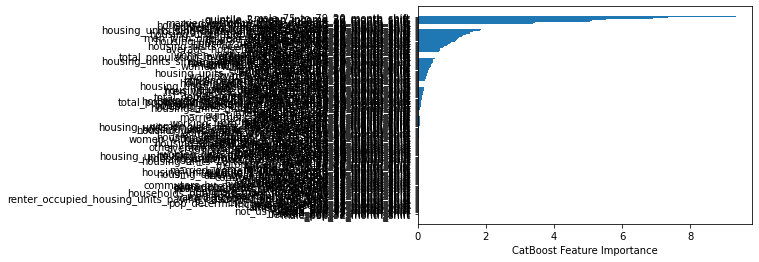

In [25]:

plt.Figure(figsize=[20,20])
plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")

### Catboost with filtered non-ACS features

In [81]:
## Set target and train-test date
target_name = 'zori_ssa'
train_test_date = datetime.datetime(2020,7,1) 

In [82]:
## load target and other variables
main_frame = pd.read_csv('cleaned_data/long_interpolated_target.csv', index_col=0, parse_dates=['Time'])
other_features = pd.read_csv('cleaned_data/merged_texas_data.csv', index_col=0, parse_dates=['Time'])

# get column names
all_cols = other_features.columns.to_list()
all_cols.remove('Time')
all_cols.remove('zip_code')

## Merge to target and shift all variables by a year
all_feats = helper.time_lag_merge(main_frame, other_features, {12:all_cols})

In [85]:
## Drop columns with NA
all_feats = all_feats.dropna()

In [86]:
### Code to check dates

# pct_cols = [
#     'mintempC', 'sales_tax_rate', 'total_sales_tax',
#     'tx_is_abt_same', 'tx_is_better', 'tx_is_worse',
#     'Single Family Building Permits TX',
#     'Gross Value Natural Gas Production', 
#     'sap_case_shiller_index', 'taxpayer_count', 
#     'taxpayer_cl_ratio', 'taxpayer_is_ratio',
#                 ]
# for pct_col in pct_cols:
#     print(pct_col)
#     date_min = pd.Timestamp(
#        other_features.loc[~other_features[pct_col].isna(),
#                                   'Time'].dt.date.min())
#     date_max = pd.Timestamp(
#         other_features.loc[~other_features[pct_col].isna(),
#                               'Time'].dt.date.max())
#     print(f'min_date {date_min}')
#     print(f'max_date {date_max}')

In [88]:
## Train will be before 12/1/2017, test is from 12/1/2020
merged_train = all_feats[all_feats['Time'] < train_test_date]
merged_test  = all_feats[all_feats['Time'] > train_test_date]
print(f'train: {merged_train.shape}')
print(f'test: {merged_test.shape}')

train: (14835, 28)
test: (2580, 28)


In [89]:
## Set features and target for test, train

y_train = merged_train[target_name]
y_test = merged_test[target_name]
X_test = merged_test.drop(columns=['zip_code', 'Time', target_name], axis=1)
X_train = merged_train.drop(columns=['zip_code', 'Time', target_name], axis=1)


In [90]:
### Run Catboost - non ACS data, no priors
# Testing performance
# RMSE: 301.1945119105622
# R2: -0.4181640471305377

train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

0:	learn: 1318.6581544	test: 1303.8111914	best: 1303.8111914 (0)	total: 3.12ms	remaining: 309ms
1:	learn: 1280.4219203	test: 1265.5558355	best: 1265.5558355 (1)	total: 5.73ms	remaining: 281ms
2:	learn: 1243.3540153	test: 1228.4699681	best: 1228.4699681 (2)	total: 8.55ms	remaining: 276ms
3:	learn: 1207.4045706	test: 1192.5588272	best: 1192.5588272 (3)	total: 11.5ms	remaining: 276ms
4:	learn: 1172.6235379	test: 1157.7775760	best: 1157.7775760 (4)	total: 13.5ms	remaining: 257ms
5:	learn: 1138.9292544	test: 1124.0816538	best: 1124.0816538 (5)	total: 16.2ms	remaining: 253ms
6:	learn: 1106.2266218	test: 1091.3806897	best: 1091.3806897 (6)	total: 18.7ms	remaining: 248ms
7:	learn: 1074.5521469	test: 1059.7159562	best: 1059.7159562 (7)	total: 21.6ms	remaining: 249ms
8:	learn: 1043.9182726	test: 1029.0836064	best: 1029.0836064 (8)	total: 24.2ms	remaining: 245ms
9:	learn: 1014.2609826	test: 999.4157541	best: 999.4157541 (9)	total: 27.4ms	remaining: 247ms
10:	learn: 985.5405942	test: 970.6916720	b

68:	learn: 199.1814873	test: 209.3048325	best: 208.4452347 (55)	total: 120ms	remaining: 53.8ms
69:	learn: 199.1499685	test: 209.2564532	best: 208.4452347 (55)	total: 123ms	remaining: 52.6ms
70:	learn: 199.0217120	test: 209.0517642	best: 208.4452347 (55)	total: 125ms	remaining: 51ms
71:	learn: 198.9135686	test: 209.0876591	best: 208.4452347 (55)	total: 127ms	remaining: 49.6ms
72:	learn: 198.8215751	test: 209.0896795	best: 208.4452347 (55)	total: 130ms	remaining: 48.1ms
73:	learn: 198.7146862	test: 209.1404741	best: 208.4452347 (55)	total: 133ms	remaining: 46.7ms
74:	learn: 198.6396049	test: 209.2400641	best: 208.4452347 (55)	total: 135ms	remaining: 45ms
75:	learn: 198.5572775	test: 209.4489626	best: 208.4452347 (55)	total: 138ms	remaining: 43.4ms
76:	learn: 198.3970025	test: 209.1784709	best: 208.4452347 (55)	total: 140ms	remaining: 41.8ms
77:	learn: 198.2703299	test: 209.1599796	best: 208.4452347 (55)	total: 143ms	remaining: 40.2ms
78:	learn: 198.1584477	test: 209.2321511	best: 208.445

49:	learn: 201.5069476	test: 210.4861781	best: 209.7098856 (22)	total: 88.4ms	remaining: 88.4ms
50:	learn: 201.3912300	test: 210.3823391	best: 209.7098856 (22)	total: 90.8ms	remaining: 87.3ms
51:	learn: 201.3089518	test: 210.4194637	best: 209.7098856 (22)	total: 93.6ms	remaining: 86.4ms
52:	learn: 201.2134276	test: 210.3011500	best: 209.7098856 (22)	total: 96.2ms	remaining: 85.3ms
53:	learn: 201.0177255	test: 210.3985289	best: 209.7098856 (22)	total: 99ms	remaining: 84.3ms
54:	learn: 200.8551908	test: 210.1906205	best: 209.7098856 (22)	total: 102ms	remaining: 83.3ms
55:	learn: 200.7802796	test: 210.0510516	best: 209.7098856 (22)	total: 105ms	remaining: 82.2ms
56:	learn: 200.7119942	test: 209.9277881	best: 209.7098856 (22)	total: 107ms	remaining: 81ms
57:	learn: 200.6670362	test: 209.8704160	best: 209.7098856 (22)	total: 110ms	remaining: 79.6ms
58:	learn: 200.5308031	test: 210.0565586	best: 209.7098856 (22)	total: 113ms	remaining: 78.3ms
59:	learn: 200.3547600	test: 209.7249025	best: 20

42:	learn: 429.8398392	test: 415.8887568	best: 415.8887568 (42)	total: 79.2ms	remaining: 105ms
43:	learn: 420.7453638	test: 406.8555100	best: 406.8555100 (43)	total: 82.5ms	remaining: 105ms
44:	learn: 411.9722511	test: 398.1598987	best: 398.1598987 (44)	total: 85ms	remaining: 104ms
45:	learn: 403.5360188	test: 389.8246595	best: 389.8246595 (45)	total: 87.7ms	remaining: 103ms
46:	learn: 395.3941467	test: 381.7987586	best: 381.7987586 (46)	total: 90.5ms	remaining: 102ms
47:	learn: 387.6444436	test: 374.1193972	best: 374.1193972 (47)	total: 92.7ms	remaining: 100ms
48:	learn: 380.1040236	test: 366.6910106	best: 366.6910106 (48)	total: 95.6ms	remaining: 99.5ms
49:	learn: 372.8361414	test: 359.5410214	best: 359.5410214 (49)	total: 98ms	remaining: 98ms
50:	learn: 365.9551364	test: 352.7403118	best: 352.7403118 (50)	total: 101ms	remaining: 97ms
51:	learn: 359.4277453	test: 346.3055194	best: 346.3055194 (51)	total: 103ms	remaining: 95.4ms
52:	learn: 353.0366888	test: 340.0344091	best: 340.03440

41:	learn: 202.9320560	test: 209.6377086	best: 209.2182855 (28)	total: 73.4ms	remaining: 101ms
42:	learn: 202.7851598	test: 209.4348763	best: 209.2182855 (28)	total: 76.1ms	remaining: 101ms
43:	learn: 202.5935576	test: 209.3344559	best: 209.2182855 (28)	total: 78.5ms	remaining: 99.9ms
44:	learn: 202.4047711	test: 208.8746764	best: 208.8746764 (44)	total: 80.8ms	remaining: 98.8ms
45:	learn: 202.2499861	test: 208.9941033	best: 208.8746764 (44)	total: 83.5ms	remaining: 98ms
46:	learn: 201.8518263	test: 208.3803507	best: 208.3803507 (46)	total: 86.1ms	remaining: 97.1ms
47:	learn: 201.7514306	test: 208.4003514	best: 208.3803507 (46)	total: 88.8ms	remaining: 96.2ms
48:	learn: 201.6809129	test: 208.3548902	best: 208.3548902 (48)	total: 91.6ms	remaining: 95.3ms
49:	learn: 201.6013666	test: 208.2938771	best: 208.2938771 (49)	total: 94.2ms	remaining: 94.2ms
50:	learn: 201.4621855	test: 208.3448700	best: 208.2938771 (49)	total: 97.3ms	remaining: 93.5ms
51:	learn: 201.3261122	test: 208.1636918	bes

78:	learn: 257.8109387	test: 248.5325714	best: 248.5325714 (78)	total: 226ms	remaining: 60.1ms
79:	learn: 256.0456544	test: 246.9017220	best: 246.9017220 (79)	total: 229ms	remaining: 57.2ms
80:	learn: 253.9950398	test: 244.9589200	best: 244.9589200 (80)	total: 232ms	remaining: 54.4ms
81:	learn: 252.3433930	test: 243.4736555	best: 243.4736555 (81)	total: 235ms	remaining: 51.6ms
82:	learn: 250.7131629	test: 241.9981269	best: 241.9981269 (82)	total: 238ms	remaining: 48.7ms
83:	learn: 249.3579252	test: 240.7733918	best: 240.7733918 (83)	total: 240ms	remaining: 45.8ms
84:	learn: 247.6439395	test: 239.1645346	best: 239.1645346 (84)	total: 243ms	remaining: 42.9ms
85:	learn: 246.0414924	test: 237.6734659	best: 237.6734659 (85)	total: 246ms	remaining: 40ms
86:	learn: 244.6955183	test: 236.4827062	best: 236.4827062 (86)	total: 249ms	remaining: 37.2ms
87:	learn: 243.2546635	test: 235.1627314	best: 235.1627314 (87)	total: 251ms	remaining: 34.2ms
88:	learn: 242.0860801	test: 234.1399349	best: 234.1

50:	learn: 365.8515965	test: 352.6502063	best: 352.6502063 (50)	total: 86ms	remaining: 167ms
51:	learn: 359.3262342	test: 346.2176586	best: 346.2176586 (51)	total: 88.6ms	remaining: 167ms
52:	learn: 352.9366422	test: 339.9481762	best: 339.9481762 (52)	total: 91ms	remaining: 167ms
53:	learn: 346.9511840	test: 334.0656989	best: 334.0656989 (53)	total: 93.8ms	remaining: 167ms
54:	learn: 341.2301074	test: 328.4467285	best: 328.4467285 (54)	total: 96.8ms	remaining: 167ms
55:	learn: 335.7408226	test: 323.0525582	best: 323.0525582 (55)	total: 99.7ms	remaining: 167ms
56:	learn: 330.2304555	test: 317.7165907	best: 317.7165907 (56)	total: 103ms	remaining: 168ms
57:	learn: 325.0766360	test: 312.7048503	best: 312.7048503 (57)	total: 105ms	remaining: 167ms
58:	learn: 320.1947638	test: 307.9552918	best: 307.9552918 (58)	total: 108ms	remaining: 166ms
59:	learn: 315.4935842	test: 303.4026940	best: 303.4026940 (59)	total: 110ms	remaining: 166ms
60:	learn: 311.0564500	test: 299.0796586	best: 299.0796586

144:	learn: 218.0133412	test: 214.7088606	best: 214.7088606 (144)	total: 277ms	remaining: 9.55ms
145:	learn: 217.8970872	test: 214.6366654	best: 214.6366654 (145)	total: 280ms	remaining: 7.68ms
146:	learn: 217.7858458	test: 214.5695831	best: 214.5695831 (146)	total: 282ms	remaining: 5.76ms
147:	learn: 217.6328600	test: 214.5319822	best: 214.5319822 (147)	total: 285ms	remaining: 3.85ms
148:	learn: 217.4922230	test: 214.4919381	best: 214.4919381 (148)	total: 287ms	remaining: 1.93ms
149:	learn: 217.3914781	test: 214.4295222	best: 214.4295222 (149)	total: 290ms	remaining: 0us

bestTest = 214.4295222
bestIteration = 149

8:	loss: 214.4295222	best: 207.6283415 (5)	total: 2.25s	remaining: 21.8s
0:	learn: 234.8319797	test: 231.5447971	best: 231.5447971 (0)	total: 3.02ms	remaining: 450ms
1:	learn: 222.4286651	test: 220.1650908	best: 220.1650908 (1)	total: 5.68ms	remaining: 420ms
2:	learn: 218.7332999	test: 218.0668822	best: 218.0668822 (2)	total: 8.26ms	remaining: 405ms
3:	learn: 216.3127262	te

137:	learn: 193.3602745	test: 209.0950182	best: 208.4452347 (55)	total: 367ms	remaining: 31.9ms
138:	learn: 193.3160453	test: 209.1773703	best: 208.4452347 (55)	total: 371ms	remaining: 29.4ms
139:	learn: 193.2708799	test: 209.2183351	best: 208.4452347 (55)	total: 375ms	remaining: 26.8ms
140:	learn: 193.1973985	test: 209.1747173	best: 208.4452347 (55)	total: 378ms	remaining: 24.1ms
141:	learn: 193.1478208	test: 209.2485913	best: 208.4452347 (55)	total: 382ms	remaining: 21.5ms
142:	learn: 193.0907595	test: 209.1552404	best: 208.4452347 (55)	total: 385ms	remaining: 18.8ms
143:	learn: 193.0812627	test: 209.1550292	best: 208.4452347 (55)	total: 388ms	remaining: 16.2ms
144:	learn: 193.0230291	test: 209.2384293	best: 208.4452347 (55)	total: 391ms	remaining: 13.5ms
145:	learn: 192.9727498	test: 209.2814985	best: 208.4452347 (55)	total: 394ms	remaining: 10.8ms
146:	learn: 192.9162896	test: 209.3241929	best: 208.4452347 (55)	total: 398ms	remaining: 8.11ms
147:	learn: 192.8389224	test: 209.404581

108:	learn: 226.7900267	test: 221.0242072	best: 221.0242072 (108)	total: 345ms	remaining: 130ms
109:	learn: 226.3834637	test: 220.6935359	best: 220.6935359 (109)	total: 349ms	remaining: 127ms
110:	learn: 225.9515137	test: 220.3707574	best: 220.3707574 (110)	total: 352ms	remaining: 124ms
111:	learn: 225.5599085	test: 220.0979977	best: 220.0979977 (111)	total: 355ms	remaining: 121ms
112:	learn: 225.1923976	test: 219.8241592	best: 219.8241592 (112)	total: 358ms	remaining: 117ms
113:	learn: 224.7127097	test: 219.4085942	best: 219.4085942 (113)	total: 361ms	remaining: 114ms
114:	learn: 224.4054192	test: 219.1719395	best: 219.1719395 (114)	total: 364ms	remaining: 111ms
115:	learn: 223.9201760	test: 218.7414142	best: 218.7414142 (115)	total: 367ms	remaining: 108ms
116:	learn: 223.5802259	test: 218.5145843	best: 218.5145843 (116)	total: 370ms	remaining: 104ms
117:	learn: 223.3112935	test: 218.3320632	best: 218.3320632 (117)	total: 374ms	remaining: 101ms
118:	learn: 223.0203128	test: 218.144361

122:	learn: 194.7379154	test: 210.4614983	best: 208.2269872 (75)	total: 254ms	remaining: 55.8ms
123:	learn: 194.7039714	test: 210.3932779	best: 208.2269872 (75)	total: 258ms	remaining: 54ms
124:	learn: 194.5936415	test: 210.3010258	best: 208.2269872 (75)	total: 261ms	remaining: 52.2ms
125:	learn: 194.5225796	test: 210.3427436	best: 208.2269872 (75)	total: 263ms	remaining: 50.1ms
126:	learn: 194.4579259	test: 210.3220885	best: 208.2269872 (75)	total: 266ms	remaining: 48.2ms
127:	learn: 194.4405801	test: 210.2821482	best: 208.2269872 (75)	total: 268ms	remaining: 46.1ms
128:	learn: 194.3957697	test: 210.1143527	best: 208.2269872 (75)	total: 271ms	remaining: 44.1ms
129:	learn: 194.3448780	test: 210.0555632	best: 208.2269872 (75)	total: 274ms	remaining: 42.1ms
130:	learn: 194.2031452	test: 209.9216273	best: 208.2269872 (75)	total: 277ms	remaining: 40.1ms
131:	learn: 194.1059907	test: 209.9284058	best: 208.2269872 (75)	total: 279ms	remaining: 38.1ms
132:	learn: 194.0549584	test: 209.8503173	

65:	learn: 291.6933848	test: 280.4502213	best: 280.4502213 (65)	total: 118ms	remaining: 150ms
66:	learn: 288.3577395	test: 277.2641278	best: 277.2641278 (66)	total: 121ms	remaining: 150ms
67:	learn: 285.1505756	test: 274.2053452	best: 274.2053452 (67)	total: 124ms	remaining: 149ms
68:	learn: 282.1474743	test: 271.3509191	best: 271.3509191 (68)	total: 126ms	remaining: 148ms
69:	learn: 279.2185431	test: 268.5789975	best: 268.5789975 (69)	total: 129ms	remaining: 148ms
70:	learn: 276.0824094	test: 265.5534395	best: 265.5534395 (70)	total: 132ms	remaining: 147ms
71:	learn: 273.4294426	test: 263.0567522	best: 263.0567522 (71)	total: 134ms	remaining: 146ms
72:	learn: 270.9162857	test: 260.7304392	best: 260.7304392 (72)	total: 137ms	remaining: 145ms
73:	learn: 268.1745512	test: 258.1034851	best: 258.1034851 (73)	total: 140ms	remaining: 143ms
74:	learn: 265.9865523	test: 256.0539869	best: 256.0539869 (74)	total: 142ms	remaining: 142ms
75:	learn: 263.7874510	test: 253.9926399	best: 253.9926399 (

9:	learn: 211.0200151	test: 211.3675797	best: 211.3675797 (9)	total: 19ms	remaining: 266ms
10:	learn: 210.4318209	test: 211.6673177	best: 211.3675797 (9)	total: 21.5ms	remaining: 271ms
11:	learn: 209.9828069	test: 211.5060898	best: 211.3675797 (9)	total: 24.2ms	remaining: 279ms
12:	learn: 209.7511376	test: 211.6472710	best: 211.3675797 (9)	total: 26.8ms	remaining: 283ms
13:	learn: 209.1785351	test: 211.2776287	best: 211.2776287 (13)	total: 29.2ms	remaining: 284ms
14:	learn: 208.8574672	test: 211.1457116	best: 211.1457116 (14)	total: 32.2ms	remaining: 290ms
15:	learn: 208.5711306	test: 211.3915665	best: 211.1457116 (14)	total: 35.2ms	remaining: 295ms
16:	learn: 208.1617378	test: 211.0885483	best: 211.0885483 (16)	total: 38.1ms	remaining: 298ms
17:	learn: 207.7629537	test: 211.1052451	best: 211.0885483 (16)	total: 41.2ms	remaining: 302ms
18:	learn: 207.5705264	test: 210.8508203	best: 210.8508203 (18)	total: 43.8ms	remaining: 302ms
19:	learn: 207.4068197	test: 211.0721687	best: 210.850820

104:	learn: 196.3655159	test: 209.1579519	best: 207.6283415 (65)	total: 207ms	remaining: 88.5ms
105:	learn: 196.3495698	test: 209.1372682	best: 207.6283415 (65)	total: 209ms	remaining: 86.9ms
106:	learn: 196.3095958	test: 209.1628029	best: 207.6283415 (65)	total: 212ms	remaining: 85.2ms
107:	learn: 196.1887199	test: 208.8936229	best: 207.6283415 (65)	total: 215ms	remaining: 83.4ms
108:	learn: 196.1264563	test: 208.9100817	best: 207.6283415 (65)	total: 218ms	remaining: 81.8ms
109:	learn: 196.0759076	test: 208.8667010	best: 207.6283415 (65)	total: 220ms	remaining: 80ms
110:	learn: 196.0214843	test: 208.7764302	best: 207.6283415 (65)	total: 223ms	remaining: 78.3ms
111:	learn: 195.9601461	test: 208.6159283	best: 207.6283415 (65)	total: 225ms	remaining: 76.5ms
112:	learn: 195.9273569	test: 208.6419165	best: 207.6283415 (65)	total: 228ms	remaining: 74.8ms
113:	learn: 195.8788147	test: 208.5398020	best: 207.6283415 (65)	total: 231ms	remaining: 72.9ms
114:	learn: 195.8172402	test: 208.6297442	

54:	learn: 341.5557428	test: 328.7359289	best: 328.7359289 (54)	total: 93.8ms	remaining: 162ms
55:	learn: 335.8778055	test: 323.1986462	best: 323.1986462 (55)	total: 97ms	remaining: 163ms
56:	learn: 330.3675345	test: 317.8616357	best: 317.8616357 (56)	total: 99.5ms	remaining: 162ms
57:	learn: 325.2058689	test: 312.8414163	best: 312.8414163 (57)	total: 102ms	remaining: 162ms
58:	learn: 320.3209525	test: 308.0877039	best: 308.0877039 (58)	total: 105ms	remaining: 162ms
59:	learn: 315.6109189	test: 303.5253395	best: 303.5253395 (59)	total: 108ms	remaining: 162ms
60:	learn: 311.1642246	test: 299.1922767	best: 299.1922767 (60)	total: 111ms	remaining: 162ms
61:	learn: 306.9657831	test: 295.1060064	best: 295.1060064 (61)	total: 114ms	remaining: 161ms
62:	learn: 302.9274448	test: 291.2179504	best: 291.2179504 (62)	total: 116ms	remaining: 160ms
63:	learn: 299.0063880	test: 287.4601590	best: 287.4601590 (63)	total: 119ms	remaining: 159ms
64:	learn: 295.2766311	test: 283.8876544	best: 283.8876544 

147:	learn: 217.8754453	test: 214.6614492	best: 214.6614492 (147)	total: 285ms	remaining: 3.85ms
148:	learn: 217.7356520	test: 214.6202808	best: 214.6202808 (148)	total: 288ms	remaining: 1.94ms
149:	learn: 217.6361090	test: 214.5589604	best: 214.5589604 (149)	total: 291ms	remaining: 0us

bestTest = 214.5589604
bestIteration = 149

14:	loss: 214.5589604	best: 207.3012956 (13)	total: 4.47s	remaining: 24.1s
0:	learn: 234.8362163	test: 231.5001176	best: 231.5001176 (0)	total: 2.96ms	remaining: 442ms
1:	learn: 222.4303582	test: 220.1855319	best: 220.1855319 (1)	total: 5.85ms	remaining: 433ms
2:	learn: 218.7347652	test: 218.0780933	best: 218.0780933 (2)	total: 8.88ms	remaining: 435ms
3:	learn: 216.3047284	test: 215.8282838	best: 215.8282838 (3)	total: 12.4ms	remaining: 451ms
4:	learn: 214.9020803	test: 214.2460947	best: 214.2460947 (4)	total: 17.7ms	remaining: 513ms
5:	learn: 213.7556022	test: 213.9377237	best: 213.9377237 (5)	total: 21.2ms	remaining: 508ms
6:	learn: 212.4583384	test: 212.74

8:	learn: 1043.9182726	test: 1029.0836064	best: 1029.0836064 (8)	total: 37.4ms	remaining: 378ms
9:	learn: 1014.2609826	test: 999.4157541	best: 999.4157541 (9)	total: 40.4ms	remaining: 364ms
10:	learn: 985.5405942	test: 970.6916720	best: 970.6916720 (10)	total: 43.8ms	remaining: 354ms
11:	learn: 957.7167073	test: 942.8603640	best: 942.8603640 (11)	total: 47.1ms	remaining: 346ms
12:	learn: 930.7747035	test: 915.9201980	best: 915.9201980 (12)	total: 50.2ms	remaining: 336ms
13:	learn: 904.6218104	test: 889.8054721	best: 889.8054721 (13)	total: 53.1ms	remaining: 326ms
14:	learn: 879.3439697	test: 864.5566093	best: 864.5566093 (14)	total: 57.2ms	remaining: 324ms
15:	learn: 854.9050817	test: 840.1469112	best: 840.1469112 (15)	total: 61.9ms	remaining: 325ms
16:	learn: 831.0552850	test: 816.2842954	best: 816.2842954 (16)	total: 66.1ms	remaining: 323ms
17:	learn: 808.1123839	test: 793.3348305	best: 793.3348305 (17)	total: 69.8ms	remaining: 318ms
18:	learn: 785.9445309	test: 771.2031256	best: 771

14:	learn: 208.5170659	test: 210.5196028	best: 210.5196028 (14)	total: 44.5ms	remaining: 252ms
15:	learn: 208.0118988	test: 210.2169491	best: 210.2169491 (15)	total: 47.4ms	remaining: 249ms
16:	learn: 207.6879612	test: 210.2475071	best: 210.2169491 (15)	total: 50.2ms	remaining: 245ms
17:	learn: 207.4235572	test: 210.4431270	best: 210.2169491 (15)	total: 53.6ms	remaining: 244ms
18:	learn: 207.2194301	test: 210.4768044	best: 210.2169491 (15)	total: 57.3ms	remaining: 244ms
19:	learn: 207.0521219	test: 210.3630408	best: 210.2169491 (15)	total: 59.8ms	remaining: 239ms
20:	learn: 206.9277805	test: 210.3641795	best: 210.2169491 (15)	total: 62.6ms	remaining: 236ms
21:	learn: 206.7444533	test: 210.5277143	best: 210.2169491 (15)	total: 65.4ms	remaining: 232ms
22:	learn: 206.6219714	test: 210.4581759	best: 210.2169491 (15)	total: 68.4ms	remaining: 229ms
23:	learn: 206.4707733	test: 210.8236135	best: 210.2169491 (15)	total: 71.2ms	remaining: 226ms
24:	learn: 206.2659067	test: 210.5466538	best: 210

44:	learn: 411.9018863	test: 398.0965944	best: 398.0965944 (44)	total: 127ms	remaining: 155ms
45:	learn: 403.4670981	test: 389.7629258	best: 389.7629258 (45)	total: 131ms	remaining: 153ms
46:	learn: 395.3263389	test: 381.7380462	best: 381.7380462 (46)	total: 133ms	remaining: 151ms
47:	learn: 387.5774958	test: 374.0596385	best: 374.0596385 (47)	total: 136ms	remaining: 148ms
48:	learn: 380.0378061	test: 366.6321898	best: 366.6321898 (48)	total: 139ms	remaining: 145ms
49:	learn: 372.7710459	test: 359.4834035	best: 359.4834035 (49)	total: 142ms	remaining: 142ms
50:	learn: 365.8912254	test: 352.6839835	best: 352.6839835 (50)	total: 146ms	remaining: 140ms
51:	learn: 359.3651057	test: 346.2505880	best: 346.2505880 (51)	total: 148ms	remaining: 137ms
52:	learn: 352.9749666	test: 339.9804889	best: 339.9804889 (52)	total: 152ms	remaining: 135ms
53:	learn: 346.9889940	test: 334.0973472	best: 334.0973472 (53)	total: 155ms	remaining: 132ms
54:	learn: 341.2672787	test: 328.4776612	best: 328.4776612 (

75:	learn: 198.5404695	test: 208.2269872	best: 208.2269872 (75)	total: 219ms	remaining: 69ms
76:	learn: 198.4277445	test: 208.2747914	best: 208.2269872 (75)	total: 221ms	remaining: 66ms
77:	learn: 198.3265139	test: 208.3456429	best: 208.2269872 (75)	total: 224ms	remaining: 63.3ms
78:	learn: 198.2316543	test: 208.2422745	best: 208.2269872 (75)	total: 228ms	remaining: 60.6ms
79:	learn: 198.1347362	test: 208.4341200	best: 208.2269872 (75)	total: 231ms	remaining: 57.7ms
80:	learn: 197.9493095	test: 208.5508191	best: 208.2269872 (75)	total: 234ms	remaining: 54.8ms
81:	learn: 197.8760653	test: 208.5680466	best: 208.2269872 (75)	total: 236ms	remaining: 51.9ms
82:	learn: 197.8203230	test: 208.6097981	best: 208.2269872 (75)	total: 239ms	remaining: 49ms
83:	learn: 197.7641919	test: 208.6579799	best: 208.2269872 (75)	total: 242ms	remaining: 46.1ms
84:	learn: 197.6781768	test: 208.4560437	best: 208.2269872 (75)	total: 245ms	remaining: 43.3ms
85:	learn: 197.6609223	test: 208.4726179	best: 208.22698

7:	learn: 212.1745528	test: 212.5059030	best: 212.4910447 (6)	total: 21.8ms	remaining: 251ms
8:	learn: 211.5835876	test: 212.1989815	best: 212.1989815 (8)	total: 25.2ms	remaining: 255ms
9:	learn: 211.0200151	test: 211.3675797	best: 211.3675797 (9)	total: 28.2ms	remaining: 254ms
10:	learn: 210.4318209	test: 211.6673177	best: 211.3675797 (9)	total: 31.8ms	remaining: 257ms
11:	learn: 209.9828069	test: 211.5060898	best: 211.3675797 (9)	total: 34.7ms	remaining: 254ms
12:	learn: 209.7511376	test: 211.6472710	best: 211.3675797 (9)	total: 37.2ms	remaining: 249ms
13:	learn: 209.1785351	test: 211.2776287	best: 211.2776287 (13)	total: 39.9ms	remaining: 245ms
14:	learn: 208.8574672	test: 211.1457116	best: 211.1457116 (14)	total: 43.5ms	remaining: 247ms
15:	learn: 208.5711306	test: 211.3915665	best: 211.1457116 (14)	total: 46.4ms	remaining: 244ms
16:	learn: 208.1617378	test: 211.0885483	best: 211.0885483 (16)	total: 49ms	remaining: 239ms
17:	learn: 207.7629537	test: 211.1052451	best: 211.0885483 (1

37:	learn: 481.2935933	test: 467.0537645	best: 467.0537645 (37)	total: 100ms	remaining: 164ms
38:	learn: 470.2709413	test: 456.0954220	best: 456.0954220 (38)	total: 104ms	remaining: 163ms
39:	learn: 459.6508739	test: 445.5187447	best: 445.5187447 (39)	total: 107ms	remaining: 161ms
40:	learn: 449.4394175	test: 435.3583404	best: 435.3583404 (40)	total: 110ms	remaining: 159ms
41:	learn: 439.6125460	test: 425.5715259	best: 425.5715259 (41)	total: 114ms	remaining: 157ms
42:	learn: 430.1229724	test: 416.1539427	best: 416.1539427 (42)	total: 117ms	remaining: 155ms
43:	learn: 421.0222038	test: 407.1140114	best: 407.1140114 (43)	total: 120ms	remaining: 152ms
44:	learn: 412.2434947	test: 398.4124801	best: 398.4124801 (44)	total: 122ms	remaining: 149ms
45:	learn: 403.8014628	test: 390.0710717	best: 390.0710717 (45)	total: 125ms	remaining: 147ms
46:	learn: 395.6548124	test: 382.0407711	best: 382.0407711 (46)	total: 128ms	remaining: 144ms
47:	learn: 387.9017115	test: 374.3577372	best: 374.3577372 (

59:	learn: 201.1268343	test: 210.0721667	best: 209.7327187 (43)	total: 202ms	remaining: 135ms
60:	learn: 200.8697366	test: 209.2527152	best: 209.2527152 (60)	total: 206ms	remaining: 132ms
61:	learn: 200.6483088	test: 209.7012831	best: 209.2527152 (60)	total: 210ms	remaining: 129ms
62:	learn: 200.6200820	test: 209.7008754	best: 209.2527152 (60)	total: 213ms	remaining: 125ms
63:	learn: 200.4925885	test: 209.5954610	best: 209.2527152 (60)	total: 216ms	remaining: 122ms
64:	learn: 200.2940377	test: 209.6320355	best: 209.2527152 (60)	total: 219ms	remaining: 118ms
65:	learn: 199.9232619	test: 209.3030793	best: 209.2527152 (60)	total: 223ms	remaining: 115ms
66:	learn: 199.7267655	test: 209.1470546	best: 209.1470546 (66)	total: 226ms	remaining: 111ms
67:	learn: 199.6321165	test: 209.0456798	best: 209.0456798 (67)	total: 229ms	remaining: 108ms
68:	learn: 199.5680190	test: 208.9486277	best: 208.9486277 (68)	total: 232ms	remaining: 104ms
69:	learn: 199.4635376	test: 208.8902896	best: 208.8902896 (

74:	learn: 260.9666692	test: 251.3127466	best: 251.3127466 (74)	total: 266ms	remaining: 88.8ms
75:	learn: 258.6980180	test: 249.2125869	best: 249.2125869 (75)	total: 270ms	remaining: 85.4ms
76:	learn: 256.5143740	test: 247.3181801	best: 247.3181801 (76)	total: 274ms	remaining: 81.8ms
77:	learn: 254.5093508	test: 245.4662508	best: 245.4662508 (77)	total: 278ms	remaining: 78.5ms
78:	learn: 252.3758298	test: 243.4532882	best: 243.4532882 (78)	total: 283ms	remaining: 75.1ms
79:	learn: 250.5647399	test: 241.7898866	best: 241.7898866 (79)	total: 287ms	remaining: 71.8ms
80:	learn: 248.5452948	test: 239.9055923	best: 239.9055923 (80)	total: 291ms	remaining: 68.3ms
81:	learn: 246.8147114	test: 238.3324004	best: 238.3324004 (81)	total: 296ms	remaining: 65ms
82:	learn: 245.2313683	test: 236.9162226	best: 236.9162226 (82)	total: 301ms	remaining: 61.6ms
83:	learn: 243.5478817	test: 235.3427348	best: 235.3427348 (83)	total: 305ms	remaining: 58.1ms
84:	learn: 242.1702647	test: 234.1054549	best: 234.1

77:	learn: 180.1430688	test: 211.1781093	best: 203.7611871 (19)	total: 284ms	remaining: 80.2ms
78:	learn: 179.9276182	test: 211.4036871	best: 203.7611871 (19)	total: 289ms	remaining: 76.9ms
79:	learn: 179.7469789	test: 211.2994909	best: 203.7611871 (19)	total: 293ms	remaining: 73.2ms
80:	learn: 179.6085959	test: 211.2087011	best: 203.7611871 (19)	total: 297ms	remaining: 69.7ms
81:	learn: 179.3286900	test: 211.1622372	best: 203.7611871 (19)	total: 301ms	remaining: 66.1ms
82:	learn: 179.0974779	test: 211.3614069	best: 203.7611871 (19)	total: 306ms	remaining: 62.6ms
83:	learn: 178.8851637	test: 211.6002767	best: 203.7611871 (19)	total: 310ms	remaining: 59ms
84:	learn: 178.7545016	test: 211.7397321	best: 203.7611871 (19)	total: 314ms	remaining: 55.4ms
85:	learn: 178.4504736	test: 211.6996703	best: 203.7611871 (19)	total: 318ms	remaining: 51.8ms
86:	learn: 178.2369690	test: 211.9692104	best: 203.7611871 (19)	total: 323ms	remaining: 48.3ms
87:	learn: 177.8739026	test: 211.8826367	best: 203.7

75:	learn: 258.7678683	test: 249.2209032	best: 249.2209032 (75)	total: 297ms	remaining: 93.6ms
76:	learn: 256.5835440	test: 247.3245065	best: 247.3245065 (76)	total: 300ms	remaining: 89.6ms
77:	learn: 254.5757718	test: 245.4696390	best: 245.4696390 (77)	total: 305ms	remaining: 85.9ms
78:	learn: 252.4409904	test: 243.4552642	best: 243.4552642 (78)	total: 308ms	remaining: 81.8ms
79:	learn: 250.6270204	test: 241.7890718	best: 241.7890718 (79)	total: 313ms	remaining: 78.3ms
80:	learn: 248.6052993	test: 239.9023356	best: 239.9023356 (80)	total: 319ms	remaining: 74.7ms
81:	learn: 246.8739111	test: 238.3282506	best: 238.3282506 (81)	total: 323ms	remaining: 70.8ms
82:	learn: 245.2551378	test: 236.8655207	best: 236.8655207 (82)	total: 327ms	remaining: 66.9ms
83:	learn: 243.5724277	test: 235.2939916	best: 235.2939916 (83)	total: 332ms	remaining: 63.2ms
84:	learn: 242.1919772	test: 234.0539782	best: 234.0539782 (84)	total: 336ms	remaining: 59.4ms
85:	learn: 240.6587136	test: 232.6615268	best: 232

78:	learn: 180.8943817	test: 212.5991861	best: 204.7758468 (22)	total: 293ms	remaining: 77.8ms
79:	learn: 180.7562418	test: 212.5692028	best: 204.7758468 (22)	total: 296ms	remaining: 74ms
80:	learn: 180.5259604	test: 212.7817481	best: 204.7758468 (22)	total: 301ms	remaining: 70.6ms
81:	learn: 180.3136884	test: 212.9058685	best: 204.7758468 (22)	total: 308ms	remaining: 67.6ms
82:	learn: 180.1323407	test: 212.8733604	best: 204.7758468 (22)	total: 311ms	remaining: 63.7ms
83:	learn: 179.9489130	test: 213.2863345	best: 204.7758468 (22)	total: 315ms	remaining: 60ms
84:	learn: 179.7613470	test: 213.3317956	best: 204.7758468 (22)	total: 319ms	remaining: 56.3ms
85:	learn: 179.5183551	test: 213.4069498	best: 204.7758468 (22)	total: 323ms	remaining: 52.6ms
86:	learn: 179.3197823	test: 213.7089033	best: 204.7758468 (22)	total: 327ms	remaining: 48.9ms
87:	learn: 179.0156822	test: 213.6141693	best: 204.7758468 (22)	total: 332ms	remaining: 45.3ms
88:	learn: 178.8783874	test: 213.4066535	best: 204.775

77:	learn: 254.7365362	test: 245.5777054	best: 245.5777054 (77)	total: 303ms	remaining: 85.5ms
78:	learn: 252.5980833	test: 243.5594557	best: 243.5594557 (78)	total: 307ms	remaining: 81.7ms
79:	learn: 250.7823622	test: 241.8913836	best: 241.8913836 (79)	total: 312ms	remaining: 77.9ms
80:	learn: 248.7584918	test: 240.0022005	best: 240.0022005 (80)	total: 315ms	remaining: 73.9ms
81:	learn: 247.0246112	test: 238.4257453	best: 238.4257453 (81)	total: 318ms	remaining: 69.9ms
82:	learn: 245.4433829	test: 237.0158381	best: 237.0158381 (82)	total: 323ms	remaining: 66.2ms
83:	learn: 243.7577159	test: 235.4413376	best: 235.4413376 (83)	total: 327ms	remaining: 62.3ms
84:	learn: 242.3754618	test: 234.1995604	best: 234.1995604 (84)	total: 331ms	remaining: 58.4ms
85:	learn: 240.8400367	test: 232.8047439	best: 232.8047439 (85)	total: 334ms	remaining: 54.4ms
86:	learn: 239.5011983	test: 231.6296535	best: 231.6296535 (86)	total: 338ms	remaining: 50.4ms
87:	learn: 238.2005187	test: 230.5557986	best: 230

81:	learn: 180.3268598	test: 207.2928973	best: 204.2476862 (14)	total: 307ms	remaining: 67.4ms
82:	learn: 180.2309528	test: 207.5492418	best: 204.2476862 (14)	total: 311ms	remaining: 63.7ms
83:	learn: 180.0110132	test: 207.4586837	best: 204.2476862 (14)	total: 315ms	remaining: 59.9ms
84:	learn: 179.7976198	test: 207.5665863	best: 204.2476862 (14)	total: 319ms	remaining: 56.2ms
85:	learn: 179.6379691	test: 207.7501388	best: 204.2476862 (14)	total: 322ms	remaining: 52.4ms
86:	learn: 179.4370644	test: 207.8611408	best: 204.2476862 (14)	total: 327ms	remaining: 48.8ms
87:	learn: 179.3333999	test: 207.9774324	best: 204.2476862 (14)	total: 331ms	remaining: 45.1ms
88:	learn: 179.2151995	test: 208.1362093	best: 204.2476862 (14)	total: 336ms	remaining: 41.6ms
89:	learn: 178.9186077	test: 208.3121172	best: 204.2476862 (14)	total: 340ms	remaining: 37.8ms
90:	learn: 178.6809648	test: 208.5130739	best: 204.2476862 (14)	total: 344ms	remaining: 34ms
91:	learn: 178.3946703	test: 208.5738960	best: 204.2

76:	learn: 257.2501326	test: 247.8829041	best: 247.8829041 (76)	total: 307ms	remaining: 91.8ms
77:	learn: 255.2290355	test: 246.0145854	best: 246.0145854 (77)	total: 312ms	remaining: 87.9ms
78:	learn: 253.0794087	test: 243.9846253	best: 243.9846253 (78)	total: 315ms	remaining: 83.8ms
79:	learn: 251.2535991	test: 242.3063336	best: 242.3063336 (79)	total: 319ms	remaining: 79.8ms
80:	learn: 249.2205860	test: 240.4076388	best: 240.4076388 (80)	total: 323ms	remaining: 75.8ms
81:	learn: 247.4778193	test: 238.8219919	best: 238.8219919 (81)	total: 326ms	remaining: 71.6ms
82:	learn: 245.8469926	test: 237.3474572	best: 237.3474572 (82)	total: 329ms	remaining: 67.5ms
83:	learn: 244.1515587	test: 235.7632133	best: 235.7632133 (83)	total: 333ms	remaining: 63.5ms
84:	learn: 242.7575608	test: 234.5096447	best: 234.5096447 (84)	total: 338ms	remaining: 59.6ms
85:	learn: 241.2138470	test: 233.1060790	best: 233.1060790 (85)	total: 341ms	remaining: 55.6ms
86:	learn: 239.8684887	test: 231.9242019	best: 231

16:	learn: 831.0302851	test: 816.2883733	best: 816.2883733 (16)	total: 43.6ms	remaining: 341ms
17:	learn: 808.0874457	test: 793.3582891	best: 793.3582891 (17)	total: 47.2ms	remaining: 346ms
18:	learn: 785.8701563	test: 771.1748650	best: 771.1748650 (18)	total: 50.3ms	remaining: 347ms
19:	learn: 764.3739909	test: 749.7011199	best: 749.7011199 (19)	total: 54.3ms	remaining: 353ms
20:	learn: 743.5850051	test: 728.9475892	best: 728.9475892 (20)	total: 58.8ms	remaining: 361ms
21:	learn: 723.4593105	test: 708.8737832	best: 708.8737832 (21)	total: 62.3ms	remaining: 363ms
22:	learn: 703.9929828	test: 689.4201672	best: 689.4201672 (22)	total: 65.7ms	remaining: 363ms
23:	learn: 685.2121917	test: 670.6592834	best: 670.6592834 (23)	total: 69.5ms	remaining: 365ms
24:	learn: 667.0446803	test: 652.5276698	best: 652.5276698 (24)	total: 74.8ms	remaining: 374ms
25:	learn: 649.4506535	test: 634.9688323	best: 634.9688323 (25)	total: 78.7ms	remaining: 375ms
26:	learn: 632.5177506	test: 618.0602738	best: 618

0:	learn: 234.4645124	test: 230.9642302	best: 230.9642302 (0)	total: 4.41ms	remaining: 656ms
1:	learn: 219.1229417	test: 216.1411760	best: 216.1411760 (1)	total: 7.79ms	remaining: 576ms
2:	learn: 213.3649882	test: 210.8638037	best: 210.8638037 (2)	total: 12.1ms	remaining: 594ms
3:	learn: 210.6875474	test: 207.4299889	best: 207.4299889 (3)	total: 15.4ms	remaining: 561ms
4:	learn: 208.8494472	test: 206.4052335	best: 206.4052335 (4)	total: 18.8ms	remaining: 546ms
5:	learn: 207.5955568	test: 206.3735176	best: 206.3735176 (5)	total: 22.2ms	remaining: 532ms
6:	learn: 207.2038946	test: 206.2069585	best: 206.2069585 (6)	total: 25.7ms	remaining: 524ms
7:	learn: 206.7551406	test: 206.1373841	best: 206.1373841 (7)	total: 29.4ms	remaining: 522ms
8:	learn: 205.2355398	test: 205.4940285	best: 205.4940285 (8)	total: 32.7ms	remaining: 513ms
9:	learn: 203.2512781	test: 205.4125912	best: 205.4125912 (9)	total: 37ms	remaining: 518ms
10:	learn: 202.5017467	test: 205.8868439	best: 205.4125912 (9)	total: 41

138:	learn: 168.0794058	test: 218.5490453	best: 203.7611871 (19)	total: 389ms	remaining: 30.8ms
139:	learn: 167.9714173	test: 218.4128861	best: 203.7611871 (19)	total: 393ms	remaining: 28.1ms
140:	learn: 167.7959893	test: 218.4451707	best: 203.7611871 (19)	total: 397ms	remaining: 25.4ms
141:	learn: 167.6560707	test: 218.3405362	best: 203.7611871 (19)	total: 402ms	remaining: 22.6ms
142:	learn: 167.4199951	test: 218.4138712	best: 203.7611871 (19)	total: 406ms	remaining: 19.9ms
143:	learn: 167.2246457	test: 218.2518292	best: 203.7611871 (19)	total: 410ms	remaining: 17.1ms
144:	learn: 167.0588988	test: 218.3441677	best: 203.7611871 (19)	total: 413ms	remaining: 14.3ms
145:	learn: 166.8940460	test: 218.5485804	best: 203.7611871 (19)	total: 417ms	remaining: 11.4ms
146:	learn: 166.7156446	test: 218.5514273	best: 203.7611871 (19)	total: 421ms	remaining: 8.59ms
147:	learn: 166.5497552	test: 218.5165083	best: 203.7611871 (19)	total: 426ms	remaining: 5.75ms
148:	learn: 166.3730339	test: 218.765509

79:	learn: 250.6270204	test: 241.7890718	best: 241.7890718 (79)	total: 353ms	remaining: 309ms
80:	learn: 248.6052993	test: 239.9023356	best: 239.9023356 (80)	total: 357ms	remaining: 304ms
81:	learn: 246.8739111	test: 238.3282506	best: 238.3282506 (81)	total: 362ms	remaining: 300ms
82:	learn: 245.2551378	test: 236.8655207	best: 236.8655207 (82)	total: 367ms	remaining: 296ms
83:	learn: 243.5724277	test: 235.2939916	best: 235.2939916 (83)	total: 372ms	remaining: 293ms
84:	learn: 242.1919772	test: 234.0539782	best: 234.0539782 (84)	total: 377ms	remaining: 288ms
85:	learn: 240.6587136	test: 232.6615268	best: 232.6615268 (85)	total: 384ms	remaining: 286ms
86:	learn: 239.3246694	test: 231.4904001	best: 231.4904001 (86)	total: 389ms	remaining: 282ms
87:	learn: 238.0238228	test: 230.4178886	best: 230.4178886 (87)	total: 392ms	remaining: 276ms
88:	learn: 236.8094760	test: 229.3689632	best: 229.3689632 (88)	total: 396ms	remaining: 271ms
89:	learn: 235.6357899	test: 228.3311887	best: 228.3311887 (

16:	learn: 200.7170139	test: 206.4778162	best: 205.6450129 (10)	total: 110ms	remaining: 861ms
17:	learn: 200.1020010	test: 207.1894885	best: 205.6450129 (10)	total: 117ms	remaining: 854ms
18:	learn: 199.3340637	test: 206.0724567	best: 205.6450129 (10)	total: 123ms	remaining: 846ms
19:	learn: 198.9002810	test: 205.6840392	best: 205.6450129 (10)	total: 129ms	remaining: 839ms
20:	learn: 198.4066992	test: 205.3076659	best: 205.3076659 (20)	total: 134ms	remaining: 821ms
21:	learn: 197.8820916	test: 204.8728098	best: 204.8728098 (21)	total: 139ms	remaining: 812ms
22:	learn: 197.6553230	test: 204.7758468	best: 204.7758468 (22)	total: 146ms	remaining: 806ms
23:	learn: 197.3652909	test: 205.4844987	best: 204.7758468 (22)	total: 150ms	remaining: 789ms
24:	learn: 197.0264905	test: 205.3370560	best: 204.7758468 (22)	total: 155ms	remaining: 773ms
25:	learn: 196.6572117	test: 205.9776128	best: 204.7758468 (22)	total: 159ms	remaining: 757ms
26:	learn: 196.1497354	test: 206.1014643	best: 204.7758468 (

13:	learn: 904.7287186	test: 889.9717659	best: 889.9717659 (13)	total: 43.6ms	remaining: 424ms
14:	learn: 879.4976524	test: 864.7304722	best: 864.7304722 (14)	total: 49.6ms	remaining: 447ms
15:	learn: 855.0576087	test: 840.3026030	best: 840.3026030 (15)	total: 54.2ms	remaining: 454ms
16:	learn: 831.3890979	test: 816.6446346	best: 816.6446346 (16)	total: 58.6ms	remaining: 459ms
17:	learn: 808.4491524	test: 793.7176666	best: 793.7176666 (17)	total: 63.8ms	remaining: 468ms
18:	learn: 786.2319891	test: 771.5316248	best: 771.5316248 (18)	total: 69.8ms	remaining: 481ms
19:	learn: 764.7401673	test: 750.0585530	best: 750.0585530 (19)	total: 74.6ms	remaining: 485ms
20:	learn: 743.9617044	test: 729.3195654	best: 729.3195654 (20)	total: 79.6ms	remaining: 489ms
21:	learn: 723.8435611	test: 709.2505347	best: 709.2505347 (21)	total: 86.2ms	remaining: 502ms
22:	learn: 704.3856968	test: 689.8064420	best: 689.8064420 (22)	total: 90.6ms	remaining: 500ms
23:	learn: 685.6116557	test: 671.0521573	best: 671

139:	learn: 212.9249045	test: 210.5986172	best: 210.5986172 (139)	total: 426ms	remaining: 30.4ms
140:	learn: 212.7874919	test: 210.5098177	best: 210.5098177 (140)	total: 430ms	remaining: 27.5ms
141:	learn: 212.6449513	test: 210.4215404	best: 210.4215404 (141)	total: 435ms	remaining: 24.5ms
142:	learn: 212.5460350	test: 210.3783401	best: 210.3783401 (142)	total: 440ms	remaining: 21.5ms
143:	learn: 212.2766496	test: 210.1442409	best: 210.1442409 (143)	total: 445ms	remaining: 18.5ms
144:	learn: 212.1024046	test: 210.0501762	best: 210.0501762 (144)	total: 448ms	remaining: 15.4ms
145:	learn: 211.9877462	test: 209.9675507	best: 209.9675507 (145)	total: 452ms	remaining: 12.4ms
146:	learn: 211.7995361	test: 209.8804400	best: 209.8804400 (146)	total: 458ms	remaining: 9.35ms
147:	learn: 211.6502366	test: 209.7602258	best: 209.7602258 (147)	total: 464ms	remaining: 6.28ms
148:	learn: 211.4799567	test: 209.6387201	best: 209.6387201 (148)	total: 469ms	remaining: 3.15ms
149:	learn: 211.3863095	test: 

122:	learn: 172.5627484	test: 212.7654656	best: 204.2476862 (14)	total: 327ms	remaining: 71.9ms
123:	learn: 172.4217759	test: 212.7495008	best: 204.2476862 (14)	total: 331ms	remaining: 69.5ms
124:	learn: 172.3108054	test: 212.6331411	best: 204.2476862 (14)	total: 334ms	remaining: 66.9ms
125:	learn: 172.0326349	test: 212.8427885	best: 204.2476862 (14)	total: 338ms	remaining: 64.4ms
126:	learn: 171.8792094	test: 212.7044443	best: 204.2476862 (14)	total: 342ms	remaining: 61.9ms
127:	learn: 171.6509898	test: 213.1361925	best: 204.2476862 (14)	total: 346ms	remaining: 59.4ms
128:	learn: 171.5713846	test: 213.3300745	best: 204.2476862 (14)	total: 350ms	remaining: 56.9ms
129:	learn: 171.4044877	test: 213.3890615	best: 204.2476862 (14)	total: 353ms	remaining: 54.3ms
130:	learn: 171.1714300	test: 213.5996575	best: 204.2476862 (14)	total: 357ms	remaining: 51.8ms
131:	learn: 171.0171497	test: 213.7338982	best: 204.2476862 (14)	total: 365ms	remaining: 49.7ms
132:	learn: 170.8573715	test: 213.625207

80:	learn: 249.2205860	test: 240.4076388	best: 240.4076388 (80)	total: 268ms	remaining: 228ms
81:	learn: 247.4778193	test: 238.8219919	best: 238.8219919 (81)	total: 273ms	remaining: 226ms
82:	learn: 245.8469926	test: 237.3474572	best: 237.3474572 (82)	total: 277ms	remaining: 224ms
83:	learn: 244.1515587	test: 235.7632133	best: 235.7632133 (83)	total: 281ms	remaining: 221ms
84:	learn: 242.7575608	test: 234.5096447	best: 234.5096447 (84)	total: 285ms	remaining: 218ms
85:	learn: 241.2138470	test: 233.1060790	best: 233.1060790 (85)	total: 289ms	remaining: 215ms
86:	learn: 239.8684887	test: 231.9242019	best: 231.9242019 (86)	total: 294ms	remaining: 213ms
87:	learn: 238.5599351	test: 230.7862420	best: 230.7862420 (87)	total: 298ms	remaining: 210ms
88:	learn: 237.3356199	test: 229.7277753	best: 229.7277753 (88)	total: 303ms	remaining: 208ms
89:	learn: 236.2613032	test: 228.7867608	best: 228.7867608 (89)	total: 307ms	remaining: 205ms
90:	learn: 235.0328659	test: 227.6662954	best: 227.6662954 (

68:	learn: 184.3660046	test: 205.4659081	best: 203.4497591 (38)	total: 176ms	remaining: 207ms
69:	learn: 183.9618750	test: 205.4571252	best: 203.4497591 (38)	total: 181ms	remaining: 206ms
70:	learn: 183.6886197	test: 205.6338363	best: 203.4497591 (38)	total: 184ms	remaining: 205ms
71:	learn: 183.5059453	test: 205.6454208	best: 203.4497591 (38)	total: 188ms	remaining: 204ms
72:	learn: 183.3406968	test: 206.0167396	best: 203.4497591 (38)	total: 192ms	remaining: 203ms
73:	learn: 183.0076826	test: 206.3210663	best: 203.4497591 (38)	total: 196ms	remaining: 201ms
74:	learn: 182.7496836	test: 206.5123335	best: 203.4497591 (38)	total: 200ms	remaining: 200ms
75:	learn: 182.5359385	test: 206.5600430	best: 203.4497591 (38)	total: 204ms	remaining: 198ms
76:	learn: 182.3081168	test: 206.7639827	best: 203.4497591 (38)	total: 209ms	remaining: 198ms
77:	learn: 182.0626675	test: 207.1405173	best: 203.4497591 (38)	total: 213ms	remaining: 196ms
78:	learn: 181.8724391	test: 207.1637939	best: 203.4497591 (

14:	learn: 879.1660074	test: 864.4015562	best: 864.4015562 (14)	total: 61.2ms	remaining: 347ms
15:	learn: 854.7071971	test: 839.9560599	best: 839.9560599 (15)	total: 65.6ms	remaining: 345ms
16:	learn: 831.0302851	test: 816.2883733	best: 816.2883733 (16)	total: 70.9ms	remaining: 346ms
17:	learn: 808.0874457	test: 793.3582891	best: 793.3582891 (17)	total: 76.1ms	remaining: 347ms
18:	learn: 785.8701563	test: 771.1748650	best: 771.1748650 (18)	total: 81ms	remaining: 345ms
19:	learn: 764.3739909	test: 749.7011199	best: 749.7011199 (19)	total: 85.4ms	remaining: 341ms
20:	learn: 743.5850051	test: 728.9475892	best: 728.9475892 (20)	total: 89.5ms	remaining: 337ms
21:	learn: 723.4593105	test: 708.8737832	best: 708.8737832 (21)	total: 97.6ms	remaining: 346ms
22:	learn: 703.9929828	test: 689.4201672	best: 689.4201672 (22)	total: 103ms	remaining: 345ms
23:	learn: 685.2121917	test: 670.6592834	best: 670.6592834 (23)	total: 108ms	remaining: 341ms
24:	learn: 667.0446803	test: 652.5276698	best: 652.527

36:	learn: 190.3510080	test: 206.6027856	best: 203.7611871 (19)	total: 150ms	remaining: 256ms
37:	learn: 190.0573652	test: 206.7983864	best: 203.7611871 (19)	total: 154ms	remaining: 251ms
38:	learn: 189.6934728	test: 206.9015117	best: 203.7611871 (19)	total: 157ms	remaining: 246ms
39:	learn: 189.4279956	test: 206.8044338	best: 203.7611871 (19)	total: 161ms	remaining: 241ms
40:	learn: 189.1872790	test: 206.7746170	best: 203.7611871 (19)	total: 165ms	remaining: 237ms
41:	learn: 188.9153419	test: 206.8681872	best: 203.7611871 (19)	total: 168ms	remaining: 232ms
42:	learn: 188.6677601	test: 206.9734921	best: 203.7611871 (19)	total: 172ms	remaining: 228ms
43:	learn: 188.4216958	test: 206.9379603	best: 203.7611871 (19)	total: 175ms	remaining: 223ms
44:	learn: 188.0821178	test: 207.2640533	best: 203.7611871 (19)	total: 179ms	remaining: 219ms
45:	learn: 187.8440140	test: 207.3049471	best: 203.7611871 (19)	total: 184ms	remaining: 216ms
46:	learn: 187.5272789	test: 207.3497880	best: 203.7611871 (

79:	learn: 250.6270204	test: 241.7890718	best: 241.7890718 (79)	total: 221ms	remaining: 55.4ms
80:	learn: 248.6052993	test: 239.9023356	best: 239.9023356 (80)	total: 226ms	remaining: 53.1ms
81:	learn: 246.8739111	test: 238.3282506	best: 238.3282506 (81)	total: 231ms	remaining: 50.6ms
82:	learn: 245.2551378	test: 236.8655207	best: 236.8655207 (82)	total: 235ms	remaining: 48ms
83:	learn: 243.5724277	test: 235.2939916	best: 235.2939916 (83)	total: 239ms	remaining: 45.5ms
84:	learn: 242.1919772	test: 234.0539782	best: 234.0539782 (84)	total: 244ms	remaining: 43.1ms
85:	learn: 240.6587136	test: 232.6615268	best: 232.6615268 (85)	total: 248ms	remaining: 40.4ms
86:	learn: 239.3246694	test: 231.4904001	best: 231.4904001 (86)	total: 253ms	remaining: 37.8ms
87:	learn: 238.0238228	test: 230.4178886	best: 230.4178886 (87)	total: 258ms	remaining: 35.2ms
88:	learn: 236.8094760	test: 229.3689632	best: 229.3689632 (88)	total: 264ms	remaining: 32.6ms
89:	learn: 235.6357899	test: 228.3311887	best: 228.3

94:	learn: 177.7053585	test: 213.1326198	best: 204.7758468 (22)	total: 308ms	remaining: 16.2ms
95:	learn: 177.4454382	test: 212.9692683	best: 204.7758468 (22)	total: 313ms	remaining: 13ms
96:	learn: 177.2442790	test: 213.0678883	best: 204.7758468 (22)	total: 318ms	remaining: 9.85ms
97:	learn: 176.9961934	test: 212.9665101	best: 204.7758468 (22)	total: 322ms	remaining: 6.57ms
98:	learn: 176.7257534	test: 213.1129331	best: 204.7758468 (22)	total: 326ms	remaining: 3.29ms
99:	learn: 176.5620634	test: 213.3378853	best: 204.7758468 (22)	total: 330ms	remaining: 0us

bestTest = 204.7758468
bestIteration = 22

43:	loss: 204.7758468	best: 203.4497591 (31)	total: 16.1s	remaining: 19s
0:	learn: 1318.6824642	test: 1303.8344476	best: 1303.8344476 (0)	total: 5.05ms	remaining: 500ms
1:	learn: 1280.4651337	test: 1265.6383252	best: 1265.6383252 (1)	total: 9.3ms	remaining: 456ms
2:	learn: 1243.3990644	test: 1228.5579381	best: 1228.5579381 (2)	total: 11.5ms	remaining: 373ms
3:	learn: 1207.5070607	test: 11

22:	learn: 197.5649106	test: 205.6426802	best: 204.2476862 (14)	total: 68.2ms	remaining: 228ms
23:	learn: 197.2167549	test: 205.7784919	best: 204.2476862 (14)	total: 71.9ms	remaining: 228ms
24:	learn: 196.6459401	test: 205.2663313	best: 204.2476862 (14)	total: 75.8ms	remaining: 227ms
25:	learn: 196.3720547	test: 205.3940250	best: 204.2476862 (14)	total: 79.7ms	remaining: 227ms
26:	learn: 196.1176462	test: 205.2148523	best: 204.2476862 (14)	total: 83.1ms	remaining: 225ms
27:	learn: 195.7747155	test: 204.9629708	best: 204.2476862 (14)	total: 87.3ms	remaining: 225ms
28:	learn: 195.2767008	test: 204.9259995	best: 204.2476862 (14)	total: 90.8ms	remaining: 222ms
29:	learn: 194.9635886	test: 205.2794719	best: 204.2476862 (14)	total: 94.3ms	remaining: 220ms
30:	learn: 194.4966719	test: 205.3669169	best: 204.2476862 (14)	total: 99ms	remaining: 220ms
31:	learn: 194.1591527	test: 205.8843528	best: 204.2476862 (14)	total: 105ms	remaining: 223ms
32:	learn: 193.8711924	test: 206.2967776	best: 204.24

59:	learn: 313.8430622	test: 301.7564403	best: 301.7564403 (59)	total: 142ms	remaining: 94.9ms
60:	learn: 309.3476289	test: 297.4005719	best: 297.4005719 (60)	total: 146ms	remaining: 93.5ms
61:	learn: 304.6477187	test: 292.8188714	best: 292.8188714 (61)	total: 150ms	remaining: 91.9ms
62:	learn: 300.1665513	test: 288.4649525	best: 288.4649525 (62)	total: 153ms	remaining: 89.9ms
63:	learn: 295.8557116	test: 284.2968890	best: 284.2968890 (63)	total: 156ms	remaining: 87.8ms
64:	learn: 292.0640859	test: 280.6244361	best: 280.6244361 (64)	total: 160ms	remaining: 86.2ms
65:	learn: 288.3524036	test: 277.0707742	best: 277.0707742 (65)	total: 163ms	remaining: 84.2ms
66:	learn: 284.6183090	test: 273.4327760	best: 273.4327760 (66)	total: 167ms	remaining: 82.3ms
67:	learn: 281.1920355	test: 270.2025744	best: 270.2025744 (67)	total: 171ms	remaining: 80.5ms
68:	learn: 278.0255369	test: 267.1536615	best: 267.1536615 (68)	total: 176ms	remaining: 79ms
69:	learn: 274.9444040	test: 264.2604834	best: 264.2

94:	learn: 178.7843494	test: 208.9586487	best: 203.4497591 (38)	total: 253ms	remaining: 13.3ms
95:	learn: 178.5423942	test: 209.1778918	best: 203.4497591 (38)	total: 258ms	remaining: 10.8ms
96:	learn: 178.4069629	test: 209.3243176	best: 203.4497591 (38)	total: 264ms	remaining: 8.17ms
97:	learn: 178.1863244	test: 209.6177302	best: 203.4497591 (38)	total: 269ms	remaining: 5.48ms
98:	learn: 178.0051471	test: 209.7152681	best: 203.4497591 (38)	total: 274ms	remaining: 2.77ms
99:	learn: 177.7914840	test: 209.7394328	best: 203.4497591 (38)	total: 279ms	remaining: 0us

bestTest = 203.4497591
bestIteration = 38

47:	loss: 203.4497591	best: 203.4497591 (31)	total: 17.3s	remaining: 17.3s
0:	learn: 1318.6375574	test: 1303.7619795	best: 1303.7619795 (0)	total: 7.42ms	remaining: 735ms
1:	learn: 1280.3622949	test: 1265.5120919	best: 1265.5120919 (1)	total: 11.8ms	remaining: 578ms
2:	learn: 1243.3228823	test: 1228.4463212	best: 1228.4463212 (2)	total: 16.2ms	remaining: 524ms
3:	learn: 1207.3637024	tes

5:	learn: 203.9146513	test: 209.6034380	best: 208.8275484 (4)	total: 34.3ms	remaining: 537ms
6:	learn: 201.1115535	test: 207.9613647	best: 207.9613647 (6)	total: 40.3ms	remaining: 535ms
7:	learn: 200.2691568	test: 207.8743400	best: 207.8743400 (7)	total: 45.9ms	remaining: 527ms
8:	learn: 198.5288809	test: 207.0369594	best: 207.0369594 (8)	total: 50.8ms	remaining: 513ms
9:	learn: 197.2603007	test: 206.7286213	best: 206.7286213 (9)	total: 55.8ms	remaining: 502ms
10:	learn: 196.3478649	test: 206.4516295	best: 206.4516295 (10)	total: 61.9ms	remaining: 501ms
11:	learn: 195.5187009	test: 206.1961174	best: 206.1961174 (11)	total: 66.8ms	remaining: 490ms
12:	learn: 194.8305591	test: 206.5463933	best: 206.1961174 (11)	total: 70.2ms	remaining: 470ms
13:	learn: 193.3931636	test: 205.3878765	best: 205.3878765 (13)	total: 75.1ms	remaining: 461ms
14:	learn: 192.0686224	test: 206.6489223	best: 205.3878765 (13)	total: 78.4ms	remaining: 444ms
15:	learn: 191.3279466	test: 206.6847257	best: 205.3878765 (

23:	learn: 685.1335145	test: 670.8947659	best: 670.8947659 (23)	total: 68.4ms	remaining: 217ms
24:	learn: 666.8639766	test: 652.6530162	best: 652.6530162 (24)	total: 75.1ms	remaining: 225ms
25:	learn: 649.2453173	test: 635.0900141	best: 635.0900141 (25)	total: 81.1ms	remaining: 231ms
26:	learn: 632.1542211	test: 618.0002928	best: 618.0002928 (26)	total: 87.7ms	remaining: 237ms
27:	learn: 615.5518950	test: 601.4167605	best: 601.4167605 (27)	total: 94.3ms	remaining: 242ms
28:	learn: 599.6123468	test: 585.5400433	best: 585.5400433 (28)	total: 101ms	remaining: 247ms
29:	learn: 584.0185853	test: 569.9587662	best: 569.9587662 (29)	total: 106ms	remaining: 247ms
30:	learn: 569.2049688	test: 555.2564695	best: 555.2564695 (30)	total: 109ms	remaining: 242ms
31:	learn: 554.8433130	test: 540.9585035	best: 540.9585035 (31)	total: 114ms	remaining: 241ms
32:	learn: 540.8226424	test: 526.9405946	best: 526.9405946 (32)	total: 118ms	remaining: 239ms
33:	learn: 527.4283111	test: 513.6457710	best: 513.6457

33:	learn: 178.1432794	test: 214.1147687	best: 205.5742606 (13)	total: 117ms	remaining: 227ms
34:	learn: 177.7139638	test: 214.0824722	best: 205.5742606 (13)	total: 125ms	remaining: 232ms
35:	learn: 176.9072170	test: 214.2501389	best: 205.5742606 (13)	total: 131ms	remaining: 232ms
36:	learn: 176.2385590	test: 214.7603115	best: 205.5742606 (13)	total: 137ms	remaining: 233ms
37:	learn: 175.6400239	test: 214.4211965	best: 205.5742606 (13)	total: 143ms	remaining: 233ms
38:	learn: 174.8627308	test: 215.2265339	best: 205.5742606 (13)	total: 149ms	remaining: 233ms
39:	learn: 174.5857937	test: 215.2812438	best: 205.5742606 (13)	total: 156ms	remaining: 233ms
40:	learn: 173.8821343	test: 215.9102955	best: 205.5742606 (13)	total: 159ms	remaining: 229ms
41:	learn: 173.3113681	test: 216.3596129	best: 205.5742606 (13)	total: 164ms	remaining: 227ms
42:	learn: 172.6460398	test: 216.9933932	best: 205.5742606 (13)	total: 170ms	remaining: 225ms
43:	learn: 172.1321802	test: 217.7200253	best: 205.5742606 (

38:	learn: 467.8484888	test: 454.4119178	best: 454.4119178 (38)	total: 117ms	remaining: 183ms
39:	learn: 457.0869703	test: 443.7211158	best: 443.7211158 (39)	total: 122ms	remaining: 183ms
40:	learn: 446.7606670	test: 433.4747364	best: 433.4747364 (40)	total: 127ms	remaining: 182ms
41:	learn: 436.7745037	test: 423.5844506	best: 423.5844506 (41)	total: 132ms	remaining: 182ms
42:	learn: 427.1501954	test: 414.0652340	best: 414.0652340 (42)	total: 137ms	remaining: 182ms
43:	learn: 417.9073569	test: 404.9274339	best: 404.9274339 (43)	total: 142ms	remaining: 181ms
44:	learn: 409.0339997	test: 396.1286311	best: 396.1286311 (44)	total: 148ms	remaining: 181ms
45:	learn: 400.5227156	test: 387.6782817	best: 387.6782817 (45)	total: 153ms	remaining: 180ms
46:	learn: 392.2866107	test: 379.5340204	best: 379.5340204 (46)	total: 156ms	remaining: 176ms
47:	learn: 384.3640205	test: 371.7067859	best: 371.7067859 (47)	total: 162ms	remaining: 175ms
48:	learn: 376.6800990	test: 364.1497664	best: 364.1497664 (

45:	learn: 172.1250831	test: 215.2769248	best: 206.4367849 (18)	total: 160ms	remaining: 187ms
46:	learn: 171.7944807	test: 215.6947073	best: 206.4367849 (18)	total: 168ms	remaining: 189ms
47:	learn: 171.1638385	test: 215.8790276	best: 206.4367849 (18)	total: 174ms	remaining: 189ms
48:	learn: 170.5635831	test: 215.7745842	best: 206.4367849 (18)	total: 180ms	remaining: 187ms
49:	learn: 170.1258163	test: 215.8708868	best: 206.4367849 (18)	total: 187ms	remaining: 187ms
50:	learn: 169.5806953	test: 216.0562418	best: 206.4367849 (18)	total: 194ms	remaining: 186ms
51:	learn: 169.2316272	test: 216.1697556	best: 206.4367849 (18)	total: 198ms	remaining: 183ms
52:	learn: 168.8645674	test: 216.6991390	best: 206.4367849 (18)	total: 203ms	remaining: 180ms
53:	learn: 168.4342843	test: 216.7633531	best: 206.4367849 (18)	total: 206ms	remaining: 176ms
54:	learn: 167.8973935	test: 216.9243699	best: 206.4367849 (18)	total: 209ms	remaining: 171ms
55:	learn: 167.3333609	test: 217.0744012	best: 206.4367849 (

50:	learn: 364.3510632	test: 352.0190141	best: 352.0190141 (50)	total: 161ms	remaining: 155ms
51:	learn: 357.5593928	test: 345.3714589	best: 345.3714589 (51)	total: 165ms	remaining: 153ms
52:	learn: 351.0875537	test: 339.0473777	best: 339.0473777 (52)	total: 170ms	remaining: 151ms
53:	learn: 344.5991261	test: 332.6447377	best: 332.6447377 (53)	total: 175ms	remaining: 149ms
54:	learn: 338.4901091	test: 326.6490579	best: 326.6490579 (54)	total: 180ms	remaining: 147ms
55:	learn: 332.6837871	test: 321.0176176	best: 321.0176176 (55)	total: 185ms	remaining: 145ms
56:	learn: 327.1977778	test: 315.6855591	best: 315.6855591 (56)	total: 191ms	remaining: 144ms
57:	learn: 321.9017344	test: 310.5445724	best: 310.5445724 (57)	total: 198ms	remaining: 143ms
58:	learn: 316.8360724	test: 305.6302086	best: 305.6302086 (58)	total: 204ms	remaining: 142ms
59:	learn: 311.9514461	test: 300.9133655	best: 300.9133655 (59)	total: 209ms	remaining: 139ms
60:	learn: 307.3180474	test: 296.4509225	best: 296.4509225 (

70:	learn: 162.5896547	test: 218.0868793	best: 205.1567120 (13)	total: 331ms	remaining: 135ms
71:	learn: 162.0835624	test: 218.4475869	best: 205.1567120 (13)	total: 338ms	remaining: 132ms
72:	learn: 161.8042538	test: 218.0360512	best: 205.1567120 (13)	total: 344ms	remaining: 127ms
73:	learn: 161.4640081	test: 218.0974201	best: 205.1567120 (13)	total: 350ms	remaining: 123ms
74:	learn: 160.9974037	test: 218.5387824	best: 205.1567120 (13)	total: 357ms	remaining: 119ms
75:	learn: 160.7609141	test: 218.5294887	best: 205.1567120 (13)	total: 366ms	remaining: 116ms
76:	learn: 160.2225460	test: 218.9810324	best: 205.1567120 (13)	total: 375ms	remaining: 112ms
77:	learn: 159.7459396	test: 218.8489256	best: 205.1567120 (13)	total: 380ms	remaining: 107ms
78:	learn: 159.3362162	test: 219.0743557	best: 205.1567120 (13)	total: 383ms	remaining: 102ms
79:	learn: 158.9100751	test: 219.2955571	best: 205.1567120 (13)	total: 387ms	remaining: 96.7ms
80:	learn: 158.4121554	test: 219.2440848	best: 205.1567120 

70:	learn: 268.1843744	test: 259.0553206	best: 259.0553206 (70)	total: 263ms	remaining: 293ms
71:	learn: 265.4674597	test: 256.4948828	best: 256.4948828 (71)	total: 268ms	remaining: 290ms
72:	learn: 262.9265284	test: 254.1313705	best: 254.1313705 (72)	total: 273ms	remaining: 288ms
73:	learn: 260.1857064	test: 251.5226625	best: 251.5226625 (73)	total: 279ms	remaining: 287ms
74:	learn: 257.8559149	test: 249.4027614	best: 249.4027614 (74)	total: 285ms	remaining: 285ms
75:	learn: 255.6214970	test: 247.3508189	best: 247.3508189 (75)	total: 291ms	remaining: 283ms
76:	learn: 253.4339367	test: 245.3247429	best: 245.3247429 (76)	total: 296ms	remaining: 281ms
77:	learn: 251.4199011	test: 243.5000687	best: 243.5000687 (77)	total: 300ms	remaining: 277ms
78:	learn: 249.2655792	test: 241.4993232	best: 241.4993232 (78)	total: 303ms	remaining: 272ms
79:	learn: 247.2112938	test: 239.5871232	best: 239.5871232 (79)	total: 306ms	remaining: 267ms
80:	learn: 245.3019185	test: 237.8264160	best: 237.8264160 (

13:	learn: 193.3931636	test: 205.3878765	best: 205.3878765 (13)	total: 54.6ms	remaining: 530ms
14:	learn: 192.0686224	test: 206.6489223	best: 205.3878765 (13)	total: 59.2ms	remaining: 533ms
15:	learn: 191.3279466	test: 206.6847257	best: 205.3878765 (13)	total: 64.5ms	remaining: 540ms
16:	learn: 190.3920240	test: 206.8774890	best: 205.3878765 (13)	total: 69.6ms	remaining: 545ms
17:	learn: 189.5209409	test: 206.6354717	best: 205.3878765 (13)	total: 75.1ms	remaining: 551ms
18:	learn: 188.7963567	test: 206.8416685	best: 205.3878765 (13)	total: 80.4ms	remaining: 554ms
19:	learn: 187.9609399	test: 207.4937480	best: 205.3878765 (13)	total: 85.8ms	remaining: 558ms
20:	learn: 187.2070053	test: 207.5984154	best: 205.3878765 (13)	total: 88.7ms	remaining: 545ms
21:	learn: 186.1857600	test: 207.9444040	best: 205.3878765 (13)	total: 93.4ms	remaining: 544ms
22:	learn: 185.4064955	test: 209.6387560	best: 205.3878765 (13)	total: 97.2ms	remaining: 537ms
23:	learn: 184.8300979	test: 209.8942918	best: 205

115:	learn: 142.6339244	test: 233.2814997	best: 205.3878765 (13)	total: 443ms	remaining: 130ms
116:	learn: 142.2501150	test: 234.0561990	best: 205.3878765 (13)	total: 451ms	remaining: 127ms
117:	learn: 141.9715768	test: 234.6710739	best: 205.3878765 (13)	total: 458ms	remaining: 124ms
118:	learn: 141.5186361	test: 235.0815479	best: 205.3878765 (13)	total: 464ms	remaining: 121ms
119:	learn: 141.2754295	test: 235.3533773	best: 205.3878765 (13)	total: 471ms	remaining: 118ms
120:	learn: 140.8375772	test: 235.5362327	best: 205.3878765 (13)	total: 478ms	remaining: 115ms
121:	learn: 140.4564654	test: 235.5229102	best: 205.3878765 (13)	total: 494ms	remaining: 113ms
122:	learn: 140.0208426	test: 235.8288994	best: 205.3878765 (13)	total: 502ms	remaining: 110ms
123:	learn: 139.6292498	test: 235.5828419	best: 205.3878765 (13)	total: 508ms	remaining: 107ms
124:	learn: 139.3015756	test: 235.5075984	best: 205.3878765 (13)	total: 513ms	remaining: 103ms
125:	learn: 139.0041968	test: 235.4585322	best: 20

53:	learn: 342.0663682	test: 330.1779827	best: 330.1779827 (53)	total: 226ms	remaining: 403ms
54:	learn: 336.1076059	test: 324.3491350	best: 324.3491350 (54)	total: 232ms	remaining: 401ms
55:	learn: 330.3162487	test: 318.7610892	best: 318.7610892 (55)	total: 237ms	remaining: 397ms
56:	learn: 324.8582555	test: 313.4632601	best: 313.4632601 (56)	total: 243ms	remaining: 396ms
57:	learn: 319.5990504	test: 308.3596158	best: 308.3596158 (57)	total: 249ms	remaining: 394ms
58:	learn: 314.5527948	test: 303.4686915	best: 303.4686915 (58)	total: 256ms	remaining: 394ms
59:	learn: 309.7144977	test: 298.8149427	best: 298.8149427 (59)	total: 264ms	remaining: 396ms
60:	learn: 305.1057385	test: 294.3901466	best: 294.3901466 (60)	total: 274ms	remaining: 400ms
61:	learn: 300.5581213	test: 290.0078088	best: 290.0078088 (61)	total: 280ms	remaining: 398ms
62:	learn: 296.4261097	test: 286.0194425	best: 286.0194425 (62)	total: 287ms	remaining: 396ms
63:	learn: 292.1754750	test: 281.9067280	best: 281.9067280 (

149:	learn: 206.4574185	test: 206.7749261	best: 206.7749261 (149)	total: 614ms	remaining: 0us

bestTest = 206.7749261
bestIteration = 149

58:	loss: 206.7749261	best: 203.4497591 (31)	total: 22.4s	remaining: 14s
0:	learn: 231.5502545	test: 228.1131521	best: 228.1131521 (0)	total: 7.78ms	remaining: 1.16s
1:	learn: 215.9216067	test: 214.9995891	best: 214.9995891 (1)	total: 17.5ms	remaining: 1.3s
2:	learn: 208.7477402	test: 210.3762087	best: 210.3762087 (2)	total: 25.9ms	remaining: 1.27s
3:	learn: 206.9268263	test: 208.9730552	best: 208.9730552 (3)	total: 34.3ms	remaining: 1.25s
4:	learn: 204.8533400	test: 208.8935267	best: 208.8935267 (4)	total: 38.4ms	remaining: 1.11s
5:	learn: 204.0020432	test: 209.5865733	best: 208.8935267 (4)	total: 41.2ms	remaining: 989ms
6:	learn: 201.2200984	test: 207.9559002	best: 207.9559002 (6)	total: 46.4ms	remaining: 948ms
7:	learn: 200.2061376	test: 207.7625816	best: 207.7625816 (7)	total: 51.7ms	remaining: 918ms
8:	learn: 198.6503075	test: 207.2153980	best:

96:	learn: 149.5455032	test: 229.1518845	best: 205.5742606 (13)	total: 392ms	remaining: 214ms
97:	learn: 149.2919999	test: 229.3148259	best: 205.5742606 (13)	total: 397ms	remaining: 211ms
98:	learn: 149.0798303	test: 229.1405214	best: 205.5742606 (13)	total: 403ms	remaining: 208ms
99:	learn: 148.7951524	test: 229.3230833	best: 205.5742606 (13)	total: 411ms	remaining: 206ms
100:	learn: 148.3599442	test: 229.4365263	best: 205.5742606 (13)	total: 417ms	remaining: 202ms
101:	learn: 147.9466866	test: 229.3797481	best: 205.5742606 (13)	total: 424ms	remaining: 200ms
102:	learn: 147.6992772	test: 229.2469066	best: 205.5742606 (13)	total: 429ms	remaining: 196ms
103:	learn: 147.2516431	test: 229.3569761	best: 205.5742606 (13)	total: 435ms	remaining: 192ms
104:	learn: 146.8476015	test: 229.7757173	best: 205.5742606 (13)	total: 438ms	remaining: 188ms
105:	learn: 146.5968619	test: 229.8297919	best: 205.5742606 (13)	total: 441ms	remaining: 183ms
106:	learn: 146.2178502	test: 230.0549192	best: 205.57

49:	learn: 369.3895136	test: 356.9926007	best: 356.9926007 (49)	total: 192ms	remaining: 384ms
50:	learn: 362.3026476	test: 350.0695169	best: 350.0695169 (50)	total: 199ms	remaining: 385ms
51:	learn: 355.5598509	test: 343.4754505	best: 343.4754505 (51)	total: 204ms	remaining: 384ms
52:	learn: 349.1155089	test: 337.1774948	best: 337.1774948 (52)	total: 209ms	remaining: 382ms
53:	learn: 342.6779990	test: 330.8328630	best: 330.8328630 (53)	total: 214ms	remaining: 381ms
54:	learn: 336.7086717	test: 325.0154798	best: 325.0154798 (54)	total: 219ms	remaining: 378ms
55:	learn: 330.9149933	test: 319.4174829	best: 319.4174829 (55)	total: 225ms	remaining: 378ms
56:	learn: 325.4510983	test: 314.1123870	best: 314.1123870 (56)	total: 230ms	remaining: 375ms
57:	learn: 320.1864068	test: 309.0019774	best: 309.0019774 (57)	total: 232ms	remaining: 368ms
58:	learn: 315.1067512	test: 304.0861831	best: 304.0861831 (58)	total: 235ms	remaining: 363ms
59:	learn: 310.2626633	test: 299.4215243	best: 299.4215243 (

0:	learn: 231.9279945	test: 228.3163521	best: 228.3163521 (0)	total: 6.02ms	remaining: 897ms
1:	learn: 216.2841872	test: 215.2648304	best: 215.2648304 (1)	total: 10.8ms	remaining: 797ms
2:	learn: 209.9618386	test: 210.8524464	best: 210.8524464 (2)	total: 15.5ms	remaining: 758ms
3:	learn: 208.4167348	test: 209.5871256	best: 209.5871256 (3)	total: 20.9ms	remaining: 762ms
4:	learn: 207.8081161	test: 209.4547915	best: 209.4547915 (4)	total: 26.2ms	remaining: 760ms
5:	learn: 206.5368877	test: 209.5943899	best: 209.4547915 (4)	total: 31.8ms	remaining: 763ms
6:	learn: 204.0054113	test: 208.4984754	best: 208.4984754 (6)	total: 37.3ms	remaining: 762ms
7:	learn: 203.3003235	test: 207.8943239	best: 207.8943239 (7)	total: 43ms	remaining: 763ms
8:	learn: 202.6310647	test: 207.9999614	best: 207.8943239 (7)	total: 46.6ms	remaining: 730ms
9:	learn: 201.8078884	test: 208.5895457	best: 207.8943239 (7)	total: 49.5ms	remaining: 693ms
10:	learn: 199.9399619	test: 208.8303879	best: 207.8943239 (7)	total: 52

101:	learn: 148.2239893	test: 224.6768709	best: 206.4367849 (18)	total: 392ms	remaining: 185ms
102:	learn: 147.8450033	test: 224.7004271	best: 206.4367849 (18)	total: 397ms	remaining: 181ms
103:	learn: 147.3906966	test: 224.7455095	best: 206.4367849 (18)	total: 402ms	remaining: 178ms
104:	learn: 147.0482525	test: 224.9027340	best: 206.4367849 (18)	total: 408ms	remaining: 175ms
105:	learn: 146.5916892	test: 225.1692876	best: 206.4367849 (18)	total: 412ms	remaining: 171ms
106:	learn: 146.1615282	test: 225.8530877	best: 206.4367849 (18)	total: 417ms	remaining: 168ms
107:	learn: 145.7846746	test: 226.0238221	best: 206.4367849 (18)	total: 422ms	remaining: 164ms
108:	learn: 145.5263124	test: 226.0525063	best: 206.4367849 (18)	total: 429ms	remaining: 161ms
109:	learn: 145.0795344	test: 226.2115073	best: 206.4367849 (18)	total: 434ms	remaining: 158ms
110:	learn: 144.7049485	test: 226.4617585	best: 206.4367849 (18)	total: 439ms	remaining: 154ms
111:	learn: 144.3414831	test: 226.6454269	best: 20

58:	learn: 316.8360724	test: 305.6302086	best: 305.6302086 (58)	total: 200ms	remaining: 308ms
59:	learn: 311.9514461	test: 300.9133655	best: 300.9133655 (59)	total: 207ms	remaining: 310ms
60:	learn: 307.3180474	test: 296.4509225	best: 296.4509225 (60)	total: 215ms	remaining: 313ms
61:	learn: 302.7306256	test: 292.0238947	best: 292.0238947 (61)	total: 222ms	remaining: 315ms
62:	learn: 298.5512468	test: 287.9835530	best: 287.9835530 (62)	total: 228ms	remaining: 315ms
63:	learn: 294.2696736	test: 283.8346294	best: 283.8346294 (63)	total: 235ms	remaining: 315ms
64:	learn: 290.4244565	test: 280.1417175	best: 280.1417175 (64)	total: 241ms	remaining: 315ms
65:	learn: 286.4574521	test: 276.2951029	best: 276.2951029 (65)	total: 244ms	remaining: 311ms
66:	learn: 282.9490077	test: 272.9436623	best: 272.9436623 (66)	total: 248ms	remaining: 307ms
67:	learn: 279.6178941	test: 269.7745559	best: 269.7745559 (67)	total: 251ms	remaining: 302ms
68:	learn: 276.1981132	test: 266.4958128	best: 266.4958128 (

14:	learn: 195.3800967	test: 205.5862774	best: 205.1567120 (13)	total: 54.1ms	remaining: 487ms
15:	learn: 193.8705637	test: 206.7076087	best: 205.1567120 (13)	total: 58.8ms	remaining: 493ms
16:	learn: 192.8807865	test: 207.0937233	best: 205.1567120 (13)	total: 63.9ms	remaining: 500ms
17:	learn: 191.9249078	test: 207.5331696	best: 205.1567120 (13)	total: 70.6ms	remaining: 517ms
18:	learn: 191.2636360	test: 207.7464801	best: 205.1567120 (13)	total: 81.2ms	remaining: 560ms
19:	learn: 190.5113836	test: 208.2096206	best: 205.1567120 (13)	total: 91.9ms	remaining: 597ms
20:	learn: 189.5844472	test: 208.2356322	best: 205.1567120 (13)	total: 97.7ms	remaining: 600ms
21:	learn: 188.9195994	test: 208.4471821	best: 205.1567120 (13)	total: 103ms	remaining: 602ms
22:	learn: 188.7353503	test: 208.3611353	best: 205.1567120 (13)	total: 108ms	remaining: 595ms
23:	learn: 188.1763868	test: 208.5714881	best: 205.1567120 (13)	total: 113ms	remaining: 592ms
24:	learn: 187.4967433	test: 208.9044786	best: 205.15

143:	learn: 137.6928988	test: 225.6226210	best: 205.1567120 (13)	total: 643ms	remaining: 26.8ms
144:	learn: 137.4767131	test: 226.1118870	best: 205.1567120 (13)	total: 648ms	remaining: 22.3ms
145:	learn: 136.9759157	test: 226.3684028	best: 205.1567120 (13)	total: 653ms	remaining: 17.9ms
146:	learn: 136.7054460	test: 226.4672562	best: 205.1567120 (13)	total: 658ms	remaining: 13.4ms
147:	learn: 136.4336931	test: 226.6555614	best: 205.1567120 (13)	total: 663ms	remaining: 8.96ms
148:	learn: 136.2475168	test: 226.7089656	best: 205.1567120 (13)	total: 669ms	remaining: 4.49ms
149:	learn: 135.9397594	test: 226.7391148	best: 205.1567120 (13)	total: 676ms	remaining: 0us

bestTest = 205.156712
bestIteration = 13

63:	loss: 205.1567120	best: 203.4497591 (31)	total: 25.5s	remaining: 12.7s
0:	learn: 1318.6375574	test: 1303.7619795	best: 1303.7619795 (0)	total: 7.36ms	remaining: 729ms
1:	learn: 1280.3622949	test: 1265.5120919	best: 1265.5120919 (1)	total: 16.5ms	remaining: 809ms
2:	learn: 1243.322882

95:	learn: 225.5829670	test: 220.5796563	best: 220.5796563 (95)	total: 354ms	remaining: 14.7ms
96:	learn: 224.6218160	test: 219.8031614	best: 219.8031614 (96)	total: 359ms	remaining: 11.1ms
97:	learn: 223.6903276	test: 219.0003471	best: 219.0003471 (97)	total: 365ms	remaining: 7.44ms
98:	learn: 223.0502246	test: 218.4749099	best: 218.4749099 (98)	total: 370ms	remaining: 3.73ms
99:	learn: 222.3144678	test: 217.8473524	best: 217.8473524 (99)	total: 375ms	remaining: 0us

bestTest = 217.8473524
bestIteration = 99

64:	loss: 217.8473524	best: 203.4497591 (31)	total: 25.8s	remaining: 12.3s
0:	learn: 231.3583427	test: 227.9935669	best: 227.9935669 (0)	total: 6.46ms	remaining: 640ms
1:	learn: 215.7447779	test: 214.8387313	best: 214.8387313 (1)	total: 12.3ms	remaining: 604ms
2:	learn: 208.7146076	test: 210.3337434	best: 210.3337434 (2)	total: 17.1ms	remaining: 552ms
3:	learn: 206.8774583	test: 208.9092600	best: 208.9092600 (3)	total: 20.5ms	remaining: 491ms
4:	learn: 204.7859243	test: 208.82754

93:	learn: 149.9094176	test: 229.5595843	best: 205.3878765 (13)	total: 362ms	remaining: 23.1ms
94:	learn: 149.6804066	test: 229.8257211	best: 205.3878765 (13)	total: 368ms	remaining: 19.4ms
95:	learn: 149.3334084	test: 230.1262279	best: 205.3878765 (13)	total: 377ms	remaining: 15.7ms
96:	learn: 149.0248569	test: 230.2435270	best: 205.3878765 (13)	total: 383ms	remaining: 11.8ms
97:	learn: 148.4934587	test: 230.0873207	best: 205.3878765 (13)	total: 388ms	remaining: 7.92ms
98:	learn: 148.3384777	test: 230.2041425	best: 205.3878765 (13)	total: 395ms	remaining: 3.99ms
99:	learn: 148.0069598	test: 230.4269279	best: 205.3878765 (13)	total: 402ms	remaining: 0us

bestTest = 205.3878765
bestIteration = 13

65:	loss: 205.3878765	best: 203.4497591 (31)	total: 26.3s	remaining: 11.9s
0:	learn: 1318.6631457	test: 1303.7851797	best: 1303.7851797 (0)	total: 4.28ms	remaining: 424ms
1:	learn: 1280.4218951	test: 1265.5682261	best: 1265.5682261 (1)	total: 10.7ms	remaining: 526ms
2:	learn: 1243.4121737	test

82:	learn: 242.2355404	test: 235.0827850	best: 235.0827850 (82)	total: 349ms	remaining: 71.4ms
83:	learn: 240.5545499	test: 233.5811492	best: 233.5811492 (83)	total: 357ms	remaining: 68.1ms
84:	learn: 239.1009970	test: 232.3005090	best: 232.3005090 (84)	total: 366ms	remaining: 64.6ms
85:	learn: 237.5977269	test: 231.0351063	best: 231.0351063 (85)	total: 374ms	remaining: 60.8ms
86:	learn: 236.1013717	test: 229.6871026	best: 229.6871026 (86)	total: 381ms	remaining: 56.9ms
87:	learn: 234.7220624	test: 228.4473708	best: 228.4473708 (87)	total: 387ms	remaining: 52.8ms
88:	learn: 233.3126084	test: 227.2481910	best: 227.2481910 (88)	total: 390ms	remaining: 48.2ms
89:	learn: 232.0342311	test: 226.1311777	best: 226.1311777 (89)	total: 394ms	remaining: 43.8ms
90:	learn: 230.7984688	test: 225.0428535	best: 225.0428535 (90)	total: 400ms	remaining: 39.5ms
91:	learn: 229.6396480	test: 224.0223299	best: 224.0223299 (91)	total: 403ms	remaining: 35ms
92:	learn: 228.6955558	test: 223.2388376	best: 223.2

89:	learn: 152.3844258	test: 228.8766995	best: 205.5742606 (13)	total: 301ms	remaining: 33.5ms
90:	learn: 152.0257645	test: 228.8108018	best: 205.5742606 (13)	total: 308ms	remaining: 30.4ms
91:	learn: 151.5646135	test: 228.8639961	best: 205.5742606 (13)	total: 313ms	remaining: 27.2ms
92:	learn: 151.1953849	test: 228.8304038	best: 205.5742606 (13)	total: 318ms	remaining: 23.9ms
93:	learn: 150.6974408	test: 229.0185348	best: 205.5742606 (13)	total: 323ms	remaining: 20.6ms
94:	learn: 150.1249401	test: 229.0791371	best: 205.5742606 (13)	total: 330ms	remaining: 17.3ms
95:	learn: 149.8445941	test: 229.1378022	best: 205.5742606 (13)	total: 338ms	remaining: 14.1ms
96:	learn: 149.5455032	test: 229.1518845	best: 205.5742606 (13)	total: 347ms	remaining: 10.7ms
97:	learn: 149.2919999	test: 229.3148259	best: 205.5742606 (13)	total: 351ms	remaining: 7.16ms
98:	learn: 149.0798303	test: 229.1405214	best: 205.5742606 (13)	total: 357ms	remaining: 3.6ms
99:	learn: 148.7951524	test: 229.3230833	best: 205.

86:	learn: 236.3734253	test: 229.9964054	best: 229.9964054 (86)	total: 327ms	remaining: 48.9ms
87:	learn: 234.9884929	test: 228.7496078	best: 228.7496078 (87)	total: 333ms	remaining: 45.4ms
88:	learn: 233.8351471	test: 227.7733242	best: 227.7733242 (88)	total: 338ms	remaining: 41.7ms
89:	learn: 232.5563682	test: 226.6461789	best: 226.6461789 (89)	total: 343ms	remaining: 38.1ms
90:	learn: 231.2904689	test: 225.5430248	best: 225.5430248 (90)	total: 350ms	remaining: 34.6ms
91:	learn: 230.0842854	test: 224.5255959	best: 224.5255959 (91)	total: 357ms	remaining: 31.1ms
92:	learn: 229.1164579	test: 223.7184145	best: 223.7184145 (92)	total: 366ms	remaining: 27.6ms
93:	learn: 227.9440942	test: 222.7306335	best: 222.7306335 (93)	total: 373ms	remaining: 23.8ms
94:	learn: 227.0687663	test: 221.9958771	best: 221.9958771 (94)	total: 380ms	remaining: 20ms
95:	learn: 226.2435396	test: 221.2946105	best: 221.2946105 (95)	total: 386ms	remaining: 16.1ms
96:	learn: 225.3055160	test: 220.5051536	best: 220.5

88:	learn: 153.3554201	test: 222.1232097	best: 206.4367849 (18)	total: 314ms	remaining: 38.8ms
89:	learn: 152.9092867	test: 222.4674710	best: 206.4367849 (18)	total: 320ms	remaining: 35.5ms
90:	learn: 152.7100891	test: 222.3205195	best: 206.4367849 (18)	total: 325ms	remaining: 32.1ms
91:	learn: 152.3459608	test: 222.5312543	best: 206.4367849 (18)	total: 331ms	remaining: 28.8ms
92:	learn: 151.9178579	test: 222.8684871	best: 206.4367849 (18)	total: 336ms	remaining: 25.3ms
93:	learn: 151.2957384	test: 223.1854450	best: 206.4367849 (18)	total: 342ms	remaining: 21.8ms
94:	learn: 151.0583555	test: 223.3827853	best: 206.4367849 (18)	total: 349ms	remaining: 18.4ms
95:	learn: 150.6772157	test: 223.7721432	best: 206.4367849 (18)	total: 353ms	remaining: 14.7ms
96:	learn: 150.4066651	test: 223.8456144	best: 206.4367849 (18)	total: 357ms	remaining: 11ms
97:	learn: 149.9301985	test: 223.7426811	best: 206.4367849 (18)	total: 360ms	remaining: 7.35ms
98:	learn: 149.4120367	test: 223.9165793	best: 206.4

87:	learn: 235.7623684	test: 229.3278074	best: 229.3278074 (87)	total: 333ms	remaining: 45.4ms
88:	learn: 234.5916900	test: 228.3265028	best: 228.3265028 (88)	total: 338ms	remaining: 41.7ms
89:	learn: 233.2974478	test: 227.1895589	best: 227.1895589 (89)	total: 344ms	remaining: 38.2ms
90:	learn: 232.0201077	test: 226.0727268	best: 226.0727268 (90)	total: 349ms	remaining: 34.6ms
91:	learn: 230.8015804	test: 225.0140539	best: 225.0140539 (91)	total: 357ms	remaining: 31ms
92:	learn: 229.7951678	test: 224.1632273	best: 224.1632273 (92)	total: 368ms	remaining: 27.7ms
93:	learn: 228.6197953	test: 223.1662547	best: 223.1662547 (93)	total: 375ms	remaining: 24ms
94:	learn: 227.7529936	test: 222.4396686	best: 222.4396686 (94)	total: 381ms	remaining: 20.1ms
95:	learn: 226.9090256	test: 221.7364857	best: 221.7364857 (95)	total: 387ms	remaining: 16.1ms
96:	learn: 225.9661046	test: 220.9416793	best: 220.9416793 (96)	total: 390ms	remaining: 12.1ms
97:	learn: 224.9990784	test: 220.1222455	best: 220.122

84:	learn: 157.0374385	test: 219.6803591	best: 205.1567120 (13)	total: 322ms	remaining: 56.8ms
85:	learn: 156.6254372	test: 219.8892538	best: 205.1567120 (13)	total: 328ms	remaining: 53.4ms
86:	learn: 156.2493810	test: 219.9340159	best: 205.1567120 (13)	total: 333ms	remaining: 49.8ms
87:	learn: 155.8363744	test: 220.0264668	best: 205.1567120 (13)	total: 340ms	remaining: 46.4ms
88:	learn: 155.4164638	test: 220.2647739	best: 205.1567120 (13)	total: 347ms	remaining: 42.9ms
89:	learn: 154.8819402	test: 221.0590118	best: 205.1567120 (13)	total: 356ms	remaining: 39.5ms
90:	learn: 154.5268128	test: 221.1620951	best: 205.1567120 (13)	total: 365ms	remaining: 36.1ms
91:	learn: 154.0352111	test: 221.7159727	best: 205.1567120 (13)	total: 372ms	remaining: 32.4ms
92:	learn: 153.4556734	test: 221.3748880	best: 205.1567120 (13)	total: 394ms	remaining: 29.7ms
93:	learn: 153.1373608	test: 221.5751701	best: 205.1567120 (13)	total: 400ms	remaining: 25.5ms
94:	learn: 152.7848681	test: 221.4412912	best: 205

70:	learn: 265.4278064	test: 258.2984279	best: 258.2984279 (70)	total: 694ms	remaining: 283ms
71:	learn: 262.5926366	test: 255.6601800	best: 255.6601800 (71)	total: 703ms	remaining: 273ms
72:	learn: 259.9584250	test: 253.2445672	best: 253.2445672 (72)	total: 714ms	remaining: 264ms
73:	learn: 257.2145214	test: 250.6700182	best: 250.6700182 (73)	total: 724ms	remaining: 254ms
74:	learn: 254.8108129	test: 248.4690669	best: 248.4690669 (74)	total: 734ms	remaining: 245ms
75:	learn: 252.2481669	test: 246.0959586	best: 246.0959586 (75)	total: 743ms	remaining: 235ms
76:	learn: 249.7646522	test: 243.8169632	best: 243.8169632 (76)	total: 752ms	remaining: 225ms
77:	learn: 247.4608858	test: 241.7404189	best: 241.7404189 (77)	total: 760ms	remaining: 214ms
78:	learn: 245.5324501	test: 239.9803852	best: 239.9803852 (78)	total: 768ms	remaining: 204ms
79:	learn: 243.4620496	test: 238.1109095	best: 238.1109095 (79)	total: 776ms	remaining: 194ms
80:	learn: 241.7516561	test: 236.5409417	best: 236.5409417 (

63:	learn: 130.0924414	test: 239.7236767	best: 208.8868155 (3)	total: 724ms	remaining: 407ms
64:	learn: 129.2945724	test: 240.1790035	best: 208.8868155 (3)	total: 737ms	remaining: 397ms
65:	learn: 128.6742898	test: 240.6377488	best: 208.8868155 (3)	total: 752ms	remaining: 387ms
66:	learn: 127.9956406	test: 240.7263615	best: 208.8868155 (3)	total: 766ms	remaining: 377ms
67:	learn: 127.2355166	test: 240.9609984	best: 208.8868155 (3)	total: 775ms	remaining: 365ms
68:	learn: 126.5868607	test: 241.0104260	best: 208.8868155 (3)	total: 784ms	remaining: 352ms
69:	learn: 125.6744115	test: 241.6861685	best: 208.8868155 (3)	total: 793ms	remaining: 340ms
70:	learn: 125.1569949	test: 242.0113635	best: 208.8868155 (3)	total: 801ms	remaining: 327ms
71:	learn: 124.4070750	test: 241.9374978	best: 208.8868155 (3)	total: 811ms	remaining: 316ms
72:	learn: 123.4200573	test: 242.8089461	best: 208.8868155 (3)	total: 823ms	remaining: 304ms
73:	learn: 122.7067825	test: 243.2487507	best: 208.8868155 (3)	total: 

51:	learn: 354.8717346	test: 344.2733723	best: 344.2733723 (51)	total: 489ms	remaining: 451ms
52:	learn: 348.4153522	test: 337.9430432	best: 337.9430432 (52)	total: 509ms	remaining: 451ms
53:	learn: 342.1726949	test: 331.8516855	best: 331.8516855 (53)	total: 519ms	remaining: 442ms
54:	learn: 336.2616055	test: 326.0727115	best: 326.0727115 (54)	total: 527ms	remaining: 431ms
55:	learn: 330.5448530	test: 320.5293211	best: 320.5293211 (55)	total: 537ms	remaining: 422ms
56:	learn: 324.7299438	test: 314.8614254	best: 314.8614254 (56)	total: 545ms	remaining: 411ms
57:	learn: 319.4593717	test: 309.7976911	best: 309.7976911 (57)	total: 554ms	remaining: 401ms
58:	learn: 314.3569168	test: 304.9054140	best: 304.9054140 (58)	total: 561ms	remaining: 390ms
59:	learn: 309.1726872	test: 299.8527475	best: 299.8527475 (59)	total: 568ms	remaining: 379ms
60:	learn: 304.2240291	test: 295.0549861	best: 295.0549861 (60)	total: 578ms	remaining: 370ms
61:	learn: 299.5400608	test: 290.5600182	best: 290.5600182 (

40:	learn: 151.6339532	test: 230.6396852	best: 208.6234446 (3)	total: 540ms	remaining: 777ms
41:	learn: 150.7026399	test: 230.8310620	best: 208.6234446 (3)	total: 553ms	remaining: 763ms
42:	learn: 149.7205884	test: 230.6997521	best: 208.6234446 (3)	total: 564ms	remaining: 748ms
43:	learn: 148.8403369	test: 230.4307811	best: 208.6234446 (3)	total: 574ms	remaining: 731ms
44:	learn: 147.6620999	test: 231.1735777	best: 208.6234446 (3)	total: 584ms	remaining: 714ms
45:	learn: 146.4986466	test: 231.9625276	best: 208.6234446 (3)	total: 597ms	remaining: 701ms
46:	learn: 145.7817614	test: 231.9531090	best: 208.6234446 (3)	total: 611ms	remaining: 689ms
47:	learn: 144.3582506	test: 232.9605762	best: 208.6234446 (3)	total: 620ms	remaining: 672ms
48:	learn: 143.1147712	test: 233.3554526	best: 208.6234446 (3)	total: 629ms	remaining: 655ms
49:	learn: 142.3713154	test: 233.1092630	best: 208.6234446 (3)	total: 643ms	remaining: 643ms
50:	learn: 141.2371757	test: 233.7879523	best: 208.6234446 (3)	total: 

40:	learn: 447.9348997	test: 435.9765573	best: 435.9765573 (40)	total: 379ms	remaining: 545ms
41:	learn: 437.8944802	test: 426.0574458	best: 426.0574458 (41)	total: 390ms	remaining: 538ms
42:	learn: 427.9156761	test: 416.1590922	best: 416.1590922 (42)	total: 403ms	remaining: 534ms
43:	learn: 418.6155091	test: 406.9779714	best: 406.9779714 (43)	total: 424ms	remaining: 539ms
44:	learn: 409.7017080	test: 398.1600850	best: 398.1600850 (44)	total: 435ms	remaining: 532ms
45:	learn: 401.0799226	test: 389.6816374	best: 389.6816374 (45)	total: 445ms	remaining: 522ms
46:	learn: 392.8077092	test: 381.5109361	best: 381.5109361 (46)	total: 453ms	remaining: 511ms
47:	learn: 384.8721265	test: 373.6768003	best: 373.6768003 (47)	total: 462ms	remaining: 501ms
48:	learn: 377.1310270	test: 366.0706916	best: 366.0706916 (48)	total: 470ms	remaining: 489ms
49:	learn: 369.8132340	test: 358.8788541	best: 358.8788541 (49)	total: 478ms	remaining: 478ms
50:	learn: 362.6927600	test: 351.8959224	best: 351.8959224 (

47:	learn: 144.7052533	test: 231.7358193	best: 209.3174453 (8)	total: 445ms	remaining: 482ms
48:	learn: 143.7494507	test: 231.7062450	best: 209.3174453 (8)	total: 455ms	remaining: 473ms
49:	learn: 143.2560863	test: 231.9312957	best: 209.3174453 (8)	total: 464ms	remaining: 464ms
50:	learn: 142.4276061	test: 231.8611471	best: 209.3174453 (8)	total: 474ms	remaining: 456ms
51:	learn: 141.7663277	test: 232.3635165	best: 209.3174453 (8)	total: 486ms	remaining: 449ms
52:	learn: 141.0081618	test: 232.5428220	best: 209.3174453 (8)	total: 496ms	remaining: 440ms
53:	learn: 140.1194720	test: 233.2364081	best: 209.3174453 (8)	total: 506ms	remaining: 431ms
54:	learn: 139.4466844	test: 233.4234515	best: 209.3174453 (8)	total: 517ms	remaining: 423ms
55:	learn: 138.8115737	test: 233.5350528	best: 209.3174453 (8)	total: 526ms	remaining: 414ms
56:	learn: 138.3741390	test: 233.9820162	best: 209.3174453 (8)	total: 538ms	remaining: 406ms
57:	learn: 137.9601058	test: 234.1237794	best: 209.3174453 (8)	total: 

40:	learn: 453.0982492	test: 440.9039980	best: 440.9039980 (40)	total: 430ms	remaining: 618ms
41:	learn: 443.0423880	test: 430.9336795	best: 430.9336795 (41)	total: 447ms	remaining: 617ms
42:	learn: 433.2691924	test: 421.2269187	best: 421.2269187 (42)	total: 453ms	remaining: 601ms
43:	learn: 423.8633083	test: 411.9081116	best: 411.9081116 (43)	total: 459ms	remaining: 584ms
44:	learn: 414.9765386	test: 403.1409657	best: 403.1409657 (44)	total: 472ms	remaining: 577ms
45:	learn: 406.2802396	test: 394.5269372	best: 394.5269372 (45)	total: 478ms	remaining: 561ms
46:	learn: 397.8246150	test: 386.2123902	best: 386.2123902 (46)	total: 488ms	remaining: 550ms
47:	learn: 389.6260197	test: 378.1319373	best: 378.1319373 (47)	total: 497ms	remaining: 539ms
48:	learn: 381.5177709	test: 370.0901818	best: 370.0901818 (48)	total: 503ms	remaining: 524ms
49:	learn: 373.8936213	test: 362.5598913	best: 362.5598913 (49)	total: 514ms	remaining: 514ms
50:	learn: 366.6513341	test: 355.4612046	best: 355.4612046 (

38:	learn: 156.8704085	test: 219.8910427	best: 208.8652592 (11)	total: 409ms	remaining: 640ms
39:	learn: 156.0713466	test: 220.6271616	best: 208.8652592 (11)	total: 421ms	remaining: 632ms
40:	learn: 155.8067926	test: 220.7225259	best: 208.8652592 (11)	total: 432ms	remaining: 622ms
41:	learn: 154.8358204	test: 221.0428715	best: 208.8652592 (11)	total: 448ms	remaining: 618ms
42:	learn: 153.5535809	test: 221.9684954	best: 208.8652592 (11)	total: 462ms	remaining: 612ms
43:	learn: 152.7826848	test: 222.5984055	best: 208.8652592 (11)	total: 472ms	remaining: 601ms
44:	learn: 151.7706381	test: 222.7962488	best: 208.8652592 (11)	total: 481ms	remaining: 588ms
45:	learn: 150.7268349	test: 223.1334941	best: 208.8652592 (11)	total: 492ms	remaining: 578ms
46:	learn: 149.4316808	test: 223.3222114	best: 208.8652592 (11)	total: 506ms	remaining: 570ms
47:	learn: 148.6005898	test: 223.4197322	best: 208.8652592 (11)	total: 516ms	remaining: 559ms
48:	learn: 147.3916276	test: 224.1022235	best: 208.8652592 (

35:	learn: 501.4518570	test: 489.0049772	best: 489.0049772 (35)	total: 350ms	remaining: 1.11s
36:	learn: 489.4667343	test: 477.0632307	best: 477.0632307 (36)	total: 363ms	remaining: 1.11s
37:	learn: 477.8800028	test: 465.5559868	best: 465.5559868 (37)	total: 375ms	remaining: 1.1s
38:	learn: 466.7440822	test: 454.5439512	best: 454.5439512 (38)	total: 386ms	remaining: 1.1s
39:	learn: 455.8882790	test: 443.8277175	best: 443.8277175 (39)	total: 396ms	remaining: 1.09s
40:	learn: 445.5330981	test: 433.6076984	best: 433.6076984 (40)	total: 409ms	remaining: 1.09s
41:	learn: 435.5191668	test: 423.7222667	best: 423.7222667 (41)	total: 419ms	remaining: 1.08s
42:	learn: 425.5821898	test: 413.8692846	best: 413.8692846 (42)	total: 428ms	remaining: 1.06s
43:	learn: 416.3186217	test: 404.7307908	best: 404.7307908 (43)	total: 437ms	remaining: 1.05s
44:	learn: 407.4422987	test: 395.9581028	best: 395.9581028 (44)	total: 447ms	remaining: 1.04s
45:	learn: 398.8616634	test: 387.5343619	best: 387.5343619 (45

133:	learn: 203.7243360	test: 206.6426948	best: 206.6426948 (133)	total: 1.36s	remaining: 162ms
134:	learn: 203.3912144	test: 206.4602196	best: 206.4602196 (134)	total: 1.37s	remaining: 152ms
135:	learn: 203.2457550	test: 206.4275470	best: 206.4275470 (135)	total: 1.38s	remaining: 142ms
136:	learn: 203.0309488	test: 206.3426099	best: 206.3426099 (136)	total: 1.39s	remaining: 132ms
137:	learn: 202.8223071	test: 206.2128312	best: 206.2128312 (137)	total: 1.41s	remaining: 123ms
138:	learn: 202.5863099	test: 206.0923747	best: 206.0923747 (138)	total: 1.42s	remaining: 112ms
139:	learn: 202.3503662	test: 205.9368476	best: 205.9368476 (139)	total: 1.43s	remaining: 102ms
140:	learn: 202.2374086	test: 205.8881004	best: 205.8881004 (140)	total: 1.44s	remaining: 92ms
141:	learn: 202.0104071	test: 205.7761425	best: 205.7761425 (141)	total: 1.45s	remaining: 81.7ms
142:	learn: 201.8793764	test: 205.7348521	best: 205.7348521 (142)	total: 1.46s	remaining: 71.4ms
143:	learn: 201.6973766	test: 205.62927

88:	learn: 110.9534537	test: 249.5529719	best: 208.8868155 (3)	total: 821ms	remaining: 563ms
89:	learn: 110.2624593	test: 250.1635754	best: 208.8868155 (3)	total: 831ms	remaining: 554ms
90:	learn: 109.6283630	test: 249.6960292	best: 208.8868155 (3)	total: 841ms	remaining: 545ms
91:	learn: 109.2553251	test: 249.6993404	best: 208.8868155 (3)	total: 852ms	remaining: 537ms
92:	learn: 108.8441568	test: 249.8724169	best: 208.8868155 (3)	total: 864ms	remaining: 529ms
93:	learn: 108.2099253	test: 249.8345080	best: 208.8868155 (3)	total: 874ms	remaining: 521ms
94:	learn: 106.9121777	test: 250.5448842	best: 208.8868155 (3)	total: 884ms	remaining: 512ms
95:	learn: 106.1952167	test: 250.7384504	best: 208.8868155 (3)	total: 893ms	remaining: 502ms
96:	learn: 105.8054972	test: 250.9875483	best: 208.8868155 (3)	total: 901ms	remaining: 492ms
97:	learn: 105.3429057	test: 251.0942630	best: 208.8868155 (3)	total: 910ms	remaining: 483ms
98:	learn: 104.8303673	test: 251.1778874	best: 208.8868155 (3)	total: 

32:	learn: 541.2039122	test: 528.4541778	best: 528.4541778 (32)	total: 310ms	remaining: 1.1s
33:	learn: 527.8302154	test: 515.1665976	best: 515.1665976 (33)	total: 329ms	remaining: 1.12s
34:	learn: 514.8688776	test: 502.3378450	best: 502.3378450 (34)	total: 342ms	remaining: 1.12s
35:	learn: 502.4169536	test: 489.9508302	best: 489.9508302 (35)	total: 355ms	remaining: 1.12s
36:	learn: 490.4259204	test: 478.0022618	best: 478.0022618 (36)	total: 364ms	remaining: 1.11s
37:	learn: 478.8348451	test: 466.4815327	best: 466.4815327 (37)	total: 374ms	remaining: 1.1s
38:	learn: 467.6899842	test: 455.4601089	best: 455.4601089 (38)	total: 384ms	remaining: 1.09s
39:	learn: 456.8444156	test: 444.7551489	best: 444.7551489 (39)	total: 392ms	remaining: 1.08s
40:	learn: 446.4841389	test: 434.5317759	best: 434.5317759 (40)	total: 405ms	remaining: 1.07s
41:	learn: 436.4609178	test: 424.6336518	best: 424.6336518 (41)	total: 415ms	remaining: 1.07s
42:	learn: 426.5081180	test: 414.7627275	best: 414.7627275 (42

128:	learn: 205.1763894	test: 207.3142849	best: 207.3142849 (128)	total: 1.12s	remaining: 182ms
129:	learn: 204.9780074	test: 207.2281708	best: 207.2281708 (129)	total: 1.13s	remaining: 173ms
130:	learn: 204.8155209	test: 207.1224434	best: 207.1224434 (130)	total: 1.14s	remaining: 165ms
131:	learn: 204.4999518	test: 206.9080441	best: 206.9080441 (131)	total: 1.15s	remaining: 156ms
132:	learn: 204.3068569	test: 206.8052010	best: 206.8052010 (132)	total: 1.16s	remaining: 148ms
133:	learn: 204.1134885	test: 206.7292061	best: 206.7292061 (133)	total: 1.16s	remaining: 139ms
134:	learn: 203.7804183	test: 206.5435963	best: 206.5435963 (134)	total: 1.17s	remaining: 130ms
135:	learn: 203.6352026	test: 206.4984978	best: 206.4984978 (135)	total: 1.18s	remaining: 121ms
136:	learn: 203.3137046	test: 206.3214745	best: 206.3214745 (136)	total: 1.19s	remaining: 113ms
137:	learn: 203.1054123	test: 206.1905321	best: 206.1905321 (137)	total: 1.2s	remaining: 104ms
138:	learn: 202.8708904	test: 206.0675723

71:	learn: 122.6358951	test: 242.7592824	best: 208.6234446 (3)	total: 464ms	remaining: 503ms
72:	learn: 122.0097452	test: 242.8010212	best: 208.6234446 (3)	total: 476ms	remaining: 502ms
73:	learn: 121.0829528	test: 242.8375103	best: 208.6234446 (3)	total: 485ms	remaining: 499ms
74:	learn: 119.9214609	test: 243.3386605	best: 208.6234446 (3)	total: 495ms	remaining: 495ms
75:	learn: 118.8628697	test: 243.8147046	best: 208.6234446 (3)	total: 502ms	remaining: 488ms
76:	learn: 118.1145592	test: 243.8392760	best: 208.6234446 (3)	total: 508ms	remaining: 481ms
77:	learn: 117.0878243	test: 244.2673138	best: 208.6234446 (3)	total: 515ms	remaining: 476ms
78:	learn: 116.4804677	test: 244.7279750	best: 208.6234446 (3)	total: 521ms	remaining: 468ms
79:	learn: 115.6516782	test: 245.0105154	best: 208.6234446 (3)	total: 527ms	remaining: 461ms
80:	learn: 114.8121098	test: 245.8048739	best: 208.6234446 (3)	total: 532ms	remaining: 454ms
81:	learn: 113.9502745	test: 246.3433389	best: 208.6234446 (3)	total: 

11:	learn: 959.1849450	test: 944.7916832	best: 944.7916832 (11)	total: 73.1ms	remaining: 840ms
12:	learn: 932.1792988	test: 917.8200090	best: 917.8200090 (12)	total: 83.2ms	remaining: 876ms
13:	learn: 906.1416740	test: 891.8068637	best: 891.8068637 (13)	total: 91.8ms	remaining: 892ms
14:	learn: 880.8021697	test: 866.5266098	best: 866.5266098 (14)	total: 100ms	remaining: 903ms
15:	learn: 856.3018557	test: 842.0702439	best: 842.0702439 (15)	total: 109ms	remaining: 916ms
16:	learn: 832.5903151	test: 818.4035909	best: 818.4035909 (16)	total: 116ms	remaining: 904ms
17:	learn: 809.6020733	test: 795.4562271	best: 795.4562271 (17)	total: 124ms	remaining: 912ms
18:	learn: 787.4968381	test: 773.4763605	best: 773.4763605 (18)	total: 130ms	remaining: 897ms
19:	learn: 766.0958637	test: 752.1639172	best: 752.1639172 (19)	total: 137ms	remaining: 892ms
20:	learn: 745.1482754	test: 731.3044647	best: 731.3044647 (20)	total: 143ms	remaining: 878ms
21:	learn: 725.0547405	test: 711.3613595	best: 711.361359

102:	learn: 217.0878527	test: 215.5963112	best: 215.5963112 (102)	total: 662ms	remaining: 302ms
103:	learn: 216.2945684	test: 214.9775441	best: 214.9775441 (103)	total: 670ms	remaining: 297ms
104:	learn: 215.5749788	test: 214.4008144	best: 214.4008144 (104)	total: 678ms	remaining: 291ms
105:	learn: 214.8546793	test: 213.8454901	best: 213.8454901 (105)	total: 687ms	remaining: 285ms
106:	learn: 214.2299603	test: 213.3292356	best: 213.3292356 (106)	total: 696ms	remaining: 280ms
107:	learn: 213.7592976	test: 213.0264949	best: 213.0264949 (107)	total: 704ms	remaining: 274ms
108:	learn: 213.2092743	test: 212.6121834	best: 212.6121834 (108)	total: 709ms	remaining: 267ms
109:	learn: 212.7475927	test: 212.2932414	best: 212.2932414 (109)	total: 718ms	remaining: 261ms
110:	learn: 212.1588304	test: 211.8710669	best: 211.8710669 (110)	total: 730ms	remaining: 256ms
111:	learn: 211.5782811	test: 211.3852693	best: 211.3852693 (111)	total: 739ms	remaining: 251ms
112:	learn: 211.1076032	test: 211.142201

38:	learn: 153.5616167	test: 227.7124243	best: 209.3174453 (8)	total: 265ms	remaining: 754ms
39:	learn: 152.7129170	test: 227.8832937	best: 209.3174453 (8)	total: 277ms	remaining: 762ms
40:	learn: 151.7399762	test: 227.8337154	best: 209.3174453 (8)	total: 288ms	remaining: 767ms
41:	learn: 150.5061941	test: 228.6261278	best: 209.3174453 (8)	total: 297ms	remaining: 764ms
42:	learn: 149.9293521	test: 228.7188581	best: 209.3174453 (8)	total: 308ms	remaining: 766ms
43:	learn: 149.0347966	test: 229.2177759	best: 209.3174453 (8)	total: 315ms	remaining: 758ms
44:	learn: 147.4096573	test: 229.8979107	best: 209.3174453 (8)	total: 321ms	remaining: 750ms
45:	learn: 146.3266636	test: 230.2521061	best: 209.3174453 (8)	total: 328ms	remaining: 740ms
46:	learn: 145.4196787	test: 231.2315458	best: 209.3174453 (8)	total: 334ms	remaining: 731ms
47:	learn: 144.7052533	test: 231.7358193	best: 209.3174453 (8)	total: 339ms	remaining: 721ms
48:	learn: 143.7494507	test: 231.7062450	best: 209.3174453 (8)	total: 

131:	learn: 91.6873515	test: 245.9811802	best: 209.3174453 (8)	total: 867ms	remaining: 118ms
132:	learn: 91.1615643	test: 245.9823849	best: 209.3174453 (8)	total: 875ms	remaining: 112ms
133:	learn: 90.5969041	test: 245.9150892	best: 209.3174453 (8)	total: 883ms	remaining: 105ms
134:	learn: 90.3792980	test: 246.2330899	best: 209.3174453 (8)	total: 892ms	remaining: 99.1ms
135:	learn: 89.8443387	test: 246.3502535	best: 209.3174453 (8)	total: 902ms	remaining: 92.8ms
136:	learn: 89.1470749	test: 246.8548878	best: 209.3174453 (8)	total: 908ms	remaining: 86.1ms
137:	learn: 88.6246664	test: 247.0754288	best: 209.3174453 (8)	total: 914ms	remaining: 79.5ms
138:	learn: 88.3603368	test: 246.9858461	best: 209.3174453 (8)	total: 921ms	remaining: 72.9ms
139:	learn: 88.0804994	test: 246.7728704	best: 209.3174453 (8)	total: 927ms	remaining: 66.2ms
140:	learn: 87.5653214	test: 246.8702088	best: 209.3174453 (8)	total: 933ms	remaining: 59.6ms
141:	learn: 87.2552315	test: 246.9452656	best: 209.3174453 (8)	

93:	learn: 227.0483119	test: 223.3437744	best: 223.3437744 (93)	total: 681ms	remaining: 406ms
94:	learn: 226.0961567	test: 222.5615786	best: 222.5615786 (94)	total: 690ms	remaining: 400ms
95:	learn: 225.0152434	test: 221.7238478	best: 221.7238478 (95)	total: 699ms	remaining: 393ms
96:	learn: 223.9680175	test: 220.8519247	best: 220.8519247 (96)	total: 708ms	remaining: 387ms
97:	learn: 222.9007250	test: 219.9161995	best: 219.9161995 (97)	total: 718ms	remaining: 381ms
98:	learn: 221.8349127	test: 219.0604772	best: 219.0604772 (98)	total: 725ms	remaining: 374ms
99:	learn: 220.8707642	test: 218.2651478	best: 218.2651478 (99)	total: 731ms	remaining: 366ms
100:	learn: 220.1267899	test: 217.7008003	best: 217.7008003 (100)	total: 738ms	remaining: 358ms
101:	learn: 219.4340550	test: 217.1620444	best: 217.1620444 (101)	total: 744ms	remaining: 350ms
102:	learn: 218.7251713	test: 216.6415965	best: 216.6415965 (102)	total: 750ms	remaining: 342ms
103:	learn: 218.0076030	test: 216.1081360	best: 216.10

45:	learn: 150.7268349	test: 223.1334941	best: 208.8652592 (11)	total: 461ms	remaining: 1.04s
46:	learn: 149.4316808	test: 223.3222114	best: 208.8652592 (11)	total: 472ms	remaining: 1.03s
47:	learn: 148.6005898	test: 223.4197322	best: 208.8652592 (11)	total: 484ms	remaining: 1.03s
48:	learn: 147.3916276	test: 224.1022235	best: 208.8652592 (11)	total: 495ms	remaining: 1.02s
49:	learn: 146.9065046	test: 224.5330444	best: 208.8652592 (11)	total: 507ms	remaining: 1.01s
50:	learn: 146.3269217	test: 224.7989768	best: 208.8652592 (11)	total: 513ms	remaining: 995ms
51:	learn: 145.6748563	test: 224.4894786	best: 208.8652592 (11)	total: 522ms	remaining: 984ms
52:	learn: 144.3262113	test: 225.4209073	best: 208.8652592 (11)	total: 530ms	remaining: 969ms
53:	learn: 143.8418635	test: 225.6603261	best: 208.8652592 (11)	total: 540ms	remaining: 960ms
54:	learn: 142.8361745	test: 226.3558391	best: 208.8652592 (11)	total: 548ms	remaining: 947ms
55:	learn: 141.9842098	test: 226.2236936	best: 208.8652592 (

149:	learn: 89.3124266	test: 243.4525357	best: 208.8652592 (11)	total: 1.26s	remaining: 0us

bestTest = 208.8652592
bestIteration = 11

87:	loss: 208.8652592	best: 203.4497591 (31)	total: 47.3s	remaining: 4.3s
0:	learn: 1318.6401160	test: 1303.7717869	best: 1303.7717869 (0)	total: 12.2ms	remaining: 1.2s
1:	learn: 1280.3600552	test: 1265.4855068	best: 1265.4855068 (1)	total: 21.5ms	remaining: 1.05s
2:	learn: 1243.2637905	test: 1228.3888866	best: 1228.3888866 (2)	total: 32ms	remaining: 1.03s
3:	learn: 1207.3413121	test: 1192.4637004	best: 1192.4637004 (3)	total: 38.7ms	remaining: 929ms
4:	learn: 1172.5240024	test: 1157.6538528	best: 1157.6538528 (4)	total: 46.8ms	remaining: 890ms
5:	learn: 1138.8533633	test: 1124.0479498	best: 1124.0479498 (5)	total: 53.3ms	remaining: 835ms
6:	learn: 1106.1496872	test: 1091.3806360	best: 1091.3806360 (6)	total: 59.8ms	remaining: 794ms
7:	learn: 1074.4510308	test: 1059.7096647	best: 1059.7096647 (7)	total: 65.5ms	remaining: 753ms
8:	learn: 1043.7988977	te

5:	learn: 199.5372932	test: 209.6718461	best: 208.8868155 (3)	total: 43.4ms	remaining: 680ms
6:	learn: 197.5619409	test: 210.4055478	best: 208.8868155 (3)	total: 52.2ms	remaining: 694ms
7:	learn: 195.5911053	test: 210.8866551	best: 208.8868155 (3)	total: 60.3ms	remaining: 693ms
8:	learn: 193.9241859	test: 211.9540306	best: 208.8868155 (3)	total: 68.5ms	remaining: 693ms
9:	learn: 192.1945717	test: 212.9346965	best: 208.8868155 (3)	total: 79.1ms	remaining: 712ms
10:	learn: 190.9557408	test: 214.3513688	best: 208.8868155 (3)	total: 86.8ms	remaining: 702ms
11:	learn: 189.2935400	test: 216.1766600	best: 208.8868155 (3)	total: 95.4ms	remaining: 699ms
12:	learn: 187.3066747	test: 216.2686428	best: 208.8868155 (3)	total: 101ms	remaining: 674ms
13:	learn: 186.1030052	test: 215.8567266	best: 208.8868155 (3)	total: 108ms	remaining: 662ms
14:	learn: 183.3209465	test: 216.2493037	best: 208.8868155 (3)	total: 114ms	remaining: 647ms
15:	learn: 182.6846557	test: 216.5260389	best: 208.8868155 (3)	total

13:	learn: 904.9631334	test: 890.5923655	best: 890.5923655 (13)	total: 101ms	remaining: 619ms
14:	learn: 879.6103344	test: 865.3077626	best: 865.3077626 (14)	total: 109ms	remaining: 617ms
15:	learn: 855.0953018	test: 840.8407452	best: 840.8407452 (15)	total: 117ms	remaining: 615ms
16:	learn: 831.3669299	test: 817.1576661	best: 817.1576661 (16)	total: 130ms	remaining: 633ms
17:	learn: 808.3750792	test: 794.2028611	best: 794.2028611 (17)	total: 140ms	remaining: 636ms
18:	learn: 786.1765077	test: 772.1251584	best: 772.1251584 (18)	total: 148ms	remaining: 633ms
19:	learn: 764.7074954	test: 750.7633864	best: 750.7633864 (19)	total: 157ms	remaining: 630ms
20:	learn: 743.7691081	test: 729.9117807	best: 729.9117807 (20)	total: 163ms	remaining: 611ms
21:	learn: 723.6025528	test: 709.8814411	best: 709.8814411 (21)	total: 170ms	remaining: 604ms
22:	learn: 704.1512986	test: 690.5958273	best: 690.5958273 (22)	total: 179ms	remaining: 599ms
23:	learn: 685.2546296	test: 671.7611549	best: 671.7611549 (

22:	learn: 171.9351561	test: 220.6263821	best: 208.6234446 (3)	total: 133ms	remaining: 445ms
23:	learn: 170.7850807	test: 221.0410363	best: 208.6234446 (3)	total: 141ms	remaining: 447ms
24:	learn: 169.5051473	test: 222.7698998	best: 208.6234446 (3)	total: 150ms	remaining: 451ms
25:	learn: 168.2286629	test: 224.0467544	best: 208.6234446 (3)	total: 159ms	remaining: 454ms
26:	learn: 167.3378974	test: 224.6599059	best: 208.6234446 (3)	total: 170ms	remaining: 459ms
27:	learn: 165.8343751	test: 225.4770009	best: 208.6234446 (3)	total: 179ms	remaining: 460ms
28:	learn: 164.8367819	test: 224.9003190	best: 208.6234446 (3)	total: 188ms	remaining: 460ms
29:	learn: 163.7318369	test: 225.5742501	best: 208.6234446 (3)	total: 195ms	remaining: 455ms
30:	learn: 162.6264705	test: 226.0525426	best: 208.6234446 (3)	total: 201ms	remaining: 447ms
31:	learn: 161.8062359	test: 226.3722210	best: 208.6234446 (3)	total: 207ms	remaining: 440ms
32:	learn: 160.7183737	test: 226.7476221	best: 208.6234446 (3)	total: 

22:	learn: 705.7231217	test: 692.1836997	best: 692.1836997 (22)	total: 166ms	remaining: 556ms
23:	learn: 686.8336880	test: 673.3552603	best: 673.3552603 (23)	total: 174ms	remaining: 552ms
24:	learn: 668.6310231	test: 655.2842894	best: 655.2842894 (24)	total: 183ms	remaining: 548ms
25:	learn: 651.0274915	test: 637.7199502	best: 637.7199502 (25)	total: 191ms	remaining: 543ms
26:	learn: 633.9292014	test: 620.6759590	best: 620.6759590 (26)	total: 200ms	remaining: 541ms
27:	learn: 617.3257544	test: 604.2123988	best: 604.2123988 (27)	total: 206ms	remaining: 529ms
28:	learn: 601.3937444	test: 588.2999444	best: 588.2999444 (28)	total: 208ms	remaining: 509ms
29:	learn: 585.9259196	test: 572.9060404	best: 572.9060404 (29)	total: 214ms	remaining: 498ms
30:	learn: 571.0867292	test: 558.1793700	best: 558.1793700 (30)	total: 221ms	remaining: 491ms
31:	learn: 556.7461661	test: 543.8712293	best: 543.8712293 (31)	total: 226ms	remaining: 481ms
32:	learn: 542.7513234	test: 529.9825684	best: 529.9825684 (

21:	learn: 174.7081980	test: 217.9014645	best: 209.3174453 (8)	total: 130ms	remaining: 461ms
22:	learn: 173.2531424	test: 218.3499571	best: 209.3174453 (8)	total: 138ms	remaining: 461ms
23:	learn: 172.4109369	test: 218.3472561	best: 209.3174453 (8)	total: 147ms	remaining: 467ms
24:	learn: 170.9011814	test: 219.1821888	best: 209.3174453 (8)	total: 157ms	remaining: 471ms
25:	learn: 169.3003157	test: 220.7844655	best: 209.3174453 (8)	total: 168ms	remaining: 478ms
26:	learn: 167.4458947	test: 222.6618541	best: 209.3174453 (8)	total: 175ms	remaining: 474ms
27:	learn: 165.4537990	test: 223.6614187	best: 209.3174453 (8)	total: 182ms	remaining: 468ms
28:	learn: 164.1521204	test: 223.6607794	best: 209.3174453 (8)	total: 188ms	remaining: 459ms
29:	learn: 162.6654229	test: 224.6367509	best: 209.3174453 (8)	total: 193ms	remaining: 451ms
30:	learn: 161.4760522	test: 225.4286657	best: 209.3174453 (8)	total: 199ms	remaining: 443ms
31:	learn: 159.9911726	test: 225.7890839	best: 209.3174453 (8)	total: 

11:	learn: 962.7798132	test: 948.3901526	best: 948.3901526 (11)	total: 78.2ms	remaining: 574ms
12:	learn: 935.7921215	test: 921.4411807	best: 921.4411807 (12)	total: 86.7ms	remaining: 580ms
13:	learn: 909.9234950	test: 895.5949721	best: 895.5949721 (13)	total: 94.3ms	remaining: 579ms
14:	learn: 884.6414225	test: 870.3428059	best: 870.3428059 (14)	total: 103ms	remaining: 581ms
15:	learn: 860.1843650	test: 845.9284665	best: 845.9284665 (15)	total: 112ms	remaining: 589ms
16:	learn: 836.5584302	test: 822.3455693	best: 822.3455693 (16)	total: 120ms	remaining: 588ms
17:	learn: 813.6040232	test: 799.4350856	best: 799.4350856 (17)	total: 126ms	remaining: 574ms
18:	learn: 791.8279197	test: 777.8021730	best: 777.8021730 (18)	total: 132ms	remaining: 561ms
19:	learn: 770.6323958	test: 756.6648929	best: 756.6648929 (19)	total: 138ms	remaining: 553ms
20:	learn: 749.6715088	test: 735.7948154	best: 735.7948154 (20)	total: 144ms	remaining: 542ms
21:	learn: 729.8313090	test: 716.1342370	best: 716.134237

6:	learn: 199.0617023	test: 210.1912795	best: 209.3520649 (5)	total: 40.9ms	remaining: 543ms
7:	learn: 197.4915966	test: 210.6044906	best: 209.3520649 (5)	total: 48.9ms	remaining: 562ms
8:	learn: 195.1451272	test: 209.3273343	best: 209.3273343 (8)	total: 57.8ms	remaining: 584ms
9:	learn: 194.1089476	test: 209.0108204	best: 209.0108204 (9)	total: 66.7ms	remaining: 600ms
10:	learn: 193.0707187	test: 209.0937717	best: 209.0108204 (9)	total: 76.2ms	remaining: 617ms
11:	learn: 192.2100521	test: 208.8652592	best: 208.8652592 (11)	total: 85.5ms	remaining: 627ms
12:	learn: 190.6143010	test: 209.3425408	best: 208.8652592 (11)	total: 91.3ms	remaining: 611ms
13:	learn: 188.7752895	test: 209.4470680	best: 208.8652592 (11)	total: 96.9ms	remaining: 595ms
14:	learn: 185.9017211	test: 209.6212702	best: 208.8652592 (11)	total: 105ms	remaining: 595ms
15:	learn: 184.6804824	test: 210.0043562	best: 208.8652592 (11)	total: 110ms	remaining: 580ms
16:	learn: 183.2027230	test: 210.3354986	best: 208.8652592 (1

97:	learn: 114.3855835	test: 236.3683970	best: 208.8652592 (11)	total: 643ms	remaining: 13.1ms
98:	learn: 113.4848760	test: 236.6954876	best: 208.8652592 (11)	total: 651ms	remaining: 6.58ms
99:	learn: 112.8784771	test: 236.8582316	best: 208.8652592 (11)	total: 661ms	remaining: 0us

bestTest = 208.8652592
bestIteration = 11

95:	loss: 208.8652592	best: 203.4497591 (31)	total: 53s	remaining: 0us
Estimating final quality...
0:	learn: 235.7946307	test: 236.5575558	best: 236.5575558 (0)
1:	learn: 219.8055651	test: 220.8734500	best: 220.8734500 (1)
2:	learn: 214.8093194	test: 216.9837746	best: 216.9837746 (2)
3:	learn: 211.8424404	test: 213.9819855	best: 213.9819855 (3)
4:	learn: 209.2603711	test: 212.1615944	best: 212.1615944 (4)
5:	learn: 207.6156239	test: 211.3237360	best: 211.3237360 (5)
6:	learn: 207.1294141	test: 210.9946416	best: 210.9946416 (6)
7:	learn: 206.3040796	test: 210.7449837	best: 210.7449837 (7)
8:	learn: 205.4336837	test: 210.1021399	best: 210.1021399 (8)
9:	learn: 204.567

In [91]:
print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

Testing performance
RMSE: 301.1945119105622
R2: -0.4181640471305377


In [95]:
print(model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'RMSE', 'iterations': 100, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 0, 'depth': 4, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'RMSE', 'learning_rate': 1, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 16}


In [94]:
sorted_feature_importance = model.feature_importances_.argsort()
## Print coefficient table

coef_table = pd.DataFrame({'Feature':X_test.columns, 'Coef':model.feature_importances_, 'AbsVal':np.abs(model.feature_importances_)})
coef_table = coef_table.sort_values('AbsVal', ascending=False)
top20 = coef_table.head(20)
top20

,Feature,Coef,AbsVal
2,total_sales_tax_12_month_shift,27.124652,27.124652
1,sales_tax_rate_12_month_shift,15.120545,15.120545
10,taxpayer_cl_ratio_12_month_shift,7.981904,7.981904
9,taxpayer_count_12_month_shift,7.311527,7.311527
11,taxpayer_is_ratio_12_month_shift,6.920839,6.920839
12,taxpayer_foreign_ratio_12_month_shift,6.554776,6.554776
4,tx_is_better_12_month_shift,5.834176,5.834176
23,taxpayer_cl_ratio_annual_pct_change_12_month_s...,3.383501,3.383501
22,taxpayer_count_annual_pct_change_12_month_shift,2.920865,2.920865
24,taxpayer_is_ratio_annual_pct_change_12_month_s...,2.770781,2.770781


### Non-ACS features with ACS

### Catboost with non-shifted values, but cut-off from 2014-2018

In [ ]:
merged_frame = helper.time_lag_merge(main_frame, acs)
merged_frame = helper.time_lag_merge(main_frame, acs2)

# earliest_date = merged_frame['Time'].dt.time.min()
# train_test_date = pd.to_datetime('1122017', format = '%d%m%Y')
# latest_date = pd.to_datetime('1122018', format = '%d%m%Y')

earliest_date = datetime.datetime(2014,1,1)
train_test_date = datetime.datetime(2017,12,1)
latest_date = datetime.datetime(2018,12,1)

## Cut off dates before earliest date and after lastest one
print(f'original shape: {merged_frame.shape}')
merged_frame_cut = merged_frame[merged_frame['Time'] > earliest_date]

print(f'after first cut: {merged_frame_cut.shape}')
merged_frame_cut = merged_frame[merged_frame['Time'] < latest_date]

print(f'final: {merged_frame_cut.shape}')

In [ ]:
## Check MSNO
merged_frame_cut = merged_frame_cut.sort_values(by='Time')
msno.matrix(merged_frame_cut)

In [ ]:
## Drop na values
merged_frame_cut = merged_frame_cut.dropna()
merged_frame_cut = merged_frame_cut.reset_index(drop=True)
print(f'shape: {merged_frame_cut.shape}')

In [ ]:
## Check for categoricals
merged_frame_cut.info()

In [ ]:
## Train will be before 12/1/2017, test is from 12/1/2017 to 12/1/2017
merged_train = merged_frame_cut[merged_frame_cut['Time'] < train_test_date]
merged_test  = merged_frame_cut[merged_frame_cut['Time'] > train_test_date]

In [ ]:
## Set features and target for test, train

y_train = merged_train[target_name]
y_test = merged_test[target_name]
X_test = merged_test.drop(columns=['zip_code', 'Time', target_name], axis=1)
X_train = merged_train.drop(columns=['zip_code', 'Time', target_name], axis=1)


In [ ]:
STOP!

In [ ]:
### Run Catboost
# Testing performance
# RMSE: 161.08420537715583
# R2: 0.5135635682520305

train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)
feat_names = X_test.columns.to_list()

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')



In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.Figure(figsize=[20,20])
plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")

### Catboost

In [ ]:
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [102]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
grid = {'iterations': [100, 150, 100], 
       'learning_rate': [0.03, 01.], 
       'depth': [2,4,6,8], 
       'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model.grid_search(grid, train_dataset)

In [ ]:
feat_names = X_test.columns.to_list()

In [ ]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(feat_names, model.feature_importances_[sorted_feature_importance])
plt.xlabel("CatBoost Feature Importance")